# Trabalhando com Word2Vec

### Requisitos

Bibliotecas
* `Gensim`
* `Pandas`
* `Seaborn`

Corpus
`text8` 

Lista de analogias
`question-words.txt`


In [35]:
from gensim.models import Word2Vec
import gensim
import os
import numpy as np
import multiprocessing
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time  # To time our operations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

Ao longo do notebook, serão utilizados os arquivos indicados abaixo para o corpus e o arquivo de analogias, respectivamente.

In [2]:
#Insira o diretório de text8
text8Path = 'text8'

#Insira o diretório de questions-words.txt
qWordsPath = 'questions-words.txt'

Em alguns momentos, o notebook salvará modelos e versões alternativas e pré processadas do corpus nos diretórios indicados abaixo, respectivamente.

In [3]:
basicModelOutputhPath = "models/"

In [4]:
basicCorpusOutputPath = "dataset/"

Algumas das células ao longo da seção *Pré Processamento* estão comentadas para evitar a geração de arquivos. Essa medida foi aplicada pois, a execução, em sua totalidade, consome uma quantidade considerável de tempo e espaço.

Serão mantidas, para a entrega, as saídas obtidas durante a execução.
Caso deseje executar o notebook, é necessário remover os símbolos de comentário.

## 1 Pré Processamento

Abaixo temos possibilidades de pré processamento sobre o corpus:

* `Lower casing` - Já presente no corpus


* `Tokenization` - Já presente no corpus


* `Stop words removal` - Implementado neste notebook


* `Stemming` - Não implementado


* `Lemmatization` - Não implementado

Assim como dito acima, o corpus Text8 já conta com uma carga de pré processamento. Dessa forma, nosso trabalho de processamento sobre o corpus, neste notebook, consistirá na remoção de *Stop Words* e na criação e armazenamento de versões alternativas do corpus, como será realizado nas células seguintes.

Parte da decisão de criar e salvar as diferentes versões do text8, com diferentes tamanhos, tem como base a afirmação, na wiki da biblioteca gensim, que há um ganho de desempenho ao fornecer os arquivos de corpus diretamente para a criação de modelos, fator importante para viabilizar testes com diversas configurações de parâmetros.

Para a remoção de *Stop Words*, utilizamos uma função da biblioteca Gensim. A função `gensim.corpora.textcorpus.remove_stopwords()` recebe uma string e remove todas as *Stop Words* encontradas. A biblioteca já conta internamente com uma lista de *Stop Words* da língua Inglesa.  

In [5]:
def create_clean_sub_corpus(corpusPath, newCorpusPath, size, removeStopWords = True):
    with open(corpusPath) as f:        
        for line in f.readlines():
            new = open(newCorpusPath, "w")
            aux = line.split()
            if removeStopWords:
                words = gensim.corpora.textcorpus.remove_stopwords(aux)
            else:
                words = aux
            limit = len(words)*size
            count = 0
            for word in words:
                if(count >= limit):
                    break
                new.write(word if count == 0 else ' ' + word)
                count = count+1
        new.close()

In [6]:
def load_corpus(corpusPath):
    with open(corpusPath) as f:
        corpus = []
        for line in f.readlines():        
            for word in line.split():
                corpus.append(word)
    return corpus

Criação de versões alternativas do corpus, de 25%, 50%, 75% e 100% de seu tamanho original, sem *Stop Words*. Serão salvas no diretório dataset.

In [7]:
# create_clean_sub_corpus(corpusPath=text8Path, newCorpusPath= basicCorpusOutputPath + 'text8_25c' , size= 0.25)

In [8]:
# create_clean_sub_corpus(corpusPath=text8Path, newCorpusPath= basicCorpusOutputPath + 'text8_50c' , size= 0.50)

In [9]:
# create_clean_sub_corpus(corpusPath=text8Path, newCorpusPath= basicCorpusOutputPath + 'text8_75c' , size= 0.75)

In [10]:
# create_clean_sub_corpus(corpusPath=text8Path, newCorpusPath= basicCorpusOutputPath + 'text8_100c' , size= 1)

In [11]:
words = load_corpus(corpusPath=basicCorpusOutputPath + 'text8_25c')

In [12]:
print(len(words))

2241074


In [13]:
print(words[0:50])

['anarchism', 'originated', 'term', 'abuse', 'early', 'working', 'class', 'radicals', 'including', 'diggers', 'english', 'revolution', 'sans', 'culottes', 'french', 'revolution', 'whilst', 'term', 'pejorative', 'way', 'act', 'violent', 'means', 'destroy', 'organization', 'society', 'taken', 'positive', 'label', 'self', 'defined', 'anarchists', 'word', 'anarchism', 'derived', 'greek', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'political', 'philosophy', 'belief', 'rulers', 'unnecessary', 'abolished', 'differing', 'interpretations', 'means']


## 2 Construção de modelos e Tuning de parâmetros

Para maior velocidade no processo de treino dos modelos, utilizaremos todo a capacidade multi-threading do processador. Alternativamente, outros valores podem ser atribuídos à `cores`.

In [14]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

4

### Construindo modelos

Nosso objetivo é testar e constatar as diferenças entre o desempenho de variados modelos. Precisaremos, para avaliar os modelos, variar alguns parâmetros na etapa de criação para então prosseguir.

Para esta tarefa, utilizaremos a função `grid_w2v_build`, que funciona de forma análoga ao *Grid Search*, recebendo uma lista de parâmetros, gerando e salvado modelos treinados em um dado corpus para cada combinação possível de parâmetros. Executaremos, então, a função para os nossos corpus tratados de 25%, 50%, 75% e 100% de text8.

Tendo como base alguns treinos individuais, feitos à parte, de modelos do word2vec, encontramos alguns parâmetros bons que serão fornecidos de forma fixa, variando apenas os parâmetros centrais deste estudo.

* `size` - Dimensionalidade dos vetores densos.

    Utilizaremos **100**


* `min_count` - Frequência mínima das palavras incluídas.

    Utilizaremos **1**


* `alpha` - Learning rate inicial.

    Utilizaremos **0.025**


* `negative` - Negative sampling (número de *drawn-out words*).

    Utilizaremos **20**


* `iter` - Número de épocas de treino.

    Utilizaremos **25**

É importante ressaltar que, a escolha de `min_count` como 1 é interessante para que possamos obter um resultado mais real na comparação de analogias, de forma com que qualquer palavra que ocorra no corpus seja incluída.

Nosso foco, neste notebook, está em observar as mudanças referêntes à variações para os seguintes parâmetros .

* `sg` - Algoritmo utilizado. Se 0, utiliza `CBOW`, se 1, `Skip-Gram`.

    Variaremos entre **0** e **1**
   

* `window` - Tamanho da janela de contexto.

    Variaremos entre **2**, **4**, **6**, **8** e **10**

In [15]:
param_dict = {'size':([100]),'min_count':([1]),'alpha':([0.025]),'window':([2,4,6,8,10]),'sg':([0,1]), 'negative':([20]), 'iter':([25]) }

A função `grid_w2v_build` salvará todos os modelos treinados no diretório especificado para tal, no início do notebook. O procedimento, de acordo com os parâmetros fornecidos, pode ser demasiadamente demorado.

In [16]:
def grid_w2v_build(param_dict, corpus):
    aux = [tup for k,tup in param_dict.items()]
    param_bundle = list(itertools.product(*aux))
    keys = list(param_dict.keys())
    
    text8corpus = gensim.models.word2vec.Text8Corpus(basicCorpusOutputPath + corpus, max_sentence_length=10000)
    
    for params in param_bundle:
        aux_dict = dict(zip(keys, params))
        model_name = ""
        for v in aux_dict.keys():
            model_name = model_name + v + str(aux_dict[v]) + "-"
        print(model_name)
        try:
            w2v = Word2Vec.load(basicModelOutputhPath + model_name + corpus)
        except:
            w2v = Word2Vec(text8corpus,**aux_dict, workers = cores-1)
            w2v.save(basicModelOutputhPath + model_name + corpus)

In [32]:
grid_w2v_build(param_dict, 'text8_25c')

INFO - 13:13:20: loading Word2Vec object from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c


size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-


INFO - 13:13:20: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 13:13:20: loading vectors from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 13:13:20: setting ignored attribute vectors_norm to None
INFO - 13:13:20: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 13:13:20: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 13:13:20: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 13:13:20: setting ignored attribute cum_table to None
INFO - 13:13:20: loaded models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c
INFO - 13:13:20: l

size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-


INFO - 13:13:21: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 13:13:21: loading vectors from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 13:13:21: setting ignored attribute vectors_norm to None
INFO - 13:13:21: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 13:13:21: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 13:13:21: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 13:13:21: setting ignored attribute cum_table to None
INFO - 13:13:21: loaded models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c
INFO - 13:13:21: l

size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-


INFO - 13:13:21: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 13:13:21: loading vectors from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 13:13:21: setting ignored attribute vectors_norm to None
INFO - 13:13:21: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 13:13:21: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 13:13:21: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 13:13:21: setting ignored attribute cum_table to None
INFO - 13:13:21: loaded models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_25c
INFO - 13:13:21: l

size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-


INFO - 13:13:22: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 13:13:22: loading vectors from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 13:13:22: setting ignored attribute vectors_norm to None
INFO - 13:13:22: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 13:13:22: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 13:13:22: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 13:13:22: setting ignored attribute cum_table to None
INFO - 13:13:22: loaded models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c
INFO - 13:13:22: l

size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-


INFO - 13:13:22: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 13:13:22: loading vectors from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 13:13:22: setting ignored attribute vectors_norm to None
INFO - 13:13:22: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 13:13:22: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 13:13:22: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 13:13:22: setting ignored attribute cum_table to None
INFO - 13:13:22: loaded models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c
INFO - 13:13:23: l

size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-


INFO - 13:13:23: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 13:13:23: loading vectors from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 13:13:23: setting ignored attribute vectors_norm to None
INFO - 13:13:23: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 13:13:23: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 13:13:23: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 13:13:23: setting ignored attribute cum_table to None
INFO - 13:13:23: loaded models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c
INFO - 13:13:23: l

size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-


INFO - 13:13:24: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 13:13:24: loading vectors from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 13:13:24: setting ignored attribute vectors_norm to None
INFO - 13:13:24: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 13:13:24: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 13:13:24: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 13:13:24: setting ignored attribute cum_table to None
INFO - 13:13:24: loaded models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c
INFO - 13:13:24: l

size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-


INFO - 13:13:24: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 13:13:24: loading vectors from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 13:13:24: setting ignored attribute vectors_norm to None
INFO - 13:13:24: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 13:13:24: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 13:13:24: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 13:13:24: setting ignored attribute cum_table to None
INFO - 13:13:24: loaded models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c
INFO - 13:13:24: l

size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-


INFO - 13:13:25: collected 114982 word types from a corpus of 2241074 raw words and 225 sentences
INFO - 13:13:25: Loading a fresh vocabulary
INFO - 13:13:26: effective_min_count=1 retains 114982 unique words (100% of original 114982, drops 0)
INFO - 13:13:26: effective_min_count=1 leaves 2241074 word corpus (100% of original 2241074, drops 0)
INFO - 13:13:26: deleting the raw counts dictionary of 114982 items
INFO - 13:13:26: sample=0.001 downsamples 3 most-common words
INFO - 13:13:26: downsampling leaves estimated 2153537 word corpus (96.1% of prior 2241074)
INFO - 13:13:26: estimated required memory for 114982 words and 100 dimensions: 149476600 bytes
INFO - 13:13:26: resetting layer weights
INFO - 13:13:49: training model with 3 workers on 114982 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=20 window=10
INFO - 13:13:50: EPOCH 1 - PROGRESS: at 18.67% examples, 404373 words/s, in_qsize 5, out_qsize 0
INFO - 13:13:51: EPOCH 1 - PROGRESS: at 37.78% examples, 4044

INFO - 13:14:36: EPOCH - 9 : training on 2241074 raw words (2153591 effective words) took 5.2s, 414684 effective words/s
INFO - 13:14:37: EPOCH 10 - PROGRESS: at 18.67% examples, 399809 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:38: EPOCH 10 - PROGRESS: at 38.67% examples, 415332 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:39: EPOCH 10 - PROGRESS: at 58.22% examples, 416121 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:40: EPOCH 10 - PROGRESS: at 77.78% examples, 416405 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:41: EPOCH 10 - PROGRESS: at 97.78% examples, 418776 words/s, in_qsize 5, out_qsize 0
INFO - 13:14:41: worker thread finished; awaiting finish of 2 more threads
INFO - 13:14:41: worker thread finished; awaiting finish of 1 more threads
INFO - 13:14:41: worker thread finished; awaiting finish of 0 more threads
INFO - 13:14:41: EPOCH - 10 : training on 2241074 raw words (2153577 effective words) took 5.1s, 419538 effective words/s
INFO - 13:14:42: EPOCH 11 - PROGRESS: at 1

INFO - 13:15:28: worker thread finished; awaiting finish of 0 more threads
INFO - 13:15:28: EPOCH - 19 : training on 2241074 raw words (2153643 effective words) took 6.1s, 352070 effective words/s
INFO - 13:15:29: EPOCH 20 - PROGRESS: at 17.33% examples, 360237 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:30: EPOCH 20 - PROGRESS: at 38.67% examples, 405932 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:31: EPOCH 20 - PROGRESS: at 62.67% examples, 438316 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:32: EPOCH 20 - PROGRESS: at 85.33% examples, 450917 words/s, in_qsize 5, out_qsize 0
INFO - 13:15:33: worker thread finished; awaiting finish of 2 more threads
INFO - 13:15:33: worker thread finished; awaiting finish of 1 more threads
INFO - 13:15:33: worker thread finished; awaiting finish of 0 more threads
INFO - 13:15:33: EPOCH - 20 : training on 2241074 raw words (2153744 effective words) took 4.7s, 455949 effective words/s
INFO - 13:15:34: EPOCH 21 - PROGRESS: at 20.44% examples, 434925

size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-


INFO - 13:15:59: collected 114982 word types from a corpus of 2241074 raw words and 225 sentences
INFO - 13:15:59: Loading a fresh vocabulary
INFO - 13:15:59: effective_min_count=1 retains 114982 unique words (100% of original 114982, drops 0)
INFO - 13:15:59: effective_min_count=1 leaves 2241074 word corpus (100% of original 2241074, drops 0)
INFO - 13:15:59: deleting the raw counts dictionary of 114982 items
INFO - 13:15:59: sample=0.001 downsamples 3 most-common words
INFO - 13:15:59: downsampling leaves estimated 2153537 word corpus (96.1% of prior 2241074)
INFO - 13:16:00: estimated required memory for 114982 words and 100 dimensions: 149476600 bytes
INFO - 13:16:00: resetting layer weights
INFO - 13:16:20: training model with 3 workers on 114982 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=20 window=10
INFO - 13:16:21: EPOCH 1 - PROGRESS: at 1.78% examples, 35952 words/s, in_qsize 5, out_qsize 0
INFO - 13:16:22: EPOCH 1 - PROGRESS: at 4.44% examples, 45371 w

INFO - 13:17:39: worker thread finished; awaiting finish of 1 more threads
INFO - 13:17:39: worker thread finished; awaiting finish of 0 more threads
INFO - 13:17:39: EPOCH - 2 : training on 2241074 raw words (2153643 effective words) took 39.1s, 55106 effective words/s
INFO - 13:17:40: EPOCH 3 - PROGRESS: at 1.78% examples, 34837 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:41: EPOCH 3 - PROGRESS: at 4.44% examples, 42296 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:42: EPOCH 3 - PROGRESS: at 7.11% examples, 45182 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:44: EPOCH 3 - PROGRESS: at 9.78% examples, 45232 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:45: EPOCH 3 - PROGRESS: at 12.44% examples, 46056 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:46: EPOCH 3 - PROGRESS: at 15.11% examples, 47255 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:47: EPOCH 3 - PROGRESS: at 17.78% examples, 48198 words/s, in_qsize 5, out_qsize 0
INFO - 13:17:48: EPOCH 3 - PROGRESS: at 20.44% examples, 4897

INFO - 13:19:02: EPOCH 5 - PROGRESS: at 7.11% examples, 48692 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:03: EPOCH 5 - PROGRESS: at 9.78% examples, 50084 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:04: EPOCH 5 - PROGRESS: at 12.44% examples, 51059 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:06: EPOCH 5 - PROGRESS: at 15.11% examples, 51502 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:07: EPOCH 5 - PROGRESS: at 17.78% examples, 51937 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:08: EPOCH 5 - PROGRESS: at 20.44% examples, 52374 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:09: EPOCH 5 - PROGRESS: at 23.11% examples, 52453 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:10: EPOCH 5 - PROGRESS: at 25.78% examples, 52450 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:11: EPOCH 5 - PROGRESS: at 28.44% examples, 52384 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:12: EPOCH 5 - PROGRESS: at 31.11% examples, 52417 words/s, in_qsize 5, out_qsize 0
INFO - 13:19:13: EPOCH 5 - PROGRESS: at 33

INFO - 13:20:31: EPOCH 7 - PROGRESS: at 20.44% examples, 50858 words/s, in_qsize 6, out_qsize 0
INFO - 13:20:32: EPOCH 7 - PROGRESS: at 23.11% examples, 50969 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:34: EPOCH 7 - PROGRESS: at 25.78% examples, 49697 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:35: EPOCH 7 - PROGRESS: at 28.44% examples, 49844 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:36: EPOCH 7 - PROGRESS: at 31.11% examples, 49642 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:37: EPOCH 7 - PROGRESS: at 33.78% examples, 49689 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:39: EPOCH 7 - PROGRESS: at 36.44% examples, 49768 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:40: EPOCH 7 - PROGRESS: at 39.11% examples, 50070 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:41: EPOCH 7 - PROGRESS: at 41.78% examples, 50233 words/s, in_qsize 6, out_qsize 0
INFO - 13:20:42: EPOCH 7 - PROGRESS: at 44.44% examples, 50224 words/s, in_qsize 5, out_qsize 0
INFO - 13:20:43: EPOCH 7 - PROGRESS: at 

INFO - 13:22:01: EPOCH 9 - PROGRESS: at 33.78% examples, 49558 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:02: EPOCH 9 - PROGRESS: at 36.44% examples, 49573 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:03: EPOCH 9 - PROGRESS: at 39.11% examples, 49814 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:04: EPOCH 9 - PROGRESS: at 41.78% examples, 49901 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:05: EPOCH 9 - PROGRESS: at 44.44% examples, 49958 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:07: EPOCH 9 - PROGRESS: at 47.11% examples, 50117 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:08: EPOCH 9 - PROGRESS: at 49.78% examples, 50242 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:09: EPOCH 9 - PROGRESS: at 52.44% examples, 50472 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:10: EPOCH 9 - PROGRESS: at 55.11% examples, 50647 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:11: EPOCH 9 - PROGRESS: at 57.78% examples, 50825 words/s, in_qsize 5, out_qsize 0
INFO - 13:22:12: EPOCH 9 - PROGRESS: at 

INFO - 13:23:27: EPOCH 11 - PROGRESS: at 44.44% examples, 52286 words/s, in_qsize 6, out_qsize 0
INFO - 13:23:29: EPOCH 11 - PROGRESS: at 47.11% examples, 52319 words/s, in_qsize 5, out_qsize 0
INFO - 13:23:30: EPOCH 11 - PROGRESS: at 49.78% examples, 52486 words/s, in_qsize 5, out_qsize 0
INFO - 13:23:31: EPOCH 11 - PROGRESS: at 52.44% examples, 52608 words/s, in_qsize 5, out_qsize 0
INFO - 13:23:32: EPOCH 11 - PROGRESS: at 55.11% examples, 52634 words/s, in_qsize 6, out_qsize 0
INFO - 13:23:33: EPOCH 11 - PROGRESS: at 57.78% examples, 52674 words/s, in_qsize 5, out_qsize 0
INFO - 13:23:34: EPOCH 11 - PROGRESS: at 60.44% examples, 52680 words/s, in_qsize 5, out_qsize 0
INFO - 13:23:35: EPOCH 11 - PROGRESS: at 63.11% examples, 52818 words/s, in_qsize 5, out_qsize 0
INFO - 13:23:36: EPOCH 11 - PROGRESS: at 65.78% examples, 52843 words/s, in_qsize 6, out_qsize 0
INFO - 13:23:37: EPOCH 11 - PROGRESS: at 68.44% examples, 52904 words/s, in_qsize 5, out_qsize 0
INFO - 13:23:38: EPOCH 11 - PR

INFO - 13:24:59: EPOCH 13 - PROGRESS: at 52.44% examples, 47660 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:00: EPOCH 13 - PROGRESS: at 55.11% examples, 47695 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:01: EPOCH 13 - PROGRESS: at 57.78% examples, 47757 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:03: EPOCH 13 - PROGRESS: at 60.44% examples, 47723 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:04: EPOCH 13 - PROGRESS: at 63.11% examples, 47779 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:05: EPOCH 13 - PROGRESS: at 65.78% examples, 47855 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:06: EPOCH 13 - PROGRESS: at 68.44% examples, 47970 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:07: EPOCH 13 - PROGRESS: at 70.67% examples, 47896 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:08: EPOCH 13 - PROGRESS: at 72.89% examples, 47839 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:09: EPOCH 13 - PROGRESS: at 75.56% examples, 47890 words/s, in_qsize 5, out_qsize 0
INFO - 13:25:11: EPOCH 13 - PR

INFO - 13:26:33: EPOCH 15 - PROGRESS: at 60.44% examples, 46529 words/s, in_qsize 5, out_qsize 0
INFO - 13:26:34: EPOCH 15 - PROGRESS: at 62.67% examples, 46549 words/s, in_qsize 5, out_qsize 0
INFO - 13:26:35: EPOCH 15 - PROGRESS: at 64.89% examples, 46596 words/s, in_qsize 5, out_qsize 0
INFO - 13:26:36: EPOCH 15 - PROGRESS: at 67.11% examples, 46540 words/s, in_qsize 5, out_qsize 0
INFO - 13:26:37: EPOCH 15 - PROGRESS: at 69.78% examples, 46691 words/s, in_qsize 5, out_qsize 0
INFO - 13:26:39: EPOCH 15 - PROGRESS: at 72.44% examples, 46766 words/s, in_qsize 6, out_qsize 0
INFO - 13:26:40: EPOCH 15 - PROGRESS: at 75.11% examples, 46845 words/s, in_qsize 5, out_qsize 0
INFO - 13:26:41: EPOCH 15 - PROGRESS: at 77.78% examples, 46909 words/s, in_qsize 6, out_qsize 0
INFO - 13:26:42: EPOCH 15 - PROGRESS: at 80.44% examples, 46812 words/s, in_qsize 5, out_qsize 0
INFO - 13:26:43: EPOCH 15 - PROGRESS: at 82.67% examples, 46835 words/s, in_qsize 5, out_qsize 0
INFO - 13:26:44: EPOCH 15 - PR

INFO - 13:28:05: EPOCH 17 - PROGRESS: at 57.78% examples, 45924 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:06: EPOCH 17 - PROGRESS: at 60.44% examples, 46056 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:07: EPOCH 17 - PROGRESS: at 63.11% examples, 46213 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:09: EPOCH 17 - PROGRESS: at 65.78% examples, 46322 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:10: EPOCH 17 - PROGRESS: at 68.44% examples, 46437 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:11: EPOCH 17 - PROGRESS: at 71.11% examples, 46468 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:12: EPOCH 17 - PROGRESS: at 73.78% examples, 46504 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:13: EPOCH 17 - PROGRESS: at 76.44% examples, 46586 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:15: EPOCH 17 - PROGRESS: at 79.11% examples, 46674 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:16: EPOCH 17 - PROGRESS: at 81.78% examples, 46763 words/s, in_qsize 5, out_qsize 0
INFO - 13:28:17: EPOCH 17 - PR

INFO - 13:29:39: EPOCH 19 - PROGRESS: at 68.44% examples, 48128 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:40: EPOCH 19 - PROGRESS: at 71.11% examples, 48187 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:41: EPOCH 19 - PROGRESS: at 73.78% examples, 48204 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:42: EPOCH 19 - PROGRESS: at 76.44% examples, 48232 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:43: EPOCH 19 - PROGRESS: at 79.11% examples, 48185 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:45: EPOCH 19 - PROGRESS: at 81.78% examples, 48186 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:46: EPOCH 19 - PROGRESS: at 84.44% examples, 48240 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:47: EPOCH 19 - PROGRESS: at 87.11% examples, 48285 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:48: EPOCH 19 - PROGRESS: at 89.78% examples, 48304 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:49: EPOCH 19 - PROGRESS: at 92.44% examples, 48335 words/s, in_qsize 5, out_qsize 0
INFO - 13:29:50: EPOCH 19 - PR

INFO - 13:31:16: EPOCH 21 - PROGRESS: at 77.78% examples, 42805 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:18: EPOCH 21 - PROGRESS: at 80.44% examples, 42864 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:19: EPOCH 21 - PROGRESS: at 83.11% examples, 42924 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:20: EPOCH 21 - PROGRESS: at 85.78% examples, 43080 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:21: EPOCH 21 - PROGRESS: at 88.44% examples, 43231 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:23: EPOCH 21 - PROGRESS: at 91.11% examples, 43357 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:24: EPOCH 21 - PROGRESS: at 93.78% examples, 43511 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:25: EPOCH 21 - PROGRESS: at 96.44% examples, 43650 words/s, in_qsize 5, out_qsize 0
INFO - 13:31:26: worker thread finished; awaiting finish of 2 more threads
INFO - 13:31:26: EPOCH 21 - PROGRESS: at 99.56% examples, 43820 words/s, in_qsize 1, out_qsize 1
INFO - 13:31:26: worker thread finished; awaiting fi

INFO - 13:32:50: EPOCH 23 - PROGRESS: at 87.11% examples, 48032 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:51: EPOCH 23 - PROGRESS: at 89.78% examples, 48058 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:52: EPOCH 23 - PROGRESS: at 92.44% examples, 48077 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:54: EPOCH 23 - PROGRESS: at 95.11% examples, 48120 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:55: EPOCH 23 - PROGRESS: at 97.78% examples, 48151 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:55: worker thread finished; awaiting finish of 2 more threads
INFO - 13:32:55: worker thread finished; awaiting finish of 1 more threads
INFO - 13:32:55: worker thread finished; awaiting finish of 0 more threads
INFO - 13:32:55: EPOCH - 23 : training on 2241074 raw words (2153422 effective words) took 44.6s, 48332 effective words/s
INFO - 13:32:57: EPOCH 24 - PROGRESS: at 1.78% examples, 32556 words/s, in_qsize 5, out_qsize 0
INFO - 13:32:58: EPOCH 24 - PROGRESS: at 4.44% examples, 41324 words/s, 

INFO - 13:34:23: EPOCH 25 - PROGRESS: at 97.78% examples, 48424 words/s, in_qsize 5, out_qsize 0
INFO - 13:34:23: worker thread finished; awaiting finish of 2 more threads
INFO - 13:34:24: worker thread finished; awaiting finish of 1 more threads
INFO - 13:34:24: worker thread finished; awaiting finish of 0 more threads
INFO - 13:34:24: EPOCH - 25 : training on 2241074 raw words (2153517 effective words) took 44.5s, 48344 effective words/s
INFO - 13:34:24: training on a 56026850 raw words (53839396 effective words) took 1084.1s, 49661 effective words/s
INFO - 13:34:24: saving Word2Vec object under models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_25c, separately None
INFO - 13:34:24: storing np array 'vectors' to models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_25c.wv.vectors.npy
INFO - 13:34:24: not storing attribute vectors_norm
INFO - 13:34:24: storing np array 'syn1neg' to models/size100-min_count1-alpha0.025-window10-sg1-negative20-

In [33]:
grid_w2v_build(param_dict, 'text8_50c')

INFO - 13:36:37: loading Word2Vec object from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c


size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-


INFO - 13:36:38: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 13:36:38: loading vectors from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 13:36:38: setting ignored attribute vectors_norm to None
INFO - 13:36:38: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 13:36:38: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 13:36:38: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 13:36:38: setting ignored attribute cum_table to None
INFO - 13:36:38: loaded models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c
INFO - 13:36:38: l

size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-


INFO - 13:36:39: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 13:36:39: loading vectors from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 13:36:39: setting ignored attribute vectors_norm to None
INFO - 13:36:39: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 13:36:39: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 13:36:39: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 13:36:39: setting ignored attribute cum_table to None
INFO - 13:36:39: loaded models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c
INFO - 13:36:39: l

size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-


INFO - 13:36:39: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 13:36:39: loading vectors from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 13:36:39: setting ignored attribute vectors_norm to None
INFO - 13:36:39: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 13:36:39: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 13:36:39: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 13:36:39: setting ignored attribute cum_table to None
INFO - 13:36:39: loaded models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c
INFO - 13:36:40: l

size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-


INFO - 13:36:40: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 13:36:40: loading vectors from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 13:36:40: setting ignored attribute vectors_norm to None
INFO - 13:36:40: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 13:36:40: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 13:36:40: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 13:36:40: setting ignored attribute cum_table to None
INFO - 13:36:40: loaded models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c
INFO - 13:36:41: l

size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-


INFO - 13:36:42: collected 171047 word types from a corpus of 4482147 raw words and 449 sentences
INFO - 13:36:42: Loading a fresh vocabulary
INFO - 13:36:43: effective_min_count=1 retains 171047 unique words (100% of original 171047, drops 0)
INFO - 13:36:43: effective_min_count=1 leaves 4482147 word corpus (100% of original 4482147, drops 0)
INFO - 13:36:43: deleting the raw counts dictionary of 171047 items
INFO - 13:36:43: sample=0.001 downsamples 4 most-common words
INFO - 13:36:43: downsampling leaves estimated 4319479 word corpus (96.4% of prior 4482147)
INFO - 13:36:44: estimated required memory for 171047 words and 100 dimensions: 222361100 bytes
INFO - 13:36:44: resetting layer weights
INFO - 13:37:18: training model with 3 workers on 171047 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=20 window=6
INFO - 13:37:19: EPOCH 1 - PROGRESS: at 9.13% examples, 392409 words/s, in_qsize 5, out_qsize 0
INFO - 13:37:20: EPOCH 1 - PROGRESS: at 18.93% examples, 406290

INFO - 13:38:19: worker thread finished; awaiting finish of 0 more threads
INFO - 13:38:19: EPOCH - 6 : training on 4482147 raw words (4319310 effective words) took 10.0s, 430510 effective words/s
INFO - 13:38:20: EPOCH 7 - PROGRESS: at 10.24% examples, 441910 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:21: EPOCH 7 - PROGRESS: at 21.83% examples, 468430 words/s, in_qsize 6, out_qsize 0
INFO - 13:38:22: EPOCH 7 - PROGRESS: at 33.63% examples, 477812 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:23: EPOCH 7 - PROGRESS: at 45.43% examples, 484677 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:24: EPOCH 7 - PROGRESS: at 57.02% examples, 485582 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:25: EPOCH 7 - PROGRESS: at 68.82% examples, 489564 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:26: EPOCH 7 - PROGRESS: at 80.40% examples, 488810 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:27: EPOCH 7 - PROGRESS: at 92.20% examples, 491405 words/s, in_qsize 5, out_qsize 0
INFO - 13:38:28: worker thr

INFO - 13:39:25: EPOCH 13 - PROGRESS: at 89.09% examples, 372688 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:26: worker thread finished; awaiting finish of 2 more threads
INFO - 13:39:26: worker thread finished; awaiting finish of 1 more threads
INFO - 13:39:26: worker thread finished; awaiting finish of 0 more threads
INFO - 13:39:26: EPOCH - 13 : training on 4482147 raw words (4319627 effective words) took 11.3s, 382276 effective words/s
INFO - 13:39:27: EPOCH 14 - PROGRESS: at 10.91% examples, 467172 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:28: EPOCH 14 - PROGRESS: at 22.27% examples, 473765 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:29: EPOCH 14 - PROGRESS: at 32.74% examples, 465836 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:30: EPOCH 14 - PROGRESS: at 41.43% examples, 442515 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:31: EPOCH 14 - PROGRESS: at 51.22% examples, 438648 words/s, in_qsize 5, out_qsize 0
INFO - 13:39:32: EPOCH 14 - PROGRESS: at 60.80% examples, 433433

INFO - 13:40:29: EPOCH 20 - PROGRESS: at 10.47% examples, 448945 words/s, in_qsize 5, out_qsize 0
INFO - 13:40:30: EPOCH 20 - PROGRESS: at 20.04% examples, 427654 words/s, in_qsize 5, out_qsize 0
INFO - 13:40:31: EPOCH 20 - PROGRESS: at 28.51% examples, 405691 words/s, in_qsize 5, out_qsize 0
INFO - 13:40:32: EPOCH 20 - PROGRESS: at 39.42% examples, 420980 words/s, in_qsize 5, out_qsize 0
INFO - 13:40:33: EPOCH 20 - PROGRESS: at 51.22% examples, 436742 words/s, in_qsize 5, out_qsize 0
INFO - 13:40:34: EPOCH 20 - PROGRESS: at 61.92% examples, 439962 words/s, in_qsize 5, out_qsize 0
INFO - 13:40:35: EPOCH 20 - PROGRESS: at 72.61% examples, 441830 words/s, in_qsize 5, out_qsize 0
INFO - 13:40:36: EPOCH 20 - PROGRESS: at 83.96% examples, 447504 words/s, in_qsize 5, out_qsize 0
INFO - 13:40:37: EPOCH 20 - PROGRESS: at 95.77% examples, 454167 words/s, in_qsize 5, out_qsize 0
INFO - 13:40:38: worker thread finished; awaiting finish of 2 more threads
INFO - 13:40:38: worker thread finished; aw

size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-


INFO - 13:41:24: collected 171047 word types from a corpus of 4482147 raw words and 449 sentences
INFO - 13:41:24: Loading a fresh vocabulary
INFO - 13:41:25: effective_min_count=1 retains 171047 unique words (100% of original 171047, drops 0)
INFO - 13:41:25: effective_min_count=1 leaves 4482147 word corpus (100% of original 4482147, drops 0)
INFO - 13:41:25: deleting the raw counts dictionary of 171047 items
INFO - 13:41:25: sample=0.001 downsamples 4 most-common words
INFO - 13:41:25: downsampling leaves estimated 4319479 word corpus (96.4% of prior 4482147)
INFO - 13:41:25: estimated required memory for 171047 words and 100 dimensions: 222361100 bytes
INFO - 13:41:25: resetting layer weights
INFO - 13:41:53: training model with 3 workers on 171047 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=20 window=6
INFO - 13:41:54: EPOCH 1 - PROGRESS: at 1.56% examples, 66149 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:55: EPOCH 1 - PROGRESS: at 3.79% examples, 80797 wo

INFO - 13:43:18: EPOCH 2 - PROGRESS: at 40.09% examples, 61350 words/s, in_qsize 5, out_qsize 0
INFO - 13:43:19: EPOCH 2 - PROGRESS: at 41.65% examples, 61318 words/s, in_qsize 5, out_qsize 0
INFO - 13:43:20: EPOCH 2 - PROGRESS: at 43.43% examples, 61755 words/s, in_qsize 5, out_qsize 0
INFO - 13:43:21: EPOCH 2 - PROGRESS: at 44.99% examples, 61797 words/s, in_qsize 5, out_qsize 0
INFO - 13:43:22: EPOCH 2 - PROGRESS: at 46.77% examples, 62280 words/s, in_qsize 5, out_qsize 0
INFO - 13:43:23: EPOCH 2 - PROGRESS: at 48.33% examples, 62319 words/s, in_qsize 5, out_qsize 0
INFO - 13:43:24: EPOCH 2 - PROGRESS: at 50.33% examples, 62630 words/s, in_qsize 5, out_qsize 0
INFO - 13:43:26: EPOCH 2 - PROGRESS: at 52.34% examples, 62897 words/s, in_qsize 5, out_qsize 0
INFO - 13:43:27: EPOCH 2 - PROGRESS: at 54.12% examples, 63273 words/s, in_qsize 5, out_qsize 0
INFO - 13:43:28: EPOCH 2 - PROGRESS: at 55.68% examples, 63215 words/s, in_qsize 6, out_qsize 0
INFO - 13:43:29: EPOCH 2 - PROGRESS: at 

INFO - 13:44:53: EPOCH 3 - PROGRESS: at 97.10% examples, 72699 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:55: EPOCH 3 - PROGRESS: at 99.11% examples, 72678 words/s, in_qsize 4, out_qsize 0
INFO - 13:44:55: worker thread finished; awaiting finish of 2 more threads
INFO - 13:44:55: worker thread finished; awaiting finish of 1 more threads
INFO - 13:44:55: worker thread finished; awaiting finish of 0 more threads
INFO - 13:44:55: EPOCH - 3 : training on 4482147 raw words (4318998 effective words) took 59.4s, 72727 effective words/s
INFO - 13:44:56: EPOCH 4 - PROGRESS: at 1.56% examples, 55332 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:57: EPOCH 4 - PROGRESS: at 3.56% examples, 62048 words/s, in_qsize 5, out_qsize 0
INFO - 13:44:59: EPOCH 4 - PROGRESS: at 5.57% examples, 64432 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:00: EPOCH 4 - PROGRESS: at 7.57% examples, 65581 words/s, in_qsize 5, out_qsize 0
INFO - 13:45:01: EPOCH 4 - PROGRESS: at 9.58% examples, 66460 words/s, in_qsize 5,

INFO - 13:46:24: EPOCH 5 - PROGRESS: at 45.66% examples, 72050 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:25: EPOCH 5 - PROGRESS: at 47.66% examples, 72085 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:26: EPOCH 5 - PROGRESS: at 49.67% examples, 72097 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:28: EPOCH 5 - PROGRESS: at 51.67% examples, 72101 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:29: EPOCH 5 - PROGRESS: at 53.67% examples, 72132 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:30: EPOCH 5 - PROGRESS: at 55.68% examples, 72096 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:31: EPOCH 5 - PROGRESS: at 57.68% examples, 72060 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:32: EPOCH 5 - PROGRESS: at 59.69% examples, 72112 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:34: EPOCH 5 - PROGRESS: at 61.69% examples, 72123 words/s, in_qsize 6, out_qsize 0
INFO - 13:46:35: EPOCH 5 - PROGRESS: at 63.70% examples, 71983 words/s, in_qsize 5, out_qsize 0
INFO - 13:46:36: EPOCH 5 - PROGRESS: at 

INFO - 13:48:00: EPOCH 7 - PROGRESS: at 3.56% examples, 62201 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:02: EPOCH 7 - PROGRESS: at 5.57% examples, 64804 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:03: EPOCH 7 - PROGRESS: at 7.35% examples, 67295 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:04: EPOCH 7 - PROGRESS: at 8.91% examples, 65999 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:05: EPOCH 7 - PROGRESS: at 10.91% examples, 66926 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:06: EPOCH 7 - PROGRESS: at 12.92% examples, 67483 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:07: EPOCH 7 - PROGRESS: at 14.92% examples, 68157 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:08: EPOCH 7 - PROGRESS: at 16.93% examples, 68552 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:10: EPOCH 7 - PROGRESS: at 18.93% examples, 68891 words/s, in_qsize 5, out_qsize 0
INFO - 13:48:11: EPOCH 7 - PROGRESS: at 20.94% examples, 69175 words/s, in_qsize 6, out_qsize 0
INFO - 13:48:12: EPOCH 7 - PROGRESS: at 22.9

INFO - 13:49:39: EPOCH 8 - PROGRESS: at 63.70% examples, 70427 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:40: EPOCH 8 - PROGRESS: at 65.70% examples, 70389 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:41: EPOCH 8 - PROGRESS: at 67.71% examples, 70482 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:42: EPOCH 8 - PROGRESS: at 69.71% examples, 70443 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:43: EPOCH 8 - PROGRESS: at 71.49% examples, 70572 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:44: EPOCH 8 - PROGRESS: at 73.05% examples, 70376 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:45: EPOCH 8 - PROGRESS: at 74.83% examples, 70494 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:46: EPOCH 8 - PROGRESS: at 76.39% examples, 70276 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:48: EPOCH 8 - PROGRESS: at 78.40% examples, 70357 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:49: EPOCH 8 - PROGRESS: at 80.40% examples, 70398 words/s, in_qsize 5, out_qsize 0
INFO - 13:49:50: EPOCH 8 - PROGRESS: at 

INFO - 13:51:12: EPOCH 10 - PROGRESS: at 18.93% examples, 69643 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:13: EPOCH 10 - PROGRESS: at 20.94% examples, 69836 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:15: EPOCH 10 - PROGRESS: at 22.94% examples, 70100 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:16: EPOCH 10 - PROGRESS: at 24.94% examples, 70331 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:17: EPOCH 10 - PROGRESS: at 26.95% examples, 70442 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:18: EPOCH 10 - PROGRESS: at 28.95% examples, 70535 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:19: EPOCH 10 - PROGRESS: at 30.96% examples, 70630 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:21: EPOCH 10 - PROGRESS: at 32.96% examples, 70629 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:22: EPOCH 10 - PROGRESS: at 34.97% examples, 70712 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:23: EPOCH 10 - PROGRESS: at 36.97% examples, 70820 words/s, in_qsize 5, out_qsize 0
INFO - 13:51:24: EPOCH 10 - PR

INFO - 13:52:49: EPOCH 11 - PROGRESS: at 73.72% examples, 66439 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:50: EPOCH 11 - PROGRESS: at 75.28% examples, 66228 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:51: EPOCH 11 - PROGRESS: at 76.61% examples, 65891 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:52: EPOCH 11 - PROGRESS: at 78.17% examples, 65916 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:53: EPOCH 11 - PROGRESS: at 79.73% examples, 65845 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:54: EPOCH 11 - PROGRESS: at 81.29% examples, 65714 words/s, in_qsize 6, out_qsize 0
INFO - 13:52:55: EPOCH 11 - PROGRESS: at 83.07% examples, 65912 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:56: EPOCH 11 - PROGRESS: at 84.63% examples, 65803 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:58: EPOCH 11 - PROGRESS: at 86.41% examples, 65882 words/s, in_qsize 5, out_qsize 0
INFO - 13:52:59: EPOCH 11 - PROGRESS: at 87.97% examples, 65841 words/s, in_qsize 5, out_qsize 0
INFO - 13:53:00: EPOCH 11 - PR

INFO - 13:54:20: EPOCH 13 - PROGRESS: at 9.58% examples, 68769 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:21: EPOCH 13 - PROGRESS: at 11.58% examples, 69402 words/s, in_qsize 6, out_qsize 0
INFO - 13:54:23: EPOCH 13 - PROGRESS: at 13.59% examples, 69557 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:24: EPOCH 13 - PROGRESS: at 15.59% examples, 69410 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:25: EPOCH 13 - PROGRESS: at 17.59% examples, 69836 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:26: EPOCH 13 - PROGRESS: at 19.60% examples, 69982 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:28: EPOCH 13 - PROGRESS: at 21.60% examples, 70234 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:29: EPOCH 13 - PROGRESS: at 23.61% examples, 70391 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:30: EPOCH 13 - PROGRESS: at 25.61% examples, 70587 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:31: EPOCH 13 - PROGRESS: at 27.62% examples, 70663 words/s, in_qsize 5, out_qsize 0
INFO - 13:54:32: EPOCH 13 - PRO

INFO - 13:55:56: EPOCH 14 - PROGRESS: at 65.48% examples, 71561 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:57: EPOCH 14 - PROGRESS: at 67.04% examples, 71446 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:58: EPOCH 14 - PROGRESS: at 68.82% examples, 71564 words/s, in_qsize 5, out_qsize 0
INFO - 13:55:59: EPOCH 14 - PROGRESS: at 70.38% examples, 71159 words/s, in_qsize 5, out_qsize 0
INFO - 13:56:01: EPOCH 14 - PROGRESS: at 72.16% examples, 71017 words/s, in_qsize 5, out_qsize 0
INFO - 13:56:02: EPOCH 14 - PROGRESS: at 74.16% examples, 70980 words/s, in_qsize 5, out_qsize 0
INFO - 13:56:03: EPOCH 14 - PROGRESS: at 76.17% examples, 70875 words/s, in_qsize 5, out_qsize 0
INFO - 13:56:04: EPOCH 14 - PROGRESS: at 78.17% examples, 70874 words/s, in_qsize 6, out_qsize 0
INFO - 13:56:05: EPOCH 14 - PROGRESS: at 80.18% examples, 70934 words/s, in_qsize 5, out_qsize 0
INFO - 13:56:07: EPOCH 14 - PROGRESS: at 82.18% examples, 71000 words/s, in_qsize 5, out_qsize 0
INFO - 13:56:08: EPOCH 14 - PR

INFO - 13:57:28: EPOCH 16 - PROGRESS: at 17.59% examples, 72863 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:29: EPOCH 16 - PROGRESS: at 19.60% examples, 72997 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:30: EPOCH 16 - PROGRESS: at 21.60% examples, 73070 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:31: EPOCH 16 - PROGRESS: at 23.61% examples, 73027 words/s, in_qsize 6, out_qsize 0
INFO - 13:57:33: EPOCH 16 - PROGRESS: at 25.61% examples, 72754 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:34: EPOCH 16 - PROGRESS: at 27.62% examples, 72813 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:35: EPOCH 16 - PROGRESS: at 29.62% examples, 72962 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:36: EPOCH 16 - PROGRESS: at 31.63% examples, 73101 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:37: EPOCH 16 - PROGRESS: at 33.63% examples, 73139 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:38: EPOCH 16 - PROGRESS: at 35.41% examples, 73304 words/s, in_qsize 5, out_qsize 0
INFO - 13:57:39: EPOCH 16 - PR

INFO - 13:58:56: EPOCH 17 - PROGRESS: at 83.30% examples, 85837 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:57: EPOCH 17 - PROGRESS: at 85.30% examples, 85868 words/s, in_qsize 5, out_qsize 0
INFO - 13:58:58: EPOCH 17 - PROGRESS: at 87.75% examples, 85846 words/s, in_qsize 6, out_qsize 0
INFO - 13:58:59: EPOCH 17 - PROGRESS: at 89.98% examples, 85988 words/s, in_qsize 5, out_qsize 0
INFO - 13:59:00: EPOCH 17 - PROGRESS: at 92.20% examples, 86172 words/s, in_qsize 5, out_qsize 0
INFO - 13:59:01: EPOCH 17 - PROGRESS: at 93.99% examples, 85965 words/s, in_qsize 5, out_qsize 0
INFO - 13:59:02: EPOCH 17 - PROGRESS: at 96.21% examples, 86111 words/s, in_qsize 5, out_qsize 0
INFO - 13:59:03: EPOCH 17 - PROGRESS: at 98.44% examples, 85983 words/s, in_qsize 5, out_qsize 0
INFO - 13:59:04: worker thread finished; awaiting finish of 2 more threads
INFO - 13:59:04: worker thread finished; awaiting finish of 1 more threads
INFO - 13:59:04: worker thread finished; awaiting finish of 0 more threads

INFO - 14:00:23: EPOCH 19 - PROGRESS: at 59.47% examples, 87571 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:24: EPOCH 19 - PROGRESS: at 61.69% examples, 87120 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:25: EPOCH 19 - PROGRESS: at 63.92% examples, 87382 words/s, in_qsize 6, out_qsize 0
INFO - 14:00:26: EPOCH 19 - PROGRESS: at 66.15% examples, 87613 words/s, in_qsize 6, out_qsize 0
INFO - 14:00:27: EPOCH 19 - PROGRESS: at 68.15% examples, 87608 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:28: EPOCH 19 - PROGRESS: at 70.38% examples, 87244 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:29: EPOCH 19 - PROGRESS: at 72.61% examples, 87444 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:30: EPOCH 19 - PROGRESS: at 74.83% examples, 87603 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:32: EPOCH 19 - PROGRESS: at 77.06% examples, 87307 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:33: EPOCH 19 - PROGRESS: at 79.29% examples, 87475 words/s, in_qsize 5, out_qsize 0
INFO - 14:00:34: EPOCH 19 - PR

INFO - 14:01:50: EPOCH 21 - PROGRESS: at 34.97% examples, 83569 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:51: EPOCH 21 - PROGRESS: at 36.97% examples, 83167 words/s, in_qsize 6, out_qsize 0
INFO - 14:01:52: EPOCH 21 - PROGRESS: at 38.98% examples, 83001 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:54: EPOCH 21 - PROGRESS: at 40.98% examples, 82556 words/s, in_qsize 6, out_qsize 0
INFO - 14:01:55: EPOCH 21 - PROGRESS: at 42.98% examples, 82194 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:56: EPOCH 21 - PROGRESS: at 44.99% examples, 81960 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:57: EPOCH 21 - PROGRESS: at 46.99% examples, 81738 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:58: EPOCH 21 - PROGRESS: at 49.00% examples, 81645 words/s, in_qsize 5, out_qsize 0
INFO - 14:01:59: EPOCH 21 - PROGRESS: at 51.00% examples, 81358 words/s, in_qsize 6, out_qsize 0
INFO - 14:02:00: EPOCH 21 - PROGRESS: at 53.01% examples, 80960 words/s, in_qsize 5, out_qsize 0
INFO - 14:02:02: EPOCH 21 - PR

INFO - 14:03:17: EPOCH 23 - PROGRESS: at 6.68% examples, 87125 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:18: EPOCH 23 - PROGRESS: at 8.91% examples, 83448 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:19: EPOCH 23 - PROGRESS: at 11.36% examples, 87271 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:20: EPOCH 23 - PROGRESS: at 13.59% examples, 85004 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:21: EPOCH 23 - PROGRESS: at 15.81% examples, 86323 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:23: EPOCH 23 - PROGRESS: at 18.26% examples, 85554 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:24: EPOCH 23 - PROGRESS: at 20.71% examples, 87410 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:25: EPOCH 23 - PROGRESS: at 22.94% examples, 85900 words/s, in_qsize 6, out_qsize 0
INFO - 14:03:26: EPOCH 23 - PROGRESS: at 25.17% examples, 86689 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:27: EPOCH 23 - PROGRESS: at 27.39% examples, 87381 words/s, in_qsize 5, out_qsize 0
INFO - 14:03:28: EPOCH 23 - PROG

INFO - 14:04:47: EPOCH 24 - PROGRESS: at 89.31% examples, 87059 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:48: EPOCH 24 - PROGRESS: at 91.54% examples, 87183 words/s, in_qsize 6, out_qsize 0
INFO - 14:04:50: EPOCH 24 - PROGRESS: at 93.76% examples, 87062 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:51: EPOCH 24 - PROGRESS: at 95.99% examples, 87117 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:52: EPOCH 24 - PROGRESS: at 98.22% examples, 87168 words/s, in_qsize 6, out_qsize 0
INFO - 14:04:52: worker thread finished; awaiting finish of 2 more threads
INFO - 14:04:52: worker thread finished; awaiting finish of 1 more threads
INFO - 14:04:53: worker thread finished; awaiting finish of 0 more threads
INFO - 14:04:53: EPOCH - 24 : training on 4482147 raw words (4318945 effective words) took 49.5s, 87194 effective words/s
INFO - 14:04:54: EPOCH 25 - PROGRESS: at 1.78% examples, 76754 words/s, in_qsize 5, out_qsize 0
INFO - 14:04:55: EPOCH 25 - PROGRESS: at 4.23% examples, 79377 words/s, 

size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-


INFO - 14:05:44: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 14:05:44: loading vectors from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 14:05:44: setting ignored attribute vectors_norm to None
INFO - 14:05:44: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 14:05:44: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 14:05:44: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 14:05:44: setting ignored attribute cum_table to None
INFO - 14:05:44: loaded models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c
INFO - 14:05:44: l

size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-


INFO - 14:05:44: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 14:05:44: loading vectors from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 14:05:45: setting ignored attribute vectors_norm to None
INFO - 14:05:45: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 14:05:45: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 14:05:45: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 14:05:45: setting ignored attribute cum_table to None
INFO - 14:05:45: loaded models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c
INFO - 14:05:45: l

size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-


INFO - 14:05:46: collected 171047 word types from a corpus of 4482147 raw words and 449 sentences
INFO - 14:05:46: Loading a fresh vocabulary
INFO - 14:05:47: effective_min_count=1 retains 171047 unique words (100% of original 171047, drops 0)
INFO - 14:05:47: effective_min_count=1 leaves 4482147 word corpus (100% of original 4482147, drops 0)
INFO - 14:05:47: deleting the raw counts dictionary of 171047 items
INFO - 14:05:47: sample=0.001 downsamples 4 most-common words
INFO - 14:05:47: downsampling leaves estimated 4319479 word corpus (96.4% of prior 4482147)
INFO - 14:05:47: estimated required memory for 171047 words and 100 dimensions: 222361100 bytes
INFO - 14:05:47: resetting layer weights
INFO - 14:06:15: training model with 3 workers on 171047 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=20 window=10
INFO - 14:06:16: EPOCH 1 - PROGRESS: at 10.91% examples, 460424 words/s, in_qsize 6, out_qsize 0
INFO - 14:06:17: EPOCH 1 - PROGRESS: at 22.27% examples, 4713

INFO - 14:07:17: EPOCH 7 - PROGRESS: at 90.42% examples, 484769 words/s, in_qsize 6, out_qsize 0
INFO - 14:07:18: worker thread finished; awaiting finish of 2 more threads
INFO - 14:07:18: worker thread finished; awaiting finish of 1 more threads
INFO - 14:07:18: worker thread finished; awaiting finish of 0 more threads
INFO - 14:07:18: EPOCH - 7 : training on 4482147 raw words (4319156 effective words) took 8.9s, 485488 effective words/s
INFO - 14:07:19: EPOCH 8 - PROGRESS: at 11.14% examples, 480921 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:20: EPOCH 8 - PROGRESS: at 22.72% examples, 487960 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:21: EPOCH 8 - PROGRESS: at 34.30% examples, 488219 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:22: EPOCH 8 - PROGRESS: at 45.88% examples, 490733 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:23: EPOCH 8 - PROGRESS: at 57.46% examples, 489621 words/s, in_qsize 5, out_qsize 0
INFO - 14:07:24: EPOCH 8 - PROGRESS: at 68.82% examples, 489913 words/s,

INFO - 14:08:19: EPOCH - 14 : training on 4482147 raw words (4319240 effective words) took 8.8s, 493449 effective words/s
INFO - 14:08:20: EPOCH 15 - PROGRESS: at 11.14% examples, 481627 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:21: EPOCH 15 - PROGRESS: at 22.72% examples, 489954 words/s, in_qsize 6, out_qsize 0
INFO - 14:08:23: EPOCH 15 - PROGRESS: at 34.30% examples, 488854 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:24: EPOCH 15 - PROGRESS: at 45.66% examples, 488916 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:25: EPOCH 15 - PROGRESS: at 57.46% examples, 493292 words/s, in_qsize 4, out_qsize 0
INFO - 14:08:26: EPOCH 15 - PROGRESS: at 68.82% examples, 493298 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:27: EPOCH 15 - PROGRESS: at 80.40% examples, 491494 words/s, in_qsize 5, out_qsize 0
INFO - 14:08:28: EPOCH 15 - PROGRESS: at 92.20% examples, 493725 words/s, in_qsize 4, out_qsize 0
INFO - 14:08:28: worker thread finished; awaiting finish of 2 more threads
INFO - 14:08:28: wo

INFO - 14:09:24: EPOCH 22 - PROGRESS: at 22.94% examples, 483982 words/s, in_qsize 5, out_qsize 0
INFO - 14:09:25: EPOCH 22 - PROGRESS: at 34.52% examples, 488048 words/s, in_qsize 5, out_qsize 0
INFO - 14:09:26: EPOCH 22 - PROGRESS: at 46.10% examples, 491274 words/s, in_qsize 5, out_qsize 0
INFO - 14:09:27: EPOCH 22 - PROGRESS: at 57.68% examples, 489947 words/s, in_qsize 5, out_qsize 0
INFO - 14:09:28: EPOCH 22 - PROGRESS: at 69.27% examples, 490686 words/s, in_qsize 5, out_qsize 0
INFO - 14:09:29: EPOCH 22 - PROGRESS: at 81.07% examples, 491428 words/s, in_qsize 5, out_qsize 0
INFO - 14:09:30: EPOCH 22 - PROGRESS: at 92.65% examples, 490795 words/s, in_qsize 5, out_qsize 0
INFO - 14:09:30: worker thread finished; awaiting finish of 2 more threads
INFO - 14:09:30: worker thread finished; awaiting finish of 1 more threads
INFO - 14:09:30: worker thread finished; awaiting finish of 0 more threads
INFO - 14:09:30: EPOCH - 22 : training on 4482147 raw words (4319522 effective words) too

size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-


INFO - 14:10:00: collected 171047 word types from a corpus of 4482147 raw words and 449 sentences
INFO - 14:10:00: Loading a fresh vocabulary
INFO - 14:10:00: effective_min_count=1 retains 171047 unique words (100% of original 171047, drops 0)
INFO - 14:10:00: effective_min_count=1 leaves 4482147 word corpus (100% of original 4482147, drops 0)
INFO - 14:10:01: deleting the raw counts dictionary of 171047 items
INFO - 14:10:01: sample=0.001 downsamples 4 most-common words
INFO - 14:10:01: downsampling leaves estimated 4319479 word corpus (96.4% of prior 4482147)
INFO - 14:10:01: estimated required memory for 171047 words and 100 dimensions: 222361100 bytes
INFO - 14:10:01: resetting layer weights
INFO - 14:10:28: training model with 3 workers on 171047 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=20 window=10
INFO - 14:10:30: EPOCH 1 - PROGRESS: at 0.89% examples, 36288 words/s, in_qsize 5, out_qsize 0
INFO - 14:10:31: EPOCH 1 - PROGRESS: at 2.23% examples, 46176 w

INFO - 14:11:47: EPOCH - 1 : training on 4482147 raw words (4318932 effective words) took 78.2s, 55228 effective words/s
INFO - 14:11:48: EPOCH 2 - PROGRESS: at 0.89% examples, 36825 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:49: EPOCH 2 - PROGRESS: at 2.23% examples, 46337 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:50: EPOCH 2 - PROGRESS: at 3.56% examples, 49362 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:51: EPOCH 2 - PROGRESS: at 4.90% examples, 50744 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:52: EPOCH 2 - PROGRESS: at 6.24% examples, 51623 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:53: EPOCH 2 - PROGRESS: at 7.57% examples, 52169 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:54: EPOCH 2 - PROGRESS: at 8.91% examples, 52666 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:55: EPOCH 2 - PROGRESS: at 10.24% examples, 53103 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:56: EPOCH 2 - PROGRESS: at 11.58% examples, 53404 words/s, in_qsize 5, out_qsize 0
INFO - 14:11:57: EPOCH

INFO - 14:13:13: EPOCH 3 - PROGRESS: at 8.91% examples, 52861 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:14: EPOCH 3 - PROGRESS: at 10.24% examples, 53296 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:15: EPOCH 3 - PROGRESS: at 11.58% examples, 53520 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:16: EPOCH 3 - PROGRESS: at 12.92% examples, 53708 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:17: EPOCH 3 - PROGRESS: at 14.25% examples, 53856 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:18: EPOCH 3 - PROGRESS: at 15.59% examples, 53994 words/s, in_qsize 6, out_qsize 0
INFO - 14:13:19: EPOCH 3 - PROGRESS: at 16.93% examples, 54108 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:20: EPOCH 3 - PROGRESS: at 18.26% examples, 54204 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:21: EPOCH 3 - PROGRESS: at 19.60% examples, 54285 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:22: EPOCH 3 - PROGRESS: at 20.94% examples, 54333 words/s, in_qsize 5, out_qsize 0
INFO - 14:13:23: EPOCH 3 - PROGRESS: at 2

INFO - 14:14:38: EPOCH 4 - PROGRESS: at 18.26% examples, 54132 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:39: EPOCH 4 - PROGRESS: at 19.60% examples, 54220 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:40: EPOCH 4 - PROGRESS: at 20.94% examples, 54273 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:41: EPOCH 4 - PROGRESS: at 22.27% examples, 54351 words/s, in_qsize 6, out_qsize 0
INFO - 14:14:42: EPOCH 4 - PROGRESS: at 23.61% examples, 54432 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:43: EPOCH 4 - PROGRESS: at 24.94% examples, 54495 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:44: EPOCH 4 - PROGRESS: at 26.28% examples, 54567 words/s, in_qsize 6, out_qsize 0
INFO - 14:14:45: EPOCH 4 - PROGRESS: at 27.62% examples, 54638 words/s, in_qsize 6, out_qsize 0
INFO - 14:14:46: EPOCH 4 - PROGRESS: at 29.18% examples, 55035 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:47: EPOCH 4 - PROGRESS: at 30.51% examples, 55039 words/s, in_qsize 5, out_qsize 0
INFO - 14:14:48: EPOCH 4 - PROGRESS: at 

INFO - 14:16:03: EPOCH 5 - PROGRESS: at 27.62% examples, 54836 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:04: EPOCH 5 - PROGRESS: at 29.18% examples, 55216 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:05: EPOCH 5 - PROGRESS: at 30.51% examples, 55248 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:06: EPOCH 5 - PROGRESS: at 31.85% examples, 55288 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:07: EPOCH 5 - PROGRESS: at 33.18% examples, 55289 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:08: EPOCH 5 - PROGRESS: at 34.52% examples, 55276 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:09: EPOCH 5 - PROGRESS: at 35.86% examples, 55289 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:10: EPOCH 5 - PROGRESS: at 37.19% examples, 55317 words/s, in_qsize 6, out_qsize 0
INFO - 14:16:11: EPOCH 5 - PROGRESS: at 38.53% examples, 55352 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:12: EPOCH 5 - PROGRESS: at 39.87% examples, 55359 words/s, in_qsize 5, out_qsize 0
INFO - 14:16:13: EPOCH 5 - PROGRESS: at 

INFO - 14:17:29: EPOCH 6 - PROGRESS: at 38.53% examples, 55062 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:30: EPOCH 6 - PROGRESS: at 39.87% examples, 55087 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:31: EPOCH 6 - PROGRESS: at 41.20% examples, 55110 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:32: EPOCH 6 - PROGRESS: at 42.32% examples, 54907 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:33: EPOCH 6 - PROGRESS: at 43.65% examples, 54899 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:34: EPOCH 6 - PROGRESS: at 44.99% examples, 54930 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:35: EPOCH 6 - PROGRESS: at 46.33% examples, 54975 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:36: EPOCH 6 - PROGRESS: at 47.66% examples, 55028 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:37: EPOCH 6 - PROGRESS: at 49.22% examples, 55206 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:38: EPOCH 6 - PROGRESS: at 50.56% examples, 55243 words/s, in_qsize 5, out_qsize 0
INFO - 14:17:39: EPOCH 6 - PROGRESS: at 

INFO - 14:18:53: EPOCH 7 - PROGRESS: at 48.11% examples, 56245 words/s, in_qsize 5, out_qsize 0
INFO - 14:18:54: EPOCH 7 - PROGRESS: at 49.44% examples, 56253 words/s, in_qsize 6, out_qsize 0
INFO - 14:18:55: EPOCH 7 - PROGRESS: at 50.56% examples, 56054 words/s, in_qsize 5, out_qsize 0
INFO - 14:18:56: EPOCH 7 - PROGRESS: at 51.89% examples, 56051 words/s, in_qsize 5, out_qsize 0
INFO - 14:18:57: EPOCH 7 - PROGRESS: at 53.23% examples, 56062 words/s, in_qsize 5, out_qsize 0
INFO - 14:18:58: EPOCH 7 - PROGRESS: at 54.57% examples, 56089 words/s, in_qsize 5, out_qsize 0
INFO - 14:18:59: EPOCH 7 - PROGRESS: at 55.90% examples, 56097 words/s, in_qsize 6, out_qsize 0
INFO - 14:19:00: EPOCH 7 - PROGRESS: at 57.24% examples, 56099 words/s, in_qsize 5, out_qsize 0
INFO - 14:19:01: EPOCH 7 - PROGRESS: at 58.57% examples, 56113 words/s, in_qsize 5, out_qsize 0
INFO - 14:19:02: EPOCH 7 - PROGRESS: at 59.91% examples, 56124 words/s, in_qsize 5, out_qsize 0
INFO - 14:19:03: EPOCH 7 - PROGRESS: at 

INFO - 14:20:18: EPOCH 8 - PROGRESS: at 58.80% examples, 56161 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:19: EPOCH 8 - PROGRESS: at 60.13% examples, 56125 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:20: EPOCH 8 - PROGRESS: at 61.47% examples, 56148 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:21: EPOCH 8 - PROGRESS: at 62.81% examples, 56144 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:22: EPOCH 8 - PROGRESS: at 64.14% examples, 56140 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:23: EPOCH 8 - PROGRESS: at 65.03% examples, 55711 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:25: EPOCH 8 - PROGRESS: at 66.37% examples, 55663 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:26: EPOCH 8 - PROGRESS: at 67.71% examples, 55638 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:27: EPOCH 8 - PROGRESS: at 69.04% examples, 55568 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:28: EPOCH 8 - PROGRESS: at 70.38% examples, 55536 words/s, in_qsize 5, out_qsize 0
INFO - 14:20:29: EPOCH 8 - PROGRESS: at 

INFO - 14:21:45: EPOCH 9 - PROGRESS: at 67.71% examples, 53956 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:47: EPOCH 9 - PROGRESS: at 69.04% examples, 53969 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:48: EPOCH 9 - PROGRESS: at 70.38% examples, 53982 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:49: EPOCH 9 - PROGRESS: at 71.71% examples, 53988 words/s, in_qsize 6, out_qsize 0
INFO - 14:21:50: EPOCH 9 - PROGRESS: at 73.05% examples, 54013 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:51: EPOCH 9 - PROGRESS: at 74.39% examples, 54015 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:52: EPOCH 9 - PROGRESS: at 75.72% examples, 54007 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:53: EPOCH 9 - PROGRESS: at 77.06% examples, 54025 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:54: EPOCH 9 - PROGRESS: at 78.40% examples, 54025 words/s, in_qsize 6, out_qsize 0
INFO - 14:21:55: EPOCH 9 - PROGRESS: at 79.73% examples, 54025 words/s, in_qsize 5, out_qsize 0
INFO - 14:21:56: EPOCH 9 - PROGRESS: at 

INFO - 14:23:14: EPOCH 10 - PROGRESS: at 77.06% examples, 53600 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:15: EPOCH 10 - PROGRESS: at 78.40% examples, 53605 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:16: EPOCH 10 - PROGRESS: at 79.73% examples, 53612 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:17: EPOCH 10 - PROGRESS: at 81.07% examples, 53633 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:18: EPOCH 10 - PROGRESS: at 82.41% examples, 53654 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:19: EPOCH 10 - PROGRESS: at 83.74% examples, 53672 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:20: EPOCH 10 - PROGRESS: at 85.08% examples, 53685 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:21: EPOCH 10 - PROGRESS: at 86.41% examples, 53709 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:22: EPOCH 10 - PROGRESS: at 87.75% examples, 53710 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:24: EPOCH 10 - PROGRESS: at 89.09% examples, 53726 words/s, in_qsize 5, out_qsize 0
INFO - 14:23:25: EPOCH 10 - PR

INFO - 14:24:53: EPOCH 11 - PROGRESS: at 80.40% examples, 42834 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:54: EPOCH 11 - PROGRESS: at 81.74% examples, 42940 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:56: EPOCH 11 - PROGRESS: at 83.07% examples, 43017 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:57: EPOCH 11 - PROGRESS: at 84.41% examples, 43097 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:58: EPOCH 11 - PROGRESS: at 85.75% examples, 43180 words/s, in_qsize 5, out_qsize 0
INFO - 14:24:59: EPOCH 11 - PROGRESS: at 87.08% examples, 43261 words/s, in_qsize 5, out_qsize 0
INFO - 14:25:01: EPOCH 11 - PROGRESS: at 88.42% examples, 43229 words/s, in_qsize 5, out_qsize 0
INFO - 14:25:02: EPOCH 11 - PROGRESS: at 89.76% examples, 43225 words/s, in_qsize 5, out_qsize 0
INFO - 14:25:03: EPOCH 11 - PROGRESS: at 91.09% examples, 43142 words/s, in_qsize 5, out_qsize 0
INFO - 14:25:05: EPOCH 11 - PROGRESS: at 92.43% examples, 43186 words/s, in_qsize 5, out_qsize 0
INFO - 14:25:06: EPOCH 11 - PR

INFO - 14:26:31: EPOCH 12 - PROGRESS: at 86.19% examples, 47636 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:32: EPOCH 12 - PROGRESS: at 87.53% examples, 47630 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:33: EPOCH 12 - PROGRESS: at 88.64% examples, 47632 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:34: EPOCH 12 - PROGRESS: at 89.53% examples, 47512 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:36: EPOCH 12 - PROGRESS: at 90.65% examples, 47445 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:37: EPOCH 12 - PROGRESS: at 91.54% examples, 47294 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:38: EPOCH 12 - PROGRESS: at 92.43% examples, 47164 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:39: EPOCH 12 - PROGRESS: at 93.54% examples, 47137 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:40: EPOCH 12 - PROGRESS: at 94.88% examples, 47167 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:41: EPOCH 12 - PROGRESS: at 96.21% examples, 47164 words/s, in_qsize 5, out_qsize 0
INFO - 14:26:42: EPOCH 12 - PR

INFO - 14:28:10: EPOCH 13 - PROGRESS: at 89.76% examples, 45349 words/s, in_qsize 5, out_qsize 0
INFO - 14:28:11: EPOCH 13 - PROGRESS: at 91.09% examples, 45408 words/s, in_qsize 5, out_qsize 0
INFO - 14:28:12: EPOCH 13 - PROGRESS: at 92.43% examples, 45451 words/s, in_qsize 5, out_qsize 0
INFO - 14:28:13: EPOCH 13 - PROGRESS: at 93.76% examples, 45511 words/s, in_qsize 5, out_qsize 0
INFO - 14:28:15: EPOCH 13 - PROGRESS: at 95.10% examples, 45571 words/s, in_qsize 5, out_qsize 0
INFO - 14:28:16: EPOCH 13 - PROGRESS: at 96.44% examples, 45612 words/s, in_qsize 5, out_qsize 0
INFO - 14:28:17: EPOCH 13 - PROGRESS: at 97.77% examples, 45679 words/s, in_qsize 5, out_qsize 0
INFO - 14:28:18: EPOCH 13 - PROGRESS: at 99.11% examples, 45751 words/s, in_qsize 4, out_qsize 0
INFO - 14:28:18: worker thread finished; awaiting finish of 2 more threads
INFO - 14:28:18: worker thread finished; awaiting finish of 1 more threads
INFO - 14:28:18: worker thread finished; awaiting finish of 0 more threads

INFO - 14:29:44: EPOCH 14 - PROGRESS: at 95.99% examples, 48334 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:46: EPOCH 14 - PROGRESS: at 97.33% examples, 48268 words/s, in_qsize 6, out_qsize 0
INFO - 14:29:47: EPOCH 14 - PROGRESS: at 98.22% examples, 48098 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:48: EPOCH 14 - PROGRESS: at 99.33% examples, 47949 words/s, in_qsize 3, out_qsize 0
INFO - 14:29:48: worker thread finished; awaiting finish of 2 more threads
INFO - 14:29:48: worker thread finished; awaiting finish of 1 more threads
INFO - 14:29:48: worker thread finished; awaiting finish of 0 more threads
INFO - 14:29:48: EPOCH - 14 : training on 4482147 raw words (4319397 effective words) took 90.0s, 48018 effective words/s
INFO - 14:29:50: EPOCH 15 - PROGRESS: at 0.89% examples, 29215 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:51: EPOCH 15 - PROGRESS: at 2.23% examples, 38437 words/s, in_qsize 5, out_qsize 0
INFO - 14:29:52: EPOCH 15 - PROGRESS: at 3.56% examples, 42160 words/s, i

INFO - 14:31:20: worker thread finished; awaiting finish of 0 more threads
INFO - 14:31:20: EPOCH - 15 : training on 4482147 raw words (4319406 effective words) took 91.4s, 47276 effective words/s
INFO - 14:31:21: EPOCH 16 - PROGRESS: at 0.89% examples, 31837 words/s, in_qsize 5, out_qsize 0
INFO - 14:31:22: EPOCH 16 - PROGRESS: at 2.23% examples, 38497 words/s, in_qsize 5, out_qsize 0
INFO - 14:31:24: EPOCH 16 - PROGRESS: at 3.56% examples, 41774 words/s, in_qsize 5, out_qsize 0
INFO - 14:31:25: EPOCH 16 - PROGRESS: at 4.90% examples, 42392 words/s, in_qsize 5, out_qsize 0
INFO - 14:31:26: EPOCH 16 - PROGRESS: at 5.57% examples, 40014 words/s, in_qsize 5, out_qsize 0
INFO - 14:31:27: EPOCH 16 - PROGRESS: at 6.90% examples, 39897 words/s, in_qsize 5, out_qsize 0
INFO - 14:31:29: EPOCH 16 - PROGRESS: at 8.24% examples, 39161 words/s, in_qsize 5, out_qsize 0
INFO - 14:31:30: EPOCH 16 - PROGRESS: at 9.58% examples, 39608 words/s, in_qsize 6, out_qsize 0
INFO - 14:31:32: EPOCH 16 - PROGRES

INFO - 14:33:03: EPOCH 17 - PROGRESS: at 4.90% examples, 42770 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:05: EPOCH 17 - PROGRESS: at 6.24% examples, 43642 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:06: EPOCH 17 - PROGRESS: at 7.57% examples, 43969 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:07: EPOCH 17 - PROGRESS: at 8.91% examples, 44335 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:08: EPOCH 17 - PROGRESS: at 10.24% examples, 44566 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:09: EPOCH 17 - PROGRESS: at 11.58% examples, 45262 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:11: EPOCH 17 - PROGRESS: at 12.92% examples, 45870 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:12: EPOCH 17 - PROGRESS: at 14.25% examples, 46167 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:13: EPOCH 17 - PROGRESS: at 15.59% examples, 46200 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:14: EPOCH 17 - PROGRESS: at 16.93% examples, 46214 words/s, in_qsize 5, out_qsize 0
INFO - 14:33:15: EPOCH 17 - PROGRE

INFO - 14:34:44: EPOCH 18 - PROGRESS: at 12.92% examples, 44953 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:45: EPOCH 18 - PROGRESS: at 14.25% examples, 45187 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:46: EPOCH 18 - PROGRESS: at 15.59% examples, 45653 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:47: EPOCH 18 - PROGRESS: at 16.93% examples, 46137 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:48: EPOCH 18 - PROGRESS: at 18.26% examples, 46509 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:50: EPOCH 18 - PROGRESS: at 19.60% examples, 46645 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:51: EPOCH 18 - PROGRESS: at 20.94% examples, 46517 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:52: EPOCH 18 - PROGRESS: at 22.27% examples, 46450 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:53: EPOCH 18 - PROGRESS: at 23.61% examples, 46418 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:55: EPOCH 18 - PROGRESS: at 24.94% examples, 46418 words/s, in_qsize 5, out_qsize 0
INFO - 14:34:56: EPOCH 18 - PR

INFO - 14:36:18: EPOCH 19 - PROGRESS: at 20.94% examples, 50641 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:19: EPOCH 19 - PROGRESS: at 22.27% examples, 50661 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:20: EPOCH 19 - PROGRESS: at 23.61% examples, 50735 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:21: EPOCH 19 - PROGRESS: at 24.94% examples, 50779 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:22: EPOCH 19 - PROGRESS: at 26.28% examples, 50837 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:23: EPOCH 19 - PROGRESS: at 27.62% examples, 50907 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:24: EPOCH 19 - PROGRESS: at 28.95% examples, 50977 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:25: EPOCH 19 - PROGRESS: at 30.29% examples, 51003 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:26: EPOCH 19 - PROGRESS: at 31.63% examples, 51054 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:28: EPOCH 19 - PROGRESS: at 32.96% examples, 51083 words/s, in_qsize 5, out_qsize 0
INFO - 14:36:29: EPOCH 19 - PR

INFO - 14:37:50: EPOCH 20 - PROGRESS: at 28.95% examples, 49275 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:52: EPOCH 20 - PROGRESS: at 30.29% examples, 48797 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:53: EPOCH 20 - PROGRESS: at 31.63% examples, 48633 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:54: EPOCH 20 - PROGRESS: at 32.96% examples, 48558 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:56: EPOCH 20 - PROGRESS: at 34.30% examples, 48715 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:57: EPOCH 20 - PROGRESS: at 35.63% examples, 48872 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:58: EPOCH 20 - PROGRESS: at 36.97% examples, 49023 words/s, in_qsize 5, out_qsize 0
INFO - 14:37:59: EPOCH 20 - PROGRESS: at 38.31% examples, 49164 words/s, in_qsize 5, out_qsize 0
INFO - 14:38:00: EPOCH 20 - PROGRESS: at 39.64% examples, 49289 words/s, in_qsize 5, out_qsize 0
INFO - 14:38:01: EPOCH 20 - PROGRESS: at 40.98% examples, 49421 words/s, in_qsize 5, out_qsize 0
INFO - 14:38:02: EPOCH 20 - PR

INFO - 14:39:21: EPOCH 21 - PROGRESS: at 36.97% examples, 52115 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:22: EPOCH 21 - PROGRESS: at 38.31% examples, 52155 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:23: EPOCH 21 - PROGRESS: at 39.64% examples, 52098 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:25: EPOCH 21 - PROGRESS: at 40.98% examples, 52133 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:26: EPOCH 21 - PROGRESS: at 42.32% examples, 52189 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:27: EPOCH 21 - PROGRESS: at 43.65% examples, 52236 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:28: EPOCH 21 - PROGRESS: at 44.99% examples, 52269 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:29: EPOCH 21 - PROGRESS: at 46.33% examples, 52325 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:30: EPOCH 21 - PROGRESS: at 47.66% examples, 52388 words/s, in_qsize 5, out_qsize 0
INFO - 14:39:31: EPOCH 21 - PROGRESS: at 49.00% examples, 52446 words/s, in_qsize 6, out_qsize 0
INFO - 14:39:32: EPOCH 21 - PR

INFO - 14:40:49: EPOCH 22 - PROGRESS: at 44.99% examples, 52823 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:50: EPOCH 22 - PROGRESS: at 46.33% examples, 52864 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:51: EPOCH 22 - PROGRESS: at 47.66% examples, 52871 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:52: EPOCH 22 - PROGRESS: at 49.00% examples, 52882 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:53: EPOCH 22 - PROGRESS: at 50.33% examples, 52882 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:54: EPOCH 22 - PROGRESS: at 51.67% examples, 52855 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:55: EPOCH 22 - PROGRESS: at 53.01% examples, 52874 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:56: EPOCH 22 - PROGRESS: at 54.34% examples, 52903 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:57: EPOCH 22 - PROGRESS: at 55.68% examples, 52929 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:58: EPOCH 22 - PROGRESS: at 57.02% examples, 52951 words/s, in_qsize 5, out_qsize 0
INFO - 14:40:59: EPOCH 22 - PR

INFO - 14:42:16: EPOCH 23 - PROGRESS: at 53.01% examples, 52571 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:17: EPOCH 23 - PROGRESS: at 54.34% examples, 52595 words/s, in_qsize 6, out_qsize 0
INFO - 14:42:18: EPOCH 23 - PROGRESS: at 55.68% examples, 52641 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:20: EPOCH 23 - PROGRESS: at 57.02% examples, 52674 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:21: EPOCH 23 - PROGRESS: at 58.35% examples, 52700 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:22: EPOCH 23 - PROGRESS: at 59.69% examples, 52754 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:23: EPOCH 23 - PROGRESS: at 61.02% examples, 52767 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:24: EPOCH 23 - PROGRESS: at 62.36% examples, 52806 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:25: EPOCH 23 - PROGRESS: at 63.70% examples, 52817 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:26: EPOCH 23 - PROGRESS: at 65.03% examples, 52851 words/s, in_qsize 5, out_qsize 0
INFO - 14:42:27: EPOCH 23 - PR

INFO - 14:43:52: EPOCH 24 - PROGRESS: at 58.35% examples, 44146 words/s, in_qsize 5, out_qsize 0
INFO - 14:43:53: EPOCH 24 - PROGRESS: at 59.69% examples, 44240 words/s, in_qsize 5, out_qsize 0
INFO - 14:43:54: EPOCH 24 - PROGRESS: at 61.02% examples, 44365 words/s, in_qsize 5, out_qsize 0
INFO - 14:43:56: EPOCH 24 - PROGRESS: at 62.36% examples, 44405 words/s, in_qsize 5, out_qsize 0
INFO - 14:43:57: EPOCH 24 - PROGRESS: at 63.70% examples, 44390 words/s, in_qsize 5, out_qsize 0
INFO - 14:43:58: EPOCH 24 - PROGRESS: at 65.03% examples, 44446 words/s, in_qsize 5, out_qsize 0
INFO - 14:43:59: EPOCH 24 - PROGRESS: at 66.37% examples, 44576 words/s, in_qsize 5, out_qsize 0
INFO - 14:44:00: EPOCH 24 - PROGRESS: at 67.71% examples, 44646 words/s, in_qsize 5, out_qsize 0
INFO - 14:44:02: EPOCH 24 - PROGRESS: at 69.04% examples, 44594 words/s, in_qsize 5, out_qsize 0
INFO - 14:44:03: EPOCH 24 - PROGRESS: at 70.38% examples, 44570 words/s, in_qsize 5, out_qsize 0
INFO - 14:44:04: EPOCH 24 - PR

INFO - 14:45:32: EPOCH 25 - PROGRESS: at 66.37% examples, 46359 words/s, in_qsize 5, out_qsize 0
INFO - 14:45:33: EPOCH 25 - PROGRESS: at 67.71% examples, 46433 words/s, in_qsize 5, out_qsize 0
INFO - 14:45:34: EPOCH 25 - PROGRESS: at 69.04% examples, 46539 words/s, in_qsize 5, out_qsize 0
INFO - 14:45:35: EPOCH 25 - PROGRESS: at 70.38% examples, 46662 words/s, in_qsize 5, out_qsize 0
INFO - 14:45:37: EPOCH 25 - PROGRESS: at 71.71% examples, 46690 words/s, in_qsize 5, out_qsize 0
INFO - 14:45:38: EPOCH 25 - PROGRESS: at 73.05% examples, 46795 words/s, in_qsize 6, out_qsize 0
INFO - 14:45:39: EPOCH 25 - PROGRESS: at 74.39% examples, 46895 words/s, in_qsize 5, out_qsize 0
INFO - 14:45:40: EPOCH 25 - PROGRESS: at 75.72% examples, 47004 words/s, in_qsize 5, out_qsize 0
INFO - 14:45:41: EPOCH 25 - PROGRESS: at 77.06% examples, 47107 words/s, in_qsize 5, out_qsize 0
INFO - 14:45:42: EPOCH 25 - PROGRESS: at 78.40% examples, 47205 words/s, in_qsize 5, out_qsize 0
INFO - 14:45:43: EPOCH 25 - PR

In [34]:
grid_w2v_build(param_dict, 'text8_75c')

INFO - 14:46:02: loading Word2Vec object from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c


size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-


INFO - 14:46:02: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 14:46:02: loading vectors from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 14:46:02: setting ignored attribute vectors_norm to None
INFO - 14:46:02: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 14:46:02: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 14:46:02: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 14:46:03: setting ignored attribute cum_table to None
INFO - 14:46:03: loaded models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c
INFO - 14:46:03: l

size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-


INFO - 14:46:03: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 14:46:03: loading vectors from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 14:46:03: setting ignored attribute vectors_norm to None
INFO - 14:46:03: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 14:46:03: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 14:46:03: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 14:46:03: setting ignored attribute cum_table to None
INFO - 14:46:03: loaded models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c
INFO - 14:46:04: l

size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-


INFO - 14:46:04: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 14:46:04: loading vectors from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 14:46:04: setting ignored attribute vectors_norm to None
INFO - 14:46:04: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 14:46:04: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 14:46:04: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 14:46:04: setting ignored attribute cum_table to None
INFO - 14:46:04: loaded models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c
INFO - 14:46:05: l

size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-


INFO - 14:46:05: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 14:46:05: loading vectors from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 14:46:05: setting ignored attribute vectors_norm to None
INFO - 14:46:05: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 14:46:05: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 14:46:05: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 14:46:05: setting ignored attribute cum_table to None
INFO - 14:46:05: loaded models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c
INFO - 14:46:06: l

size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-


INFO - 14:46:08: collected 214495 word types from a corpus of 6723221 raw words and 673 sentences
INFO - 14:46:08: Loading a fresh vocabulary
INFO - 14:46:09: effective_min_count=1 retains 214495 unique words (100% of original 214495, drops 0)
INFO - 14:46:09: effective_min_count=1 leaves 6723221 word corpus (100% of original 6723221, drops 0)
INFO - 14:46:09: deleting the raw counts dictionary of 214495 items
INFO - 14:46:09: sample=0.001 downsamples 3 most-common words
INFO - 14:46:09: downsampling leaves estimated 6475904 word corpus (96.3% of prior 6723221)
INFO - 14:46:10: estimated required memory for 214495 words and 100 dimensions: 278843500 bytes
INFO - 14:46:10: resetting layer weights
INFO - 14:46:48: training model with 3 workers on 214495 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=20 window=6
INFO - 14:46:49: EPOCH 1 - PROGRESS: at 6.84% examples, 431612 words/s, in_qsize 5, out_qsize 0
INFO - 14:46:50: EPOCH 1 - PROGRESS: at 13.52% examples, 426093

INFO - 14:47:54: EPOCH 5 - PROGRESS: at 38.34% examples, 405735 words/s, in_qsize 5, out_qsize 0
INFO - 14:47:55: EPOCH 5 - PROGRESS: at 44.73% examples, 405810 words/s, in_qsize 5, out_qsize 0
INFO - 14:47:56: EPOCH 5 - PROGRESS: at 51.11% examples, 405866 words/s, in_qsize 5, out_qsize 0
INFO - 14:47:57: EPOCH 5 - PROGRESS: at 57.65% examples, 405318 words/s, in_qsize 5, out_qsize 0
INFO - 14:47:58: EPOCH 5 - PROGRESS: at 62.70% examples, 395823 words/s, in_qsize 6, out_qsize 0
INFO - 14:47:59: EPOCH 5 - PROGRESS: at 68.80% examples, 395379 words/s, in_qsize 5, out_qsize 0
INFO - 14:48:00: EPOCH 5 - PROGRESS: at 75.19% examples, 396230 words/s, in_qsize 5, out_qsize 0
INFO - 14:48:01: EPOCH 5 - PROGRESS: at 80.39% examples, 391431 words/s, in_qsize 5, out_qsize 0
INFO - 14:48:02: EPOCH 5 - PROGRESS: at 86.63% examples, 391678 words/s, in_qsize 5, out_qsize 0
INFO - 14:48:03: EPOCH 5 - PROGRESS: at 93.02% examples, 393067 words/s, in_qsize 5, out_qsize 0
INFO - 14:48:04: EPOCH 5 - PRO

INFO - 14:49:07: EPOCH 9 - PROGRESS: at 93.61% examples, 461832 words/s, in_qsize 5, out_qsize 0
INFO - 14:49:08: worker thread finished; awaiting finish of 2 more threads
INFO - 14:49:08: worker thread finished; awaiting finish of 1 more threads
INFO - 14:49:08: worker thread finished; awaiting finish of 0 more threads
INFO - 14:49:08: EPOCH - 9 : training on 6723221 raw words (6475781 effective words) took 14.1s, 460552 effective words/s
INFO - 14:49:09: EPOCH 10 - PROGRESS: at 6.98% examples, 448477 words/s, in_qsize 5, out_qsize 0
INFO - 14:49:10: EPOCH 10 - PROGRESS: at 13.97% examples, 442937 words/s, in_qsize 5, out_qsize 0
INFO - 14:49:11: EPOCH 10 - PROGRESS: at 20.80% examples, 440020 words/s, in_qsize 5, out_qsize 0
INFO - 14:49:12: EPOCH 10 - PROGRESS: at 28.23% examples, 449706 words/s, in_qsize 5, out_qsize 0
INFO - 14:49:13: EPOCH 10 - PROGRESS: at 35.66% examples, 454169 words/s, in_qsize 5, out_qsize 0
INFO - 14:49:14: EPOCH 10 - PROGRESS: at 42.94% examples, 455789 wo

INFO - 14:50:17: EPOCH 14 - PROGRESS: at 89.45% examples, 438504 words/s, in_qsize 5, out_qsize 0
INFO - 14:50:18: EPOCH 14 - PROGRESS: at 96.88% examples, 441442 words/s, in_qsize 5, out_qsize 0
INFO - 14:50:19: worker thread finished; awaiting finish of 2 more threads
INFO - 14:50:19: worker thread finished; awaiting finish of 1 more threads
INFO - 14:50:19: worker thread finished; awaiting finish of 0 more threads
INFO - 14:50:19: EPOCH - 14 : training on 6723221 raw words (6476075 effective words) took 14.7s, 441494 effective words/s
INFO - 14:50:20: EPOCH 15 - PROGRESS: at 7.28% examples, 457832 words/s, in_qsize 5, out_qsize 0
INFO - 14:50:21: EPOCH 15 - PROGRESS: at 14.41% examples, 457236 words/s, in_qsize 5, out_qsize 0
INFO - 14:50:22: EPOCH 15 - PROGRESS: at 21.99% examples, 464982 words/s, in_qsize 5, out_qsize 0
INFO - 14:50:23: EPOCH 15 - PROGRESS: at 29.57% examples, 468353 words/s, in_qsize 5, out_qsize 0
INFO - 14:50:24: EPOCH 15 - PROGRESS: at 36.85% examples, 468804 

INFO - 14:51:27: EPOCH 19 - PROGRESS: at 63.89% examples, 453932 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:28: EPOCH 19 - PROGRESS: at 71.47% examples, 456415 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:29: EPOCH 19 - PROGRESS: at 78.90% examples, 457089 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:30: EPOCH 19 - PROGRESS: at 85.59% examples, 454551 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:31: EPOCH 19 - PROGRESS: at 91.68% examples, 449387 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:32: EPOCH 19 - PROGRESS: at 98.81% examples, 449565 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:32: worker thread finished; awaiting finish of 2 more threads
INFO - 14:51:32: worker thread finished; awaiting finish of 1 more threads
INFO - 14:51:32: worker thread finished; awaiting finish of 0 more threads
INFO - 14:51:32: EPOCH - 19 : training on 6723221 raw words (6475675 effective words) took 14.4s, 449752 effective words/s
INFO - 14:51:33: EPOCH 20 - PROGRESS: at 6.54% examples, 420515 

INFO - 14:52:38: worker thread finished; awaiting finish of 2 more threads
INFO - 14:52:38: worker thread finished; awaiting finish of 1 more threads
INFO - 14:52:38: worker thread finished; awaiting finish of 0 more threads
INFO - 14:52:38: EPOCH - 23 : training on 6723221 raw words (6475964 effective words) took 15.4s, 421040 effective words/s
INFO - 14:52:39: EPOCH 24 - PROGRESS: at 6.84% examples, 427058 words/s, in_qsize 5, out_qsize 0
INFO - 14:52:40: EPOCH 24 - PROGRESS: at 13.52% examples, 417191 words/s, in_qsize 5, out_qsize 0
INFO - 14:52:41: EPOCH 24 - PROGRESS: at 20.21% examples, 418695 words/s, in_qsize 5, out_qsize 0
INFO - 14:52:42: EPOCH 24 - PROGRESS: at 26.89% examples, 419100 words/s, in_qsize 5, out_qsize 0
INFO - 14:52:43: EPOCH 24 - PROGRESS: at 33.88% examples, 425348 words/s, in_qsize 5, out_qsize 0
INFO - 14:52:44: EPOCH 24 - PROGRESS: at 39.38% examples, 413275 words/s, in_qsize 5, out_qsize 0
INFO - 14:52:45: EPOCH 24 - PROGRESS: at 45.17% examples, 407898 

size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-


INFO - 14:53:14: collected 214495 word types from a corpus of 6723221 raw words and 673 sentences
INFO - 14:53:14: Loading a fresh vocabulary
INFO - 14:53:15: effective_min_count=1 retains 214495 unique words (100% of original 214495, drops 0)
INFO - 14:53:15: effective_min_count=1 leaves 6723221 word corpus (100% of original 6723221, drops 0)
INFO - 14:53:15: deleting the raw counts dictionary of 214495 items
INFO - 14:53:15: sample=0.001 downsamples 3 most-common words
INFO - 14:53:15: downsampling leaves estimated 6475904 word corpus (96.3% of prior 6723221)
INFO - 14:53:16: estimated required memory for 214495 words and 100 dimensions: 278843500 bytes
INFO - 14:53:16: resetting layer weights
INFO - 14:53:57: training model with 3 workers on 214495 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=20 window=6
INFO - 14:53:58: EPOCH 1 - PROGRESS: at 1.04% examples, 62054 words/s, in_qsize 5, out_qsize 0
INFO - 14:53:59: EPOCH 1 - PROGRESS: at 2.38% examples, 71700 wo

INFO - 14:55:24: worker thread finished; awaiting finish of 2 more threads
INFO - 14:55:24: worker thread finished; awaiting finish of 1 more threads
INFO - 14:55:24: worker thread finished; awaiting finish of 0 more threads
INFO - 14:55:24: EPOCH - 1 : training on 6723221 raw words (6476258 effective words) took 86.8s, 74591 effective words/s
INFO - 14:55:25: EPOCH 2 - PROGRESS: at 1.04% examples, 55827 words/s, in_qsize 5, out_qsize 0
INFO - 14:55:26: EPOCH 2 - PROGRESS: at 2.38% examples, 62131 words/s, in_qsize 5, out_qsize 0
INFO - 14:55:27: EPOCH 2 - PROGRESS: at 3.71% examples, 67110 words/s, in_qsize 5, out_qsize 0
INFO - 14:55:28: EPOCH 2 - PROGRESS: at 5.05% examples, 70105 words/s, in_qsize 5, out_qsize 0
INFO - 14:55:30: EPOCH 2 - PROGRESS: at 6.39% examples, 72089 words/s, in_qsize 5, out_qsize 0
INFO - 14:55:31: EPOCH 2 - PROGRESS: at 7.73% examples, 71979 words/s, in_qsize 5, out_qsize 0
INFO - 14:55:32: EPOCH 2 - PROGRESS: at 9.06% examples, 72735 words/s, in_qsize 5, o

INFO - 14:56:52: EPOCH 3 - PROGRESS: at 5.05% examples, 74691 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:53: EPOCH 3 - PROGRESS: at 6.39% examples, 75937 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:54: EPOCH 3 - PROGRESS: at 7.73% examples, 76851 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:55: EPOCH 3 - PROGRESS: at 9.06% examples, 77435 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:56: EPOCH 3 - PROGRESS: at 10.40% examples, 76900 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:57: EPOCH 3 - PROGRESS: at 11.74% examples, 76835 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:58: EPOCH 3 - PROGRESS: at 13.08% examples, 76794 words/s, in_qsize 5, out_qsize 0
INFO - 14:57:00: EPOCH 3 - PROGRESS: at 14.41% examples, 76761 words/s, in_qsize 5, out_qsize 0
INFO - 14:57:01: EPOCH 3 - PROGRESS: at 15.75% examples, 77130 words/s, in_qsize 5, out_qsize 0
INFO - 14:57:02: EPOCH 3 - PROGRESS: at 17.09% examples, 77347 words/s, in_qsize 5, out_qsize 0
INFO - 14:57:03: EPOCH 3 - PROGRESS: at 18.4

INFO - 14:58:23: EPOCH 4 - PROGRESS: at 13.52% examples, 68485 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:24: EPOCH 4 - PROGRESS: at 14.86% examples, 69332 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:25: EPOCH 4 - PROGRESS: at 16.20% examples, 70088 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:26: EPOCH 4 - PROGRESS: at 17.53% examples, 70684 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:28: EPOCH 4 - PROGRESS: at 18.87% examples, 71296 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:29: EPOCH 4 - PROGRESS: at 20.21% examples, 71175 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:30: EPOCH 4 - PROGRESS: at 21.55% examples, 70854 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:31: EPOCH 4 - PROGRESS: at 22.88% examples, 71007 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:33: EPOCH 4 - PROGRESS: at 24.22% examples, 70803 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:34: EPOCH 4 - PROGRESS: at 25.56% examples, 70893 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:35: EPOCH 4 - PROGRESS: at 

INFO - 14:59:59: EPOCH 5 - PROGRESS: at 13.52% examples, 63630 words/s, in_qsize 5, out_qsize 0
INFO - 15:00:00: EPOCH 5 - PROGRESS: at 14.86% examples, 64042 words/s, in_qsize 5, out_qsize 0
INFO - 15:00:02: EPOCH 5 - PROGRESS: at 16.20% examples, 64477 words/s, in_qsize 5, out_qsize 0
INFO - 15:00:03: EPOCH 5 - PROGRESS: at 17.53% examples, 65060 words/s, in_qsize 5, out_qsize 0
INFO - 15:00:04: EPOCH 5 - PROGRESS: at 18.87% examples, 65702 words/s, in_qsize 5, out_qsize 0
INFO - 15:00:05: EPOCH 5 - PROGRESS: at 20.21% examples, 66288 words/s, in_qsize 5, out_qsize 0
INFO - 15:00:06: EPOCH 5 - PROGRESS: at 21.25% examples, 66292 words/s, in_qsize 5, out_qsize 0
INFO - 15:00:07: EPOCH 5 - PROGRESS: at 22.44% examples, 66531 words/s, in_qsize 5, out_qsize 0
INFO - 15:00:08: EPOCH 5 - PROGRESS: at 23.77% examples, 66906 words/s, in_qsize 5, out_qsize 0
INFO - 15:00:09: EPOCH 5 - PROGRESS: at 25.11% examples, 67305 words/s, in_qsize 5, out_qsize 0
INFO - 15:00:11: EPOCH 5 - PROGRESS: at 

INFO - 15:01:34: EPOCH 6 - PROGRESS: at 21.10% examples, 74125 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:35: EPOCH 6 - PROGRESS: at 22.44% examples, 74179 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:36: EPOCH 6 - PROGRESS: at 23.77% examples, 74288 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:37: EPOCH 6 - PROGRESS: at 25.11% examples, 74335 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:38: EPOCH 6 - PROGRESS: at 26.45% examples, 74340 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:39: EPOCH 6 - PROGRESS: at 27.79% examples, 74331 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:41: EPOCH 6 - PROGRESS: at 29.12% examples, 74384 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:42: EPOCH 6 - PROGRESS: at 30.46% examples, 74431 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:43: EPOCH 6 - PROGRESS: at 31.80% examples, 74435 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:44: EPOCH 6 - PROGRESS: at 33.14% examples, 74487 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:45: EPOCH 6 - PROGRESS: at 

INFO - 15:03:09: EPOCH 7 - PROGRESS: at 25.11% examples, 71176 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:10: EPOCH 7 - PROGRESS: at 26.45% examples, 71356 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:11: EPOCH 7 - PROGRESS: at 27.79% examples, 71559 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:12: EPOCH 7 - PROGRESS: at 29.12% examples, 71708 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:13: EPOCH 7 - PROGRESS: at 30.46% examples, 71842 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:14: EPOCH 7 - PROGRESS: at 31.80% examples, 72001 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:16: EPOCH 7 - PROGRESS: at 33.14% examples, 72134 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:17: EPOCH 7 - PROGRESS: at 34.47% examples, 72266 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:18: EPOCH 7 - PROGRESS: at 35.81% examples, 72355 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:19: EPOCH 7 - PROGRESS: at 37.15% examples, 72486 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:20: EPOCH 7 - PROGRESS: at 

INFO - 15:04:41: EPOCH 8 - PROGRESS: at 28.23% examples, 70412 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:42: EPOCH 8 - PROGRESS: at 29.57% examples, 70836 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:43: EPOCH 8 - PROGRESS: at 30.91% examples, 71233 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:44: EPOCH 8 - PROGRESS: at 32.24% examples, 71510 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:46: EPOCH 8 - PROGRESS: at 33.28% examples, 71309 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:47: EPOCH 8 - PROGRESS: at 34.47% examples, 71265 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:48: EPOCH 8 - PROGRESS: at 35.81% examples, 71304 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:49: EPOCH 8 - PROGRESS: at 37.15% examples, 71618 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:50: EPOCH 8 - PROGRESS: at 38.48% examples, 71934 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:51: EPOCH 8 - PROGRESS: at 39.82% examples, 72273 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:52: EPOCH 8 - PROGRESS: at 

INFO - 15:06:16: EPOCH 9 - PROGRESS: at 31.80% examples, 69589 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:17: EPOCH 9 - PROGRESS: at 33.14% examples, 69651 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:18: EPOCH 9 - PROGRESS: at 34.47% examples, 69755 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:19: EPOCH 9 - PROGRESS: at 35.81% examples, 69806 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:20: EPOCH 9 - PROGRESS: at 37.15% examples, 69871 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:22: EPOCH 9 - PROGRESS: at 38.48% examples, 69907 words/s, in_qsize 6, out_qsize 0
INFO - 15:06:23: EPOCH 9 - PROGRESS: at 39.82% examples, 69838 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:24: EPOCH 9 - PROGRESS: at 41.16% examples, 70020 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:25: EPOCH 9 - PROGRESS: at 42.35% examples, 70123 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:27: EPOCH 9 - PROGRESS: at 43.39% examples, 69457 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:28: EPOCH 9 - PROGRESS: at 

INFO - 15:07:49: EPOCH 10 - PROGRESS: at 34.32% examples, 73508 words/s, in_qsize 5, out_qsize 0
INFO - 15:07:50: EPOCH 10 - PROGRESS: at 35.36% examples, 72897 words/s, in_qsize 5, out_qsize 0
INFO - 15:07:52: EPOCH 10 - PROGRESS: at 36.55% examples, 72914 words/s, in_qsize 5, out_qsize 0
INFO - 15:07:53: EPOCH 10 - PROGRESS: at 37.59% examples, 72284 words/s, in_qsize 5, out_qsize 0
INFO - 15:07:54: EPOCH 10 - PROGRESS: at 38.93% examples, 71997 words/s, in_qsize 6, out_qsize 0
INFO - 15:07:55: EPOCH 10 - PROGRESS: at 39.97% examples, 71849 words/s, in_qsize 5, out_qsize 0
INFO - 15:07:56: EPOCH 10 - PROGRESS: at 41.16% examples, 71526 words/s, in_qsize 5, out_qsize 0
INFO - 15:07:58: EPOCH 10 - PROGRESS: at 42.50% examples, 71627 words/s, in_qsize 5, out_qsize 0
INFO - 15:07:59: EPOCH 10 - PROGRESS: at 43.83% examples, 71755 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:00: EPOCH 10 - PROGRESS: at 45.17% examples, 71831 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:01: EPOCH 10 - PR

INFO - 15:09:20: EPOCH 11 - PROGRESS: at 39.82% examples, 77066 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:21: EPOCH 11 - PROGRESS: at 41.16% examples, 77109 words/s, in_qsize 6, out_qsize 0
INFO - 15:09:22: EPOCH 11 - PROGRESS: at 42.50% examples, 77163 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:23: EPOCH 11 - PROGRESS: at 43.83% examples, 77236 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:24: EPOCH 11 - PROGRESS: at 45.17% examples, 77205 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:26: EPOCH 11 - PROGRESS: at 46.51% examples, 77190 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:27: EPOCH 11 - PROGRESS: at 47.85% examples, 76822 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:28: EPOCH 11 - PROGRESS: at 49.18% examples, 76873 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:29: EPOCH 11 - PROGRESS: at 50.52% examples, 76744 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:30: EPOCH 11 - PROGRESS: at 51.86% examples, 76606 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:32: EPOCH 11 - PR

INFO - 15:10:53: EPOCH 12 - PROGRESS: at 46.95% examples, 70376 words/s, in_qsize 5, out_qsize 0
INFO - 15:10:54: EPOCH 12 - PROGRESS: at 48.29% examples, 70507 words/s, in_qsize 5, out_qsize 0
INFO - 15:10:55: EPOCH 12 - PROGRESS: at 49.48% examples, 70583 words/s, in_qsize 5, out_qsize 0
INFO - 15:10:56: EPOCH 12 - PROGRESS: at 50.52% examples, 70462 words/s, in_qsize 5, out_qsize 0
INFO - 15:10:57: EPOCH 12 - PROGRESS: at 51.71% examples, 70416 words/s, in_qsize 5, out_qsize 0
INFO - 15:10:58: EPOCH 12 - PROGRESS: at 52.75% examples, 70322 words/s, in_qsize 5, out_qsize 0
INFO - 15:10:59: EPOCH 12 - PROGRESS: at 53.94% examples, 70309 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:00: EPOCH 12 - PROGRESS: at 55.13% examples, 70418 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:02: EPOCH 12 - PROGRESS: at 56.32% examples, 70379 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:03: EPOCH 12 - PROGRESS: at 57.50% examples, 70419 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:04: EPOCH 12 - PR

INFO - 15:12:24: EPOCH 13 - PROGRESS: at 48.74% examples, 76395 words/s, in_qsize 5, out_qsize 0
INFO - 15:12:25: EPOCH 13 - PROGRESS: at 50.07% examples, 76524 words/s, in_qsize 5, out_qsize 0
INFO - 15:12:26: EPOCH 13 - PROGRESS: at 51.41% examples, 76166 words/s, in_qsize 5, out_qsize 0
INFO - 15:12:27: EPOCH 13 - PROGRESS: at 52.75% examples, 76169 words/s, in_qsize 5, out_qsize 0
INFO - 15:12:28: EPOCH 13 - PROGRESS: at 54.09% examples, 76265 words/s, in_qsize 5, out_qsize 0
INFO - 15:12:30: EPOCH 13 - PROGRESS: at 55.42% examples, 76323 words/s, in_qsize 5, out_qsize 0
INFO - 15:12:31: EPOCH 13 - PROGRESS: at 56.76% examples, 76439 words/s, in_qsize 5, out_qsize 0
INFO - 15:12:32: EPOCH 13 - PROGRESS: at 58.10% examples, 76415 words/s, in_qsize 5, out_qsize 0
INFO - 15:12:33: EPOCH 13 - PROGRESS: at 59.44% examples, 76354 words/s, in_qsize 5, out_qsize 0
INFO - 15:12:34: EPOCH 13 - PROGRESS: at 60.77% examples, 76105 words/s, in_qsize 5, out_qsize 0
INFO - 15:12:36: EPOCH 13 - PR

INFO - 15:13:56: EPOCH 14 - PROGRESS: at 48.29% examples, 63585 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:58: EPOCH 14 - PROGRESS: at 49.63% examples, 63748 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:59: EPOCH 14 - PROGRESS: at 50.97% examples, 63929 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:00: EPOCH 14 - PROGRESS: at 52.30% examples, 64159 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:01: EPOCH 14 - PROGRESS: at 53.64% examples, 64410 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:02: EPOCH 14 - PROGRESS: at 54.98% examples, 64664 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:03: EPOCH 14 - PROGRESS: at 56.32% examples, 64946 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:04: EPOCH 14 - PROGRESS: at 57.65% examples, 65239 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:05: EPOCH 14 - PROGRESS: at 58.99% examples, 65527 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:07: EPOCH 14 - PROGRESS: at 60.33% examples, 65831 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:08: EPOCH 14 - PR

INFO - 15:15:26: EPOCH 15 - PROGRESS: at 55.87% examples, 76849 words/s, in_qsize 5, out_qsize 0
INFO - 15:15:27: EPOCH 15 - PROGRESS: at 57.21% examples, 76904 words/s, in_qsize 5, out_qsize 0
INFO - 15:15:28: EPOCH 15 - PROGRESS: at 58.54% examples, 76947 words/s, in_qsize 5, out_qsize 0
INFO - 15:15:29: EPOCH 15 - PROGRESS: at 59.88% examples, 76997 words/s, in_qsize 5, out_qsize 0
INFO - 15:15:30: EPOCH 15 - PROGRESS: at 61.22% examples, 76998 words/s, in_qsize 5, out_qsize 0
INFO - 15:15:32: EPOCH 15 - PROGRESS: at 62.56% examples, 76989 words/s, in_qsize 5, out_qsize 0
INFO - 15:15:33: EPOCH 15 - PROGRESS: at 63.89% examples, 77048 words/s, in_qsize 5, out_qsize 0
INFO - 15:15:34: EPOCH 15 - PROGRESS: at 65.23% examples, 77044 words/s, in_qsize 5, out_qsize 0
INFO - 15:15:35: EPOCH 15 - PROGRESS: at 66.57% examples, 77085 words/s, in_qsize 6, out_qsize 0
INFO - 15:15:36: EPOCH 15 - PROGRESS: at 67.90% examples, 77192 words/s, in_qsize 5, out_qsize 0
INFO - 15:15:37: EPOCH 15 - PR

INFO - 15:16:54: EPOCH 16 - PROGRESS: at 63.74% examples, 79332 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:55: EPOCH 16 - PROGRESS: at 64.78% examples, 79069 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:56: EPOCH 16 - PROGRESS: at 65.97% examples, 78833 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:57: EPOCH 16 - PROGRESS: at 67.31% examples, 78860 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:59: EPOCH 16 - PROGRESS: at 68.65% examples, 78863 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:00: EPOCH 16 - PROGRESS: at 69.99% examples, 78863 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:01: EPOCH 16 - PROGRESS: at 71.32% examples, 78905 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:02: EPOCH 16 - PROGRESS: at 72.66% examples, 78917 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:03: EPOCH 16 - PROGRESS: at 74.00% examples, 78870 words/s, in_qsize 6, out_qsize 0
INFO - 15:17:04: EPOCH 16 - PROGRESS: at 75.33% examples, 78871 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:05: EPOCH 16 - PR

INFO - 15:18:25: EPOCH 17 - PROGRESS: at 67.01% examples, 75044 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:26: EPOCH 17 - PROGRESS: at 68.35% examples, 75116 words/s, in_qsize 6, out_qsize 0
INFO - 15:18:27: EPOCH 17 - PROGRESS: at 69.69% examples, 75176 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:28: EPOCH 17 - PROGRESS: at 71.03% examples, 75216 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:29: EPOCH 17 - PROGRESS: at 72.36% examples, 75245 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:30: EPOCH 17 - PROGRESS: at 73.70% examples, 75318 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:32: EPOCH 17 - PROGRESS: at 75.04% examples, 75354 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:33: EPOCH 17 - PROGRESS: at 76.37% examples, 75273 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:34: EPOCH 17 - PROGRESS: at 77.71% examples, 75234 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:35: EPOCH 17 - PROGRESS: at 79.05% examples, 75277 words/s, in_qsize 5, out_qsize 0
INFO - 15:18:36: EPOCH 17 - PR

INFO - 15:19:57: EPOCH 18 - PROGRESS: at 74.00% examples, 74782 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:58: EPOCH 18 - PROGRESS: at 75.19% examples, 74635 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:59: EPOCH 18 - PROGRESS: at 76.37% examples, 74618 words/s, in_qsize 5, out_qsize 0
INFO - 15:20:00: EPOCH 18 - PROGRESS: at 77.71% examples, 74672 words/s, in_qsize 5, out_qsize 0
INFO - 15:20:01: EPOCH 18 - PROGRESS: at 79.05% examples, 74745 words/s, in_qsize 5, out_qsize 0
INFO - 15:20:02: EPOCH 18 - PROGRESS: at 80.39% examples, 74867 words/s, in_qsize 5, out_qsize 0
INFO - 15:20:03: EPOCH 18 - PROGRESS: at 81.72% examples, 74971 words/s, in_qsize 5, out_qsize 0
INFO - 15:20:04: EPOCH 18 - PROGRESS: at 83.06% examples, 75014 words/s, in_qsize 5, out_qsize 0
INFO - 15:20:05: EPOCH 18 - PROGRESS: at 84.25% examples, 75043 words/s, in_qsize 5, out_qsize 0
INFO - 15:20:06: EPOCH 18 - PROGRESS: at 85.59% examples, 75143 words/s, in_qsize 5, out_qsize 0
INFO - 15:20:08: EPOCH 18 - PR

INFO - 15:21:26: EPOCH 19 - PROGRESS: at 82.32% examples, 78435 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:27: EPOCH 19 - PROGRESS: at 83.51% examples, 78347 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:28: EPOCH 19 - PROGRESS: at 84.84% examples, 78321 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:29: EPOCH 19 - PROGRESS: at 86.18% examples, 78351 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:30: EPOCH 19 - PROGRESS: at 87.52% examples, 78398 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:31: EPOCH 19 - PROGRESS: at 88.86% examples, 78402 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:32: EPOCH 19 - PROGRESS: at 90.19% examples, 78291 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:33: EPOCH 19 - PROGRESS: at 91.23% examples, 78147 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:35: EPOCH 19 - PROGRESS: at 92.57% examples, 78064 words/s, in_qsize 6, out_qsize 0
INFO - 15:21:36: EPOCH 19 - PROGRESS: at 93.61% examples, 77903 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:37: EPOCH 19 - PR

INFO - 15:22:57: EPOCH 20 - PROGRESS: at 90.19% examples, 76319 words/s, in_qsize 5, out_qsize 0
INFO - 15:22:58: EPOCH 20 - PROGRESS: at 91.53% examples, 76392 words/s, in_qsize 5, out_qsize 0
INFO - 15:23:00: EPOCH 20 - PROGRESS: at 92.87% examples, 76457 words/s, in_qsize 5, out_qsize 0
INFO - 15:23:01: EPOCH 20 - PROGRESS: at 94.21% examples, 76538 words/s, in_qsize 5, out_qsize 0
INFO - 15:23:02: EPOCH 20 - PROGRESS: at 95.54% examples, 76542 words/s, in_qsize 5, out_qsize 0
INFO - 15:23:03: EPOCH 20 - PROGRESS: at 96.88% examples, 76478 words/s, in_qsize 5, out_qsize 0
INFO - 15:23:04: EPOCH 20 - PROGRESS: at 98.07% examples, 76481 words/s, in_qsize 5, out_qsize 0
INFO - 15:23:05: EPOCH 20 - PROGRESS: at 99.11% examples, 76353 words/s, in_qsize 5, out_qsize 0
INFO - 15:23:05: worker thread finished; awaiting finish of 2 more threads
INFO - 15:23:05: worker thread finished; awaiting finish of 1 more threads
INFO - 15:23:05: worker thread finished; awaiting finish of 0 more threads

INFO - 15:24:27: EPOCH 21 - PROGRESS: at 97.77% examples, 77589 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:28: EPOCH 21 - PROGRESS: at 99.11% examples, 77593 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:29: worker thread finished; awaiting finish of 2 more threads
INFO - 15:24:29: worker thread finished; awaiting finish of 1 more threads
INFO - 15:24:29: worker thread finished; awaiting finish of 0 more threads
INFO - 15:24:29: EPOCH - 21 : training on 6723221 raw words (6475971 effective words) took 83.5s, 77594 effective words/s
INFO - 15:24:30: EPOCH 22 - PROGRESS: at 1.04% examples, 62461 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:31: EPOCH 22 - PROGRESS: at 2.38% examples, 72303 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:32: EPOCH 22 - PROGRESS: at 3.71% examples, 70465 words/s, in_qsize 6, out_qsize 0
INFO - 15:24:33: EPOCH 22 - PROGRESS: at 5.05% examples, 72043 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:35: EPOCH 22 - PROGRESS: at 6.39% examples, 72793 words/s, in_

INFO - 15:25:56: EPOCH 23 - PROGRESS: at 2.38% examples, 72693 words/s, in_qsize 5, out_qsize 0
INFO - 15:25:57: EPOCH 23 - PROGRESS: at 3.71% examples, 75590 words/s, in_qsize 5, out_qsize 0
INFO - 15:25:58: EPOCH 23 - PROGRESS: at 5.05% examples, 77199 words/s, in_qsize 5, out_qsize 0
INFO - 15:25:59: EPOCH 23 - PROGRESS: at 6.39% examples, 78332 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:00: EPOCH 23 - PROGRESS: at 7.73% examples, 79002 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:01: EPOCH 23 - PROGRESS: at 9.06% examples, 79432 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:02: EPOCH 23 - PROGRESS: at 10.40% examples, 79490 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:03: EPOCH 23 - PROGRESS: at 11.74% examples, 79421 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:04: EPOCH 23 - PROGRESS: at 13.08% examples, 79614 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:05: EPOCH 23 - PROGRESS: at 14.41% examples, 79772 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:06: EPOCH 23 - PROGRESS

INFO - 15:27:25: EPOCH 24 - PROGRESS: at 11.74% examples, 78342 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:26: EPOCH 24 - PROGRESS: at 13.08% examples, 78679 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:27: EPOCH 24 - PROGRESS: at 14.41% examples, 78967 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:28: EPOCH 24 - PROGRESS: at 15.75% examples, 79218 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:30: EPOCH 24 - PROGRESS: at 17.09% examples, 79455 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:31: EPOCH 24 - PROGRESS: at 18.42% examples, 79631 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:32: EPOCH 24 - PROGRESS: at 19.76% examples, 79615 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:33: EPOCH 24 - PROGRESS: at 21.10% examples, 79496 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:34: EPOCH 24 - PROGRESS: at 22.44% examples, 79584 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:35: EPOCH 24 - PROGRESS: at 23.77% examples, 79764 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:36: EPOCH 24 - PR

INFO - 15:28:56: EPOCH 25 - PROGRESS: at 21.10% examples, 78120 words/s, in_qsize 5, out_qsize 0
INFO - 15:28:57: EPOCH 25 - PROGRESS: at 22.44% examples, 78263 words/s, in_qsize 5, out_qsize 0
INFO - 15:28:58: EPOCH 25 - PROGRESS: at 23.77% examples, 78400 words/s, in_qsize 5, out_qsize 0
INFO - 15:28:59: EPOCH 25 - PROGRESS: at 25.11% examples, 78005 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:01: EPOCH 25 - PROGRESS: at 26.45% examples, 77885 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:02: EPOCH 25 - PROGRESS: at 27.79% examples, 77713 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:03: EPOCH 25 - PROGRESS: at 29.12% examples, 77912 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:04: EPOCH 25 - PROGRESS: at 30.46% examples, 78022 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:05: EPOCH 25 - PROGRESS: at 31.80% examples, 78193 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:06: EPOCH 25 - PROGRESS: at 33.14% examples, 78252 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:07: EPOCH 25 - PR

size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-


INFO - 15:30:05: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:30:05: loading vectors from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:30:05: setting ignored attribute vectors_norm to None
INFO - 15:30:05: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:30:05: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:30:05: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:30:05: setting ignored attribute cum_table to None
INFO - 15:30:05: loaded models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c
INFO - 15:30:05: l

size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-


INFO - 15:30:06: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:30:06: loading vectors from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:30:06: setting ignored attribute vectors_norm to None
INFO - 15:30:06: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:30:06: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:30:06: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:30:06: setting ignored attribute cum_table to None
INFO - 15:30:06: loaded models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c
INFO - 15:30:06: l

size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-


INFO - 15:30:09: collected 214495 word types from a corpus of 6723221 raw words and 673 sentences
INFO - 15:30:09: Loading a fresh vocabulary
INFO - 15:30:09: effective_min_count=1 retains 214495 unique words (100% of original 214495, drops 0)
INFO - 15:30:09: effective_min_count=1 leaves 6723221 word corpus (100% of original 6723221, drops 0)
INFO - 15:30:10: deleting the raw counts dictionary of 214495 items
INFO - 15:30:10: sample=0.001 downsamples 3 most-common words
INFO - 15:30:10: downsampling leaves estimated 6475904 word corpus (96.3% of prior 6723221)
INFO - 15:30:10: estimated required memory for 214495 words and 100 dimensions: 278843500 bytes
INFO - 15:30:10: resetting layer weights
INFO - 15:30:50: training model with 3 workers on 214495 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=20 window=10
INFO - 15:30:51: EPOCH 1 - PROGRESS: at 5.94% examples, 381577 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:52: EPOCH 1 - PROGRESS: at 12.78% examples, 40880

INFO - 15:31:56: EPOCH 5 - PROGRESS: at 32.39% examples, 414485 words/s, in_qsize 5, out_qsize 0
INFO - 15:31:57: EPOCH 5 - PROGRESS: at 39.52% examples, 422220 words/s, in_qsize 5, out_qsize 0
INFO - 15:31:58: EPOCH 5 - PROGRESS: at 46.51% examples, 425602 words/s, in_qsize 5, out_qsize 0
INFO - 15:31:59: EPOCH 5 - PROGRESS: at 52.90% examples, 423168 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:00: EPOCH 5 - PROGRESS: at 57.95% examples, 411853 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:01: EPOCH 5 - PROGRESS: at 63.45% examples, 405897 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:02: EPOCH 5 - PROGRESS: at 69.99% examples, 406558 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:03: EPOCH 5 - PROGRESS: at 76.52% examples, 407078 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:04: EPOCH 5 - PROGRESS: at 82.32% examples, 403606 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:05: EPOCH 5 - PROGRESS: at 88.11% examples, 399891 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:06: EPOCH 5 - PRO

INFO - 15:33:09: worker thread finished; awaiting finish of 1 more threads
INFO - 15:33:09: worker thread finished; awaiting finish of 0 more threads
INFO - 15:33:09: EPOCH - 9 : training on 6723221 raw words (6475725 effective words) took 15.7s, 413298 effective words/s
INFO - 15:33:10: EPOCH 10 - PROGRESS: at 6.84% examples, 436493 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:11: EPOCH 10 - PROGRESS: at 13.97% examples, 448363 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:12: EPOCH 10 - PROGRESS: at 21.10% examples, 449491 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:13: EPOCH 10 - PROGRESS: at 28.08% examples, 448444 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:14: EPOCH 10 - PROGRESS: at 35.36% examples, 450360 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:15: EPOCH 10 - PROGRESS: at 42.50% examples, 450638 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:16: EPOCH 10 - PROGRESS: at 49.48% examples, 450982 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:17: EPOCH 10 - PROGRESS: at 56

INFO - 15:34:20: EPOCH 14 - PROGRESS: at 75.33% examples, 436830 words/s, in_qsize 5, out_qsize 0
INFO - 15:34:21: EPOCH 14 - PROGRESS: at 82.47% examples, 437577 words/s, in_qsize 5, out_qsize 0
INFO - 15:34:22: EPOCH 14 - PROGRESS: at 89.15% examples, 437202 words/s, in_qsize 5, out_qsize 0
INFO - 15:34:23: EPOCH 14 - PROGRESS: at 94.35% examples, 429727 words/s, in_qsize 5, out_qsize 0
INFO - 15:34:24: worker thread finished; awaiting finish of 2 more threads
INFO - 15:34:24: worker thread finished; awaiting finish of 1 more threads
INFO - 15:34:24: worker thread finished; awaiting finish of 0 more threads
INFO - 15:34:24: EPOCH - 14 : training on 6723221 raw words (6475844 effective words) took 15.0s, 431515 effective words/s
INFO - 15:34:25: EPOCH 15 - PROGRESS: at 6.84% examples, 437522 words/s, in_qsize 5, out_qsize 0
INFO - 15:34:26: EPOCH 15 - PROGRESS: at 13.97% examples, 445910 words/s, in_qsize 5, out_qsize 0
INFO - 15:34:27: EPOCH 15 - PROGRESS: at 21.25% examples, 452923 

INFO - 15:35:30: EPOCH 19 - PROGRESS: at 35.22% examples, 448506 words/s, in_qsize 6, out_qsize 0
INFO - 15:35:31: EPOCH 19 - PROGRESS: at 42.05% examples, 447798 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:32: EPOCH 19 - PROGRESS: at 49.18% examples, 449059 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:33: EPOCH 19 - PROGRESS: at 56.32% examples, 449692 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:34: EPOCH 19 - PROGRESS: at 63.45% examples, 450888 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:35: EPOCH 19 - PROGRESS: at 70.58% examples, 450870 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:36: EPOCH 19 - PROGRESS: at 77.56% examples, 450941 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:38: EPOCH 19 - PROGRESS: at 84.70% examples, 450843 words/s, in_qsize 6, out_qsize 0
INFO - 15:35:39: EPOCH 19 - PROGRESS: at 91.83% examples, 450905 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:40: EPOCH 19 - PROGRESS: at 98.66% examples, 450097 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:40: wor

INFO - 15:36:39: worker thread finished; awaiting finish of 0 more threads
INFO - 15:36:39: EPOCH - 23 : training on 6723221 raw words (6476172 effective words) took 15.1s, 427731 effective words/s
INFO - 15:36:40: EPOCH 24 - PROGRESS: at 6.98% examples, 449898 words/s, in_qsize 5, out_qsize 0
INFO - 15:36:41: EPOCH 24 - PROGRESS: at 13.97% examples, 446487 words/s, in_qsize 5, out_qsize 0
INFO - 15:36:42: EPOCH 24 - PROGRESS: at 21.10% examples, 450128 words/s, in_qsize 5, out_qsize 0
INFO - 15:36:43: EPOCH 24 - PROGRESS: at 27.34% examples, 437346 words/s, in_qsize 5, out_qsize 0
INFO - 15:36:44: EPOCH 24 - PROGRESS: at 33.43% examples, 426922 words/s, in_qsize 5, out_qsize 0
INFO - 15:36:45: EPOCH 24 - PROGRESS: at 39.23% examples, 417734 words/s, in_qsize 5, out_qsize 0
INFO - 15:36:46: EPOCH 24 - PROGRESS: at 45.47% examples, 415711 words/s, in_qsize 5, out_qsize 0
INFO - 15:36:47: EPOCH 24 - PROGRESS: at 50.82% examples, 405524 words/s, in_qsize 5, out_qsize 0
INFO - 15:36:48: EP

size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-


INFO - 15:37:16: collected 214495 word types from a corpus of 6723221 raw words and 673 sentences
INFO - 15:37:16: Loading a fresh vocabulary
INFO - 15:37:16: effective_min_count=1 retains 214495 unique words (100% of original 214495, drops 0)
INFO - 15:37:16: effective_min_count=1 leaves 6723221 word corpus (100% of original 6723221, drops 0)
INFO - 15:37:17: deleting the raw counts dictionary of 214495 items
INFO - 15:37:17: sample=0.001 downsamples 3 most-common words
INFO - 15:37:17: downsampling leaves estimated 6475904 word corpus (96.3% of prior 6723221)
INFO - 15:37:17: estimated required memory for 214495 words and 100 dimensions: 278843500 bytes
INFO - 15:37:17: resetting layer weights
INFO - 15:37:59: training model with 3 workers on 214495 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=20 window=10
INFO - 15:38:00: EPOCH 1 - PROGRESS: at 0.59% examples, 30959 words/s, in_qsize 5, out_qsize 0
INFO - 15:38:01: EPOCH 1 - PROGRESS: at 1.49% examples, 39366 w

INFO - 15:39:33: EPOCH 1 - PROGRESS: at 69.24% examples, 47346 words/s, in_qsize 5, out_qsize 0
INFO - 15:39:35: EPOCH 1 - PROGRESS: at 70.13% examples, 47352 words/s, in_qsize 5, out_qsize 0
INFO - 15:39:36: EPOCH 1 - PROGRESS: at 71.03% examples, 47351 words/s, in_qsize 5, out_qsize 0
INFO - 15:39:37: EPOCH 1 - PROGRESS: at 71.92% examples, 47349 words/s, in_qsize 5, out_qsize 0
INFO - 15:39:38: EPOCH 1 - PROGRESS: at 72.81% examples, 47357 words/s, in_qsize 5, out_qsize 0
INFO - 15:39:40: EPOCH 1 - PROGRESS: at 73.70% examples, 47354 words/s, in_qsize 5, out_qsize 0
INFO - 15:39:41: EPOCH 1 - PROGRESS: at 74.59% examples, 47361 words/s, in_qsize 5, out_qsize 0
INFO - 15:39:42: EPOCH 1 - PROGRESS: at 75.48% examples, 47377 words/s, in_qsize 5, out_qsize 0
INFO - 15:39:43: EPOCH 1 - PROGRESS: at 76.23% examples, 47372 words/s, in_qsize 5, out_qsize 0
INFO - 15:39:44: EPOCH 1 - PROGRESS: at 77.12% examples, 47374 words/s, in_qsize 5, out_qsize 0
INFO - 15:39:45: EPOCH 1 - PROGRESS: at 

INFO - 15:41:13: EPOCH 2 - PROGRESS: at 42.50% examples, 47300 words/s, in_qsize 5, out_qsize 0
INFO - 15:41:15: EPOCH 2 - PROGRESS: at 43.39% examples, 47310 words/s, in_qsize 5, out_qsize 0
INFO - 15:41:16: EPOCH 2 - PROGRESS: at 44.28% examples, 47326 words/s, in_qsize 5, out_qsize 0
INFO - 15:41:17: EPOCH 2 - PROGRESS: at 45.17% examples, 47335 words/s, in_qsize 5, out_qsize 0
INFO - 15:41:18: EPOCH 2 - PROGRESS: at 46.06% examples, 47341 words/s, in_qsize 5, out_qsize 0
INFO - 15:41:20: EPOCH 2 - PROGRESS: at 46.95% examples, 47348 words/s, in_qsize 5, out_qsize 0
INFO - 15:41:21: EPOCH 2 - PROGRESS: at 47.85% examples, 47348 words/s, in_qsize 5, out_qsize 0
INFO - 15:41:22: EPOCH 2 - PROGRESS: at 48.74% examples, 47393 words/s, in_qsize 5, out_qsize 0
INFO - 15:41:23: EPOCH 2 - PROGRESS: at 49.63% examples, 47395 words/s, in_qsize 5, out_qsize 0
INFO - 15:41:24: EPOCH 2 - PROGRESS: at 50.52% examples, 47400 words/s, in_qsize 6, out_qsize 0
INFO - 15:41:26: EPOCH 2 - PROGRESS: at 

INFO - 15:42:53: EPOCH 3 - PROGRESS: at 15.75% examples, 46608 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:54: EPOCH 3 - PROGRESS: at 16.64% examples, 46696 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:56: EPOCH 3 - PROGRESS: at 17.53% examples, 46761 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:57: EPOCH 3 - PROGRESS: at 18.42% examples, 46822 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:58: EPOCH 3 - PROGRESS: at 19.32% examples, 46906 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:59: EPOCH 3 - PROGRESS: at 20.21% examples, 46933 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:00: EPOCH 3 - PROGRESS: at 21.10% examples, 46958 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:02: EPOCH 3 - PROGRESS: at 21.99% examples, 46982 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:03: EPOCH 3 - PROGRESS: at 22.88% examples, 46967 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:04: EPOCH 3 - PROGRESS: at 23.77% examples, 47002 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:05: EPOCH 3 - PROGRESS: at 

INFO - 15:44:39: EPOCH 3 - PROGRESS: at 92.27% examples, 47020 words/s, in_qsize 5, out_qsize 0
INFO - 15:44:40: EPOCH 3 - PROGRESS: at 93.16% examples, 47033 words/s, in_qsize 5, out_qsize 0
INFO - 15:44:41: EPOCH 3 - PROGRESS: at 94.06% examples, 47022 words/s, in_qsize 5, out_qsize 0
INFO - 15:44:42: EPOCH 3 - PROGRESS: at 94.95% examples, 47046 words/s, in_qsize 5, out_qsize 0
INFO - 15:44:43: EPOCH 3 - PROGRESS: at 95.84% examples, 47036 words/s, in_qsize 6, out_qsize 0
INFO - 15:44:45: EPOCH 3 - PROGRESS: at 96.73% examples, 46994 words/s, in_qsize 5, out_qsize 0
INFO - 15:44:46: EPOCH 3 - PROGRESS: at 97.62% examples, 46987 words/s, in_qsize 5, out_qsize 0
INFO - 15:44:47: EPOCH 3 - PROGRESS: at 98.51% examples, 47006 words/s, in_qsize 5, out_qsize 0
INFO - 15:44:48: EPOCH 3 - PROGRESS: at 99.41% examples, 47034 words/s, in_qsize 4, out_qsize 0
INFO - 15:44:48: worker thread finished; awaiting finish of 2 more threads
INFO - 15:44:48: worker thread finished; awaiting finish of 1

INFO - 15:46:18: EPOCH 4 - PROGRESS: at 65.68% examples, 47862 words/s, in_qsize 6, out_qsize 0
INFO - 15:46:19: EPOCH 4 - PROGRESS: at 66.57% examples, 47883 words/s, in_qsize 6, out_qsize 0
INFO - 15:46:20: EPOCH 4 - PROGRESS: at 67.46% examples, 47868 words/s, in_qsize 5, out_qsize 0
INFO - 15:46:21: EPOCH 4 - PROGRESS: at 68.35% examples, 47901 words/s, in_qsize 5, out_qsize 0
INFO - 15:46:23: EPOCH 4 - PROGRESS: at 69.24% examples, 47934 words/s, in_qsize 5, out_qsize 0
INFO - 15:46:24: EPOCH 4 - PROGRESS: at 70.13% examples, 47964 words/s, in_qsize 5, out_qsize 0
INFO - 15:46:25: EPOCH 4 - PROGRESS: at 71.03% examples, 47991 words/s, in_qsize 5, out_qsize 0
INFO - 15:46:26: EPOCH 4 - PROGRESS: at 71.92% examples, 48028 words/s, in_qsize 5, out_qsize 0
INFO - 15:46:27: EPOCH 4 - PROGRESS: at 72.81% examples, 48068 words/s, in_qsize 5, out_qsize 0
INFO - 15:46:28: EPOCH 4 - PROGRESS: at 73.70% examples, 48102 words/s, in_qsize 5, out_qsize 0
INFO - 15:46:29: EPOCH 4 - PROGRESS: at 

INFO - 15:47:55: EPOCH 5 - PROGRESS: at 38.04% examples, 47635 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:56: EPOCH 5 - PROGRESS: at 38.93% examples, 47697 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:57: EPOCH 5 - PROGRESS: at 39.82% examples, 47783 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:58: EPOCH 5 - PROGRESS: at 40.71% examples, 47800 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:59: EPOCH 5 - PROGRESS: at 41.60% examples, 47846 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:01: EPOCH 5 - PROGRESS: at 42.50% examples, 47878 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:02: EPOCH 5 - PROGRESS: at 43.39% examples, 47942 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:03: EPOCH 5 - PROGRESS: at 44.28% examples, 47960 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:04: EPOCH 5 - PROGRESS: at 45.17% examples, 48014 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:05: EPOCH 5 - PROGRESS: at 46.06% examples, 48080 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:06: EPOCH 5 - PROGRESS: at 

INFO - 15:49:28: EPOCH 6 - PROGRESS: at 11.29% examples, 49720 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:30: EPOCH 6 - PROGRESS: at 12.18% examples, 49859 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:31: EPOCH 6 - PROGRESS: at 13.08% examples, 49918 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:32: EPOCH 6 - PROGRESS: at 13.97% examples, 49941 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:33: EPOCH 6 - PROGRESS: at 14.86% examples, 50014 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:34: EPOCH 6 - PROGRESS: at 15.75% examples, 50075 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:35: EPOCH 6 - PROGRESS: at 16.64% examples, 50158 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:36: EPOCH 6 - PROGRESS: at 17.53% examples, 50210 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:37: EPOCH 6 - PROGRESS: at 18.42% examples, 50255 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:39: EPOCH 6 - PROGRESS: at 19.32% examples, 50334 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:40: EPOCH 6 - PROGRESS: at 

INFO - 15:51:07: EPOCH 6 - PROGRESS: at 87.96% examples, 50144 words/s, in_qsize 5, out_qsize 0
INFO - 15:51:09: EPOCH 6 - PROGRESS: at 88.86% examples, 50157 words/s, in_qsize 5, out_qsize 0
INFO - 15:51:10: EPOCH 6 - PROGRESS: at 89.75% examples, 50166 words/s, in_qsize 5, out_qsize 0
INFO - 15:51:11: EPOCH 6 - PROGRESS: at 90.64% examples, 50171 words/s, in_qsize 5, out_qsize 0
INFO - 15:51:12: EPOCH 6 - PROGRESS: at 91.53% examples, 50179 words/s, in_qsize 5, out_qsize 0
INFO - 15:51:13: EPOCH 6 - PROGRESS: at 92.42% examples, 50188 words/s, in_qsize 5, out_qsize 0
INFO - 15:51:14: EPOCH 6 - PROGRESS: at 93.31% examples, 50201 words/s, in_qsize 5, out_qsize 0
INFO - 15:51:15: EPOCH 6 - PROGRESS: at 94.21% examples, 50214 words/s, in_qsize 5, out_qsize 0
INFO - 15:51:17: EPOCH 6 - PROGRESS: at 95.10% examples, 50230 words/s, in_qsize 5, out_qsize 0
INFO - 15:51:18: EPOCH 6 - PROGRESS: at 95.99% examples, 50256 words/s, in_qsize 5, out_qsize 0
INFO - 15:51:19: EPOCH 6 - PROGRESS: at 

INFO - 15:52:41: EPOCH 7 - PROGRESS: at 61.22% examples, 50339 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:43: EPOCH 7 - PROGRESS: at 62.11% examples, 50225 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:44: EPOCH 7 - PROGRESS: at 63.00% examples, 50144 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:45: EPOCH 7 - PROGRESS: at 63.89% examples, 50064 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:46: EPOCH 7 - PROGRESS: at 64.78% examples, 50038 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:48: EPOCH 7 - PROGRESS: at 65.68% examples, 50011 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:49: EPOCH 7 - PROGRESS: at 66.57% examples, 49973 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:50: EPOCH 7 - PROGRESS: at 67.46% examples, 49990 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:51: EPOCH 7 - PROGRESS: at 68.35% examples, 50017 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:52: EPOCH 7 - PROGRESS: at 69.24% examples, 49972 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:54: EPOCH 7 - PROGRESS: at 

INFO - 15:54:16: EPOCH 8 - PROGRESS: at 34.47% examples, 50323 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:17: EPOCH 8 - PROGRESS: at 35.36% examples, 50312 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:18: EPOCH 8 - PROGRESS: at 36.26% examples, 50336 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:19: EPOCH 8 - PROGRESS: at 37.15% examples, 50379 words/s, in_qsize 6, out_qsize 0
INFO - 15:54:20: EPOCH 8 - PROGRESS: at 38.04% examples, 50400 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:21: EPOCH 8 - PROGRESS: at 38.93% examples, 50434 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:22: EPOCH 8 - PROGRESS: at 39.82% examples, 50474 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:24: EPOCH 8 - PROGRESS: at 40.71% examples, 50484 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:25: EPOCH 8 - PROGRESS: at 41.60% examples, 50506 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:26: EPOCH 8 - PROGRESS: at 42.50% examples, 50508 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:27: EPOCH 8 - PROGRESS: at 

INFO - 15:55:48: EPOCH 9 - PROGRESS: at 7.73% examples, 49714 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:49: EPOCH 9 - PROGRESS: at 8.62% examples, 49914 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:51: EPOCH 9 - PROGRESS: at 9.51% examples, 49980 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:52: EPOCH 9 - PROGRESS: at 10.40% examples, 50109 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:53: EPOCH 9 - PROGRESS: at 11.29% examples, 50230 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:54: EPOCH 9 - PROGRESS: at 12.18% examples, 50324 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:55: EPOCH 9 - PROGRESS: at 13.08% examples, 50388 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:56: EPOCH 9 - PROGRESS: at 13.97% examples, 50444 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:57: EPOCH 9 - PROGRESS: at 14.86% examples, 50473 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:58: EPOCH 9 - PROGRESS: at 15.75% examples, 50517 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:59: EPOCH 9 - PROGRESS: at 16.

INFO - 15:57:27: EPOCH 9 - PROGRESS: at 82.32% examples, 48885 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:29: EPOCH 9 - PROGRESS: at 83.06% examples, 48751 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:30: EPOCH 9 - PROGRESS: at 83.80% examples, 48721 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:31: EPOCH 9 - PROGRESS: at 84.40% examples, 48629 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:32: EPOCH 9 - PROGRESS: at 85.14% examples, 48556 words/s, in_qsize 6, out_qsize 0
INFO - 15:57:33: EPOCH 9 - PROGRESS: at 85.88% examples, 48533 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:34: EPOCH 9 - PROGRESS: at 86.63% examples, 48466 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:35: EPOCH 9 - PROGRESS: at 87.52% examples, 48496 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:36: EPOCH 9 - PROGRESS: at 88.41% examples, 48519 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:37: EPOCH 9 - PROGRESS: at 89.30% examples, 48547 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:39: EPOCH 9 - PROGRESS: at 

INFO - 15:59:03: EPOCH 10 - PROGRESS: at 52.30% examples, 48981 words/s, in_qsize 5, out_qsize 0
INFO - 15:59:04: EPOCH 10 - PROGRESS: at 53.19% examples, 48986 words/s, in_qsize 5, out_qsize 0
INFO - 15:59:05: EPOCH 10 - PROGRESS: at 54.09% examples, 48990 words/s, in_qsize 5, out_qsize 0
INFO - 15:59:06: EPOCH 10 - PROGRESS: at 54.98% examples, 48998 words/s, in_qsize 5, out_qsize 0
INFO - 15:59:07: EPOCH 10 - PROGRESS: at 55.87% examples, 48997 words/s, in_qsize 5, out_qsize 0
INFO - 15:59:09: EPOCH 10 - PROGRESS: at 56.76% examples, 48992 words/s, in_qsize 5, out_qsize 0
INFO - 15:59:10: EPOCH 10 - PROGRESS: at 57.65% examples, 48998 words/s, in_qsize 5, out_qsize 0
INFO - 15:59:11: EPOCH 10 - PROGRESS: at 58.54% examples, 48956 words/s, in_qsize 5, out_qsize 0
INFO - 15:59:12: EPOCH 10 - PROGRESS: at 59.44% examples, 48945 words/s, in_qsize 6, out_qsize 0
INFO - 15:59:13: EPOCH 10 - PROGRESS: at 60.33% examples, 48949 words/s, in_qsize 5, out_qsize 0
INFO - 15:59:15: EPOCH 10 - PR

INFO - 16:00:39: EPOCH 11 - PROGRESS: at 24.67% examples, 48541 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:40: EPOCH 11 - PROGRESS: at 25.56% examples, 48562 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:41: EPOCH 11 - PROGRESS: at 26.45% examples, 48552 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:42: EPOCH 11 - PROGRESS: at 27.34% examples, 48553 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:43: EPOCH 11 - PROGRESS: at 28.23% examples, 48573 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:44: EPOCH 11 - PROGRESS: at 29.12% examples, 48594 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:46: EPOCH 11 - PROGRESS: at 30.01% examples, 48596 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:47: EPOCH 11 - PROGRESS: at 30.91% examples, 48618 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:48: EPOCH 11 - PROGRESS: at 31.80% examples, 48647 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:49: EPOCH 11 - PROGRESS: at 32.69% examples, 48668 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:50: EPOCH 11 - PR

INFO - 16:02:17: worker thread finished; awaiting finish of 2 more threads
INFO - 16:02:17: worker thread finished; awaiting finish of 1 more threads
INFO - 16:02:17: worker thread finished; awaiting finish of 0 more threads
INFO - 16:02:17: EPOCH - 11 : training on 6723221 raw words (6475449 effective words) took 131.8s, 49125 effective words/s
INFO - 16:02:19: EPOCH 12 - PROGRESS: at 0.59% examples, 32754 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:20: EPOCH 12 - PROGRESS: at 1.49% examples, 41146 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:21: EPOCH 12 - PROGRESS: at 2.38% examples, 43908 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:22: EPOCH 12 - PROGRESS: at 3.27% examples, 45129 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:23: EPOCH 12 - PROGRESS: at 4.16% examples, 46058 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:25: EPOCH 12 - PROGRESS: at 5.05% examples, 46490 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:26: EPOCH 12 - PROGRESS: at 5.94% examples, 46845 words/s, in_q

INFO - 16:03:54: EPOCH 12 - PROGRESS: at 72.21% examples, 48476 words/s, in_qsize 5, out_qsize 0
INFO - 16:03:55: EPOCH 12 - PROGRESS: at 73.11% examples, 48474 words/s, in_qsize 5, out_qsize 0
INFO - 16:03:56: EPOCH 12 - PROGRESS: at 74.00% examples, 48478 words/s, in_qsize 5, out_qsize 0
INFO - 16:03:58: EPOCH 12 - PROGRESS: at 74.89% examples, 48480 words/s, in_qsize 5, out_qsize 0
INFO - 16:03:59: EPOCH 12 - PROGRESS: at 75.78% examples, 48484 words/s, in_qsize 5, out_qsize 0
INFO - 16:04:00: EPOCH 12 - PROGRESS: at 76.67% examples, 48486 words/s, in_qsize 5, out_qsize 0
INFO - 16:04:01: EPOCH 12 - PROGRESS: at 77.56% examples, 48488 words/s, in_qsize 5, out_qsize 0
INFO - 16:04:02: EPOCH 12 - PROGRESS: at 78.45% examples, 48492 words/s, in_qsize 5, out_qsize 0
INFO - 16:04:04: EPOCH 12 - PROGRESS: at 79.35% examples, 48502 words/s, in_qsize 5, out_qsize 0
INFO - 16:04:05: EPOCH 12 - PROGRESS: at 80.24% examples, 48508 words/s, in_qsize 5, out_qsize 0
INFO - 16:04:06: EPOCH 12 - PR

INFO - 16:05:29: EPOCH 13 - PROGRESS: at 44.28% examples, 48854 words/s, in_qsize 5, out_qsize 0
INFO - 16:05:31: EPOCH 13 - PROGRESS: at 45.17% examples, 48863 words/s, in_qsize 5, out_qsize 0
INFO - 16:05:32: EPOCH 13 - PROGRESS: at 46.06% examples, 48870 words/s, in_qsize 5, out_qsize 0
INFO - 16:05:33: EPOCH 13 - PROGRESS: at 46.95% examples, 48886 words/s, in_qsize 5, out_qsize 0
INFO - 16:05:34: EPOCH 13 - PROGRESS: at 47.85% examples, 48894 words/s, in_qsize 5, out_qsize 0
INFO - 16:05:35: EPOCH 13 - PROGRESS: at 48.74% examples, 48913 words/s, in_qsize 5, out_qsize 0
INFO - 16:05:36: EPOCH 13 - PROGRESS: at 49.63% examples, 48912 words/s, in_qsize 5, out_qsize 0
INFO - 16:05:38: EPOCH 13 - PROGRESS: at 50.52% examples, 48913 words/s, in_qsize 6, out_qsize 0
INFO - 16:05:39: EPOCH 13 - PROGRESS: at 51.41% examples, 48922 words/s, in_qsize 5, out_qsize 0
INFO - 16:05:40: EPOCH 13 - PROGRESS: at 52.30% examples, 48926 words/s, in_qsize 5, out_qsize 0
INFO - 16:05:41: EPOCH 13 - PR

INFO - 16:07:05: EPOCH 14 - PROGRESS: at 16.64% examples, 48121 words/s, in_qsize 5, out_qsize 0
INFO - 16:07:06: EPOCH 14 - PROGRESS: at 17.53% examples, 48154 words/s, in_qsize 5, out_qsize 0
INFO - 16:07:08: EPOCH 14 - PROGRESS: at 18.42% examples, 48208 words/s, in_qsize 5, out_qsize 0
INFO - 16:07:09: EPOCH 14 - PROGRESS: at 19.32% examples, 48283 words/s, in_qsize 5, out_qsize 0
INFO - 16:07:10: EPOCH 14 - PROGRESS: at 20.21% examples, 48313 words/s, in_qsize 5, out_qsize 0
INFO - 16:07:11: EPOCH 14 - PROGRESS: at 21.10% examples, 48367 words/s, in_qsize 5, out_qsize 0
INFO - 16:07:12: EPOCH 14 - PROGRESS: at 21.99% examples, 48387 words/s, in_qsize 5, out_qsize 0
INFO - 16:07:13: EPOCH 14 - PROGRESS: at 22.88% examples, 48423 words/s, in_qsize 5, out_qsize 0
INFO - 16:07:15: EPOCH 14 - PROGRESS: at 23.77% examples, 48433 words/s, in_qsize 5, out_qsize 0
INFO - 16:07:16: EPOCH 14 - PROGRESS: at 24.67% examples, 48450 words/s, in_qsize 5, out_qsize 0
INFO - 16:07:17: EPOCH 14 - PR

INFO - 16:08:42: EPOCH 14 - PROGRESS: at 92.42% examples, 50497 words/s, in_qsize 5, out_qsize 0
INFO - 16:08:43: EPOCH 14 - PROGRESS: at 93.31% examples, 50517 words/s, in_qsize 5, out_qsize 0
INFO - 16:08:44: EPOCH 14 - PROGRESS: at 94.21% examples, 50527 words/s, in_qsize 5, out_qsize 0
INFO - 16:08:45: EPOCH 14 - PROGRESS: at 95.10% examples, 50546 words/s, in_qsize 5, out_qsize 0
INFO - 16:08:46: EPOCH 14 - PROGRESS: at 95.99% examples, 50570 words/s, in_qsize 5, out_qsize 0
INFO - 16:08:47: EPOCH 14 - PROGRESS: at 96.88% examples, 50590 words/s, in_qsize 5, out_qsize 0
INFO - 16:08:48: EPOCH 14 - PROGRESS: at 97.77% examples, 50603 words/s, in_qsize 5, out_qsize 0
INFO - 16:08:49: EPOCH 14 - PROGRESS: at 98.66% examples, 50620 words/s, in_qsize 5, out_qsize 0
INFO - 16:08:50: EPOCH 14 - PROGRESS: at 99.55% examples, 50631 words/s, in_qsize 3, out_qsize 0
INFO - 16:08:51: worker thread finished; awaiting finish of 2 more threads
INFO - 16:08:51: worker thread finished; awaiting fi

INFO - 16:10:12: EPOCH 15 - PROGRESS: at 64.78% examples, 51465 words/s, in_qsize 5, out_qsize 0
INFO - 16:10:13: EPOCH 15 - PROGRESS: at 65.68% examples, 51467 words/s, in_qsize 5, out_qsize 0
INFO - 16:10:15: EPOCH 15 - PROGRESS: at 66.57% examples, 51474 words/s, in_qsize 5, out_qsize 0
INFO - 16:10:16: EPOCH 15 - PROGRESS: at 67.46% examples, 51475 words/s, in_qsize 5, out_qsize 0
INFO - 16:10:17: EPOCH 15 - PROGRESS: at 68.35% examples, 51476 words/s, in_qsize 5, out_qsize 0
INFO - 16:10:18: EPOCH 15 - PROGRESS: at 69.24% examples, 51466 words/s, in_qsize 5, out_qsize 0
INFO - 16:10:19: EPOCH 15 - PROGRESS: at 70.13% examples, 51472 words/s, in_qsize 5, out_qsize 0
INFO - 16:10:20: EPOCH 15 - PROGRESS: at 71.03% examples, 51454 words/s, in_qsize 5, out_qsize 0
INFO - 16:10:21: EPOCH 15 - PROGRESS: at 71.92% examples, 51452 words/s, in_qsize 5, out_qsize 0
INFO - 16:10:22: EPOCH 15 - PROGRESS: at 72.81% examples, 51461 words/s, in_qsize 5, out_qsize 0
INFO - 16:10:24: EPOCH 15 - PR

INFO - 16:11:44: EPOCH 16 - PROGRESS: at 37.15% examples, 50735 words/s, in_qsize 5, out_qsize 0
INFO - 16:11:45: EPOCH 16 - PROGRESS: at 38.04% examples, 50713 words/s, in_qsize 5, out_qsize 0
INFO - 16:11:46: EPOCH 16 - PROGRESS: at 38.93% examples, 50723 words/s, in_qsize 5, out_qsize 0
INFO - 16:11:47: EPOCH 16 - PROGRESS: at 39.82% examples, 50764 words/s, in_qsize 5, out_qsize 0
INFO - 16:11:48: EPOCH 16 - PROGRESS: at 40.71% examples, 50761 words/s, in_qsize 5, out_qsize 0
INFO - 16:11:49: EPOCH 16 - PROGRESS: at 41.60% examples, 50779 words/s, in_qsize 5, out_qsize 0
INFO - 16:11:50: EPOCH 16 - PROGRESS: at 42.50% examples, 50785 words/s, in_qsize 5, out_qsize 0
INFO - 16:11:51: EPOCH 16 - PROGRESS: at 43.39% examples, 50802 words/s, in_qsize 5, out_qsize 0
INFO - 16:11:53: EPOCH 16 - PROGRESS: at 44.28% examples, 50818 words/s, in_qsize 5, out_qsize 0
INFO - 16:11:54: EPOCH 16 - PROGRESS: at 45.17% examples, 50832 words/s, in_qsize 5, out_qsize 0
INFO - 16:11:55: EPOCH 16 - PR

INFO - 16:13:15: EPOCH 17 - PROGRESS: at 9.51% examples, 49936 words/s, in_qsize 5, out_qsize 0
INFO - 16:13:16: EPOCH 17 - PROGRESS: at 10.40% examples, 50073 words/s, in_qsize 5, out_qsize 0
INFO - 16:13:17: EPOCH 17 - PROGRESS: at 11.29% examples, 50202 words/s, in_qsize 5, out_qsize 0
INFO - 16:13:18: EPOCH 17 - PROGRESS: at 12.18% examples, 50326 words/s, in_qsize 5, out_qsize 0
INFO - 16:13:20: EPOCH 17 - PROGRESS: at 13.08% examples, 50391 words/s, in_qsize 5, out_qsize 0
INFO - 16:13:21: EPOCH 17 - PROGRESS: at 13.97% examples, 50372 words/s, in_qsize 5, out_qsize 0
INFO - 16:13:22: EPOCH 17 - PROGRESS: at 14.86% examples, 50450 words/s, in_qsize 5, out_qsize 0
INFO - 16:13:23: EPOCH 17 - PROGRESS: at 15.75% examples, 50519 words/s, in_qsize 5, out_qsize 0
INFO - 16:13:24: EPOCH 17 - PROGRESS: at 16.64% examples, 50584 words/s, in_qsize 5, out_qsize 0
INFO - 16:13:25: EPOCH 17 - PROGRESS: at 17.53% examples, 50627 words/s, in_qsize 5, out_qsize 0
INFO - 16:13:26: EPOCH 17 - PRO

INFO - 16:14:50: EPOCH 17 - PROGRESS: at 85.29% examples, 51459 words/s, in_qsize 5, out_qsize 0
INFO - 16:14:51: EPOCH 17 - PROGRESS: at 86.18% examples, 51456 words/s, in_qsize 5, out_qsize 0
INFO - 16:14:53: EPOCH 17 - PROGRESS: at 87.07% examples, 51460 words/s, in_qsize 5, out_qsize 0
INFO - 16:14:54: EPOCH 17 - PROGRESS: at 87.96% examples, 51455 words/s, in_qsize 5, out_qsize 0
INFO - 16:14:55: EPOCH 17 - PROGRESS: at 88.86% examples, 51455 words/s, in_qsize 6, out_qsize 0
INFO - 16:14:56: EPOCH 17 - PROGRESS: at 89.75% examples, 51458 words/s, in_qsize 5, out_qsize 0
INFO - 16:14:57: EPOCH 17 - PROGRESS: at 90.64% examples, 51461 words/s, in_qsize 5, out_qsize 0
INFO - 16:14:58: EPOCH 17 - PROGRESS: at 91.53% examples, 51468 words/s, in_qsize 5, out_qsize 0
INFO - 16:14:59: EPOCH 17 - PROGRESS: at 92.42% examples, 51464 words/s, in_qsize 5, out_qsize 0
INFO - 16:15:00: EPOCH 17 - PROGRESS: at 93.31% examples, 51474 words/s, in_qsize 5, out_qsize 0
INFO - 16:15:01: EPOCH 17 - PR

INFO - 16:16:21: EPOCH 18 - PROGRESS: at 57.65% examples, 51375 words/s, in_qsize 5, out_qsize 0
INFO - 16:16:22: EPOCH 18 - PROGRESS: at 58.54% examples, 51352 words/s, in_qsize 5, out_qsize 0
INFO - 16:16:23: EPOCH 18 - PROGRESS: at 59.44% examples, 51358 words/s, in_qsize 5, out_qsize 0
INFO - 16:16:25: EPOCH 18 - PROGRESS: at 60.33% examples, 51375 words/s, in_qsize 5, out_qsize 0
INFO - 16:16:26: EPOCH 18 - PROGRESS: at 61.22% examples, 51373 words/s, in_qsize 5, out_qsize 0
INFO - 16:16:27: EPOCH 18 - PROGRESS: at 62.11% examples, 51378 words/s, in_qsize 5, out_qsize 0
INFO - 16:16:28: EPOCH 18 - PROGRESS: at 63.00% examples, 51379 words/s, in_qsize 5, out_qsize 0
INFO - 16:16:29: EPOCH 18 - PROGRESS: at 63.89% examples, 51380 words/s, in_qsize 5, out_qsize 0
INFO - 16:16:30: EPOCH 18 - PROGRESS: at 64.78% examples, 51393 words/s, in_qsize 5, out_qsize 0
INFO - 16:16:31: EPOCH 18 - PROGRESS: at 65.68% examples, 51401 words/s, in_qsize 5, out_qsize 0
INFO - 16:16:32: EPOCH 18 - PR

INFO - 16:17:52: EPOCH 19 - PROGRESS: at 30.01% examples, 50858 words/s, in_qsize 5, out_qsize 0
INFO - 16:17:53: EPOCH 19 - PROGRESS: at 30.91% examples, 50878 words/s, in_qsize 5, out_qsize 0
INFO - 16:17:54: EPOCH 19 - PROGRESS: at 31.80% examples, 50910 words/s, in_qsize 5, out_qsize 0
INFO - 16:17:56: EPOCH 19 - PROGRESS: at 32.69% examples, 50935 words/s, in_qsize 5, out_qsize 0
INFO - 16:17:57: EPOCH 19 - PROGRESS: at 33.58% examples, 50945 words/s, in_qsize 5, out_qsize 0
INFO - 16:17:58: EPOCH 19 - PROGRESS: at 34.47% examples, 50965 words/s, in_qsize 5, out_qsize 0
INFO - 16:17:59: EPOCH 19 - PROGRESS: at 35.36% examples, 50978 words/s, in_qsize 5, out_qsize 0
INFO - 16:18:00: EPOCH 19 - PROGRESS: at 36.26% examples, 50981 words/s, in_qsize 5, out_qsize 0
INFO - 16:18:01: EPOCH 19 - PROGRESS: at 37.15% examples, 50998 words/s, in_qsize 5, out_qsize 0
INFO - 16:18:02: EPOCH 19 - PROGRESS: at 38.04% examples, 50995 words/s, in_qsize 5, out_qsize 0
INFO - 16:18:03: EPOCH 19 - PR

INFO - 16:19:23: EPOCH 20 - PROGRESS: at 2.38% examples, 45647 words/s, in_qsize 5, out_qsize 0
INFO - 16:19:24: EPOCH 20 - PROGRESS: at 3.27% examples, 47076 words/s, in_qsize 5, out_qsize 0
INFO - 16:19:25: EPOCH 20 - PROGRESS: at 4.16% examples, 48091 words/s, in_qsize 5, out_qsize 0
INFO - 16:19:27: EPOCH 20 - PROGRESS: at 5.05% examples, 48561 words/s, in_qsize 5, out_qsize 0
INFO - 16:19:28: EPOCH 20 - PROGRESS: at 5.94% examples, 49022 words/s, in_qsize 5, out_qsize 0
INFO - 16:19:29: EPOCH 20 - PROGRESS: at 6.84% examples, 49361 words/s, in_qsize 5, out_qsize 0
INFO - 16:19:30: EPOCH 20 - PROGRESS: at 7.73% examples, 49627 words/s, in_qsize 5, out_qsize 0
INFO - 16:19:31: EPOCH 20 - PROGRESS: at 8.62% examples, 49800 words/s, in_qsize 5, out_qsize 0
INFO - 16:19:32: EPOCH 20 - PROGRESS: at 9.51% examples, 49894 words/s, in_qsize 5, out_qsize 0
INFO - 16:19:33: EPOCH 20 - PROGRESS: at 10.40% examples, 50055 words/s, in_qsize 5, out_qsize 0
INFO - 16:19:34: EPOCH 20 - PROGRESS: a

INFO - 16:20:58: EPOCH 20 - PROGRESS: at 78.16% examples, 51414 words/s, in_qsize 5, out_qsize 0
INFO - 16:20:59: EPOCH 20 - PROGRESS: at 79.05% examples, 51415 words/s, in_qsize 5, out_qsize 0
INFO - 16:21:01: EPOCH 20 - PROGRESS: at 79.94% examples, 51412 words/s, in_qsize 5, out_qsize 0
INFO - 16:21:02: EPOCH 20 - PROGRESS: at 80.83% examples, 51417 words/s, in_qsize 5, out_qsize 0
INFO - 16:21:03: EPOCH 20 - PROGRESS: at 81.72% examples, 51403 words/s, in_qsize 5, out_qsize 0
INFO - 16:21:04: EPOCH 20 - PROGRESS: at 82.62% examples, 51411 words/s, in_qsize 5, out_qsize 0
INFO - 16:21:05: EPOCH 20 - PROGRESS: at 83.51% examples, 51404 words/s, in_qsize 5, out_qsize 0
INFO - 16:21:06: EPOCH 20 - PROGRESS: at 84.40% examples, 51402 words/s, in_qsize 5, out_qsize 0
INFO - 16:21:07: EPOCH 20 - PROGRESS: at 85.29% examples, 51415 words/s, in_qsize 5, out_qsize 0
INFO - 16:21:08: EPOCH 20 - PROGRESS: at 86.18% examples, 51415 words/s, in_qsize 5, out_qsize 0
INFO - 16:21:10: EPOCH 20 - PR

INFO - 16:22:30: EPOCH 21 - PROGRESS: at 50.52% examples, 51174 words/s, in_qsize 6, out_qsize 0
INFO - 16:22:31: EPOCH 21 - PROGRESS: at 51.41% examples, 51219 words/s, in_qsize 5, out_qsize 0
INFO - 16:22:32: EPOCH 21 - PROGRESS: at 52.30% examples, 51207 words/s, in_qsize 5, out_qsize 0
INFO - 16:22:33: EPOCH 21 - PROGRESS: at 53.19% examples, 51215 words/s, in_qsize 5, out_qsize 0
INFO - 16:22:34: EPOCH 21 - PROGRESS: at 54.09% examples, 51236 words/s, in_qsize 6, out_qsize 0
INFO - 16:22:35: EPOCH 21 - PROGRESS: at 54.98% examples, 51247 words/s, in_qsize 5, out_qsize 0
INFO - 16:22:36: EPOCH 21 - PROGRESS: at 55.87% examples, 51263 words/s, in_qsize 5, out_qsize 0
INFO - 16:22:37: EPOCH 21 - PROGRESS: at 56.76% examples, 51273 words/s, in_qsize 5, out_qsize 0
INFO - 16:22:38: EPOCH 21 - PROGRESS: at 57.65% examples, 51272 words/s, in_qsize 5, out_qsize 0
INFO - 16:22:40: EPOCH 21 - PROGRESS: at 58.54% examples, 51268 words/s, in_qsize 5, out_qsize 0
INFO - 16:22:41: EPOCH 21 - PR

INFO - 16:23:59: EPOCH 22 - PROGRESS: at 22.88% examples, 52472 words/s, in_qsize 5, out_qsize 0
INFO - 16:24:00: EPOCH 22 - PROGRESS: at 23.77% examples, 52499 words/s, in_qsize 5, out_qsize 0
INFO - 16:24:01: EPOCH 22 - PROGRESS: at 24.67% examples, 52511 words/s, in_qsize 5, out_qsize 0
INFO - 16:24:02: EPOCH 22 - PROGRESS: at 25.56% examples, 52514 words/s, in_qsize 5, out_qsize 0
INFO - 16:24:03: EPOCH 22 - PROGRESS: at 26.45% examples, 52500 words/s, in_qsize 5, out_qsize 0
INFO - 16:24:04: EPOCH 22 - PROGRESS: at 27.34% examples, 52508 words/s, in_qsize 5, out_qsize 0
INFO - 16:24:05: EPOCH 22 - PROGRESS: at 28.23% examples, 52520 words/s, in_qsize 5, out_qsize 0
INFO - 16:24:07: EPOCH 22 - PROGRESS: at 29.12% examples, 52547 words/s, in_qsize 5, out_qsize 0
INFO - 16:24:08: EPOCH 22 - PROGRESS: at 30.01% examples, 52556 words/s, in_qsize 5, out_qsize 0
INFO - 16:24:09: EPOCH 22 - PROGRESS: at 30.91% examples, 52571 words/s, in_qsize 6, out_qsize 0
INFO - 16:24:10: EPOCH 22 - PR

INFO - 16:25:31: EPOCH 22 - PROGRESS: at 98.51% examples, 52937 words/s, in_qsize 6, out_qsize 0
INFO - 16:25:32: EPOCH 22 - PROGRESS: at 99.41% examples, 52938 words/s, in_qsize 4, out_qsize 0
INFO - 16:25:33: worker thread finished; awaiting finish of 2 more threads
INFO - 16:25:33: worker thread finished; awaiting finish of 1 more threads
INFO - 16:25:33: worker thread finished; awaiting finish of 0 more threads
INFO - 16:25:33: EPOCH - 22 : training on 6723221 raw words (6476197 effective words) took 122.3s, 52975 effective words/s
INFO - 16:25:34: EPOCH 23 - PROGRESS: at 0.59% examples, 35063 words/s, in_qsize 5, out_qsize 0
INFO - 16:25:35: EPOCH 23 - PROGRESS: at 1.49% examples, 44357 words/s, in_qsize 5, out_qsize 0
INFO - 16:25:36: EPOCH 23 - PROGRESS: at 2.38% examples, 47413 words/s, in_qsize 5, out_qsize 0
INFO - 16:25:37: EPOCH 23 - PROGRESS: at 3.27% examples, 48829 words/s, in_qsize 5, out_qsize 0
INFO - 16:25:38: EPOCH 23 - PROGRESS: at 4.16% examples, 49762 words/s, in

INFO - 16:27:06: EPOCH 23 - PROGRESS: at 69.39% examples, 48338 words/s, in_qsize 5, out_qsize 0
INFO - 16:27:07: EPOCH 23 - PROGRESS: at 70.13% examples, 48138 words/s, in_qsize 5, out_qsize 0
INFO - 16:27:09: EPOCH 23 - PROGRESS: at 71.03% examples, 47959 words/s, in_qsize 5, out_qsize 0
INFO - 16:27:10: EPOCH 23 - PROGRESS: at 71.92% examples, 47853 words/s, in_qsize 5, out_qsize 0
INFO - 16:27:12: EPOCH 23 - PROGRESS: at 72.81% examples, 47780 words/s, in_qsize 5, out_qsize 0
INFO - 16:27:13: EPOCH 23 - PROGRESS: at 73.70% examples, 47734 words/s, in_qsize 5, out_qsize 0
INFO - 16:27:15: EPOCH 23 - PROGRESS: at 74.59% examples, 47596 words/s, in_qsize 5, out_qsize 0
INFO - 16:27:16: EPOCH 23 - PROGRESS: at 75.48% examples, 47510 words/s, in_qsize 5, out_qsize 0
INFO - 16:27:17: EPOCH 23 - PROGRESS: at 76.37% examples, 47393 words/s, in_qsize 5, out_qsize 0
INFO - 16:27:19: EPOCH 23 - PROGRESS: at 77.27% examples, 47330 words/s, in_qsize 5, out_qsize 0
INFO - 16:27:20: EPOCH 23 - PR

INFO - 16:28:52: EPOCH 24 - PROGRESS: at 41.16% examples, 42052 words/s, in_qsize 5, out_qsize 0
INFO - 16:28:54: EPOCH 24 - PROGRESS: at 42.05% examples, 42085 words/s, in_qsize 5, out_qsize 0
INFO - 16:28:55: EPOCH 24 - PROGRESS: at 42.94% examples, 42131 words/s, in_qsize 5, out_qsize 0
INFO - 16:28:56: EPOCH 24 - PROGRESS: at 43.83% examples, 42219 words/s, in_qsize 5, out_qsize 0
INFO - 16:28:58: EPOCH 24 - PROGRESS: at 44.73% examples, 42198 words/s, in_qsize 5, out_qsize 0
INFO - 16:28:59: EPOCH 24 - PROGRESS: at 45.62% examples, 42174 words/s, in_qsize 5, out_qsize 0
INFO - 16:29:00: EPOCH 24 - PROGRESS: at 46.21% examples, 42121 words/s, in_qsize 5, out_qsize 0
INFO - 16:29:01: EPOCH 24 - PROGRESS: at 46.51% examples, 41727 words/s, in_qsize 5, out_qsize 0
INFO - 16:29:03: EPOCH 24 - PROGRESS: at 47.40% examples, 41622 words/s, in_qsize 5, out_qsize 0
INFO - 16:29:04: EPOCH 24 - PROGRESS: at 48.29% examples, 41558 words/s, in_qsize 5, out_qsize 0
INFO - 16:29:06: EPOCH 24 - PR

INFO - 16:30:36: EPOCH 25 - PROGRESS: at 10.10% examples, 42620 words/s, in_qsize 5, out_qsize 0
INFO - 16:30:38: EPOCH 25 - PROGRESS: at 10.85% examples, 40472 words/s, in_qsize 5, out_qsize 0
INFO - 16:30:39: EPOCH 25 - PROGRESS: at 11.29% examples, 39608 words/s, in_qsize 6, out_qsize 0
INFO - 16:30:40: EPOCH 25 - PROGRESS: at 11.74% examples, 38676 words/s, in_qsize 5, out_qsize 0
INFO - 16:30:41: EPOCH 25 - PROGRESS: at 12.18% examples, 37930 words/s, in_qsize 5, out_qsize 0
INFO - 16:30:43: EPOCH 25 - PROGRESS: at 12.63% examples, 37374 words/s, in_qsize 5, out_qsize 0
INFO - 16:30:44: EPOCH 25 - PROGRESS: at 13.37% examples, 37645 words/s, in_qsize 5, out_qsize 0
INFO - 16:30:45: EPOCH 25 - PROGRESS: at 13.97% examples, 36942 words/s, in_qsize 5, out_qsize 0
INFO - 16:30:47: EPOCH 25 - PROGRESS: at 14.86% examples, 37133 words/s, in_qsize 5, out_qsize 0
INFO - 16:30:48: EPOCH 25 - PROGRESS: at 15.75% examples, 37472 words/s, in_qsize 5, out_qsize 0
INFO - 16:30:49: EPOCH 25 - PR

INFO - 16:32:20: EPOCH 25 - PROGRESS: at 78.45% examples, 42761 words/s, in_qsize 5, out_qsize 0
INFO - 16:32:21: EPOCH 25 - PROGRESS: at 79.35% examples, 42814 words/s, in_qsize 5, out_qsize 0
INFO - 16:32:22: EPOCH 25 - PROGRESS: at 80.24% examples, 42860 words/s, in_qsize 6, out_qsize 0
INFO - 16:32:23: EPOCH 25 - PROGRESS: at 81.13% examples, 42905 words/s, in_qsize 5, out_qsize 0
INFO - 16:32:25: EPOCH 25 - PROGRESS: at 82.02% examples, 42949 words/s, in_qsize 5, out_qsize 0
INFO - 16:32:26: EPOCH 25 - PROGRESS: at 82.91% examples, 42990 words/s, in_qsize 5, out_qsize 0
INFO - 16:32:27: EPOCH 25 - PROGRESS: at 83.80% examples, 43028 words/s, in_qsize 5, out_qsize 0
INFO - 16:32:28: EPOCH 25 - PROGRESS: at 84.70% examples, 43073 words/s, in_qsize 5, out_qsize 0
INFO - 16:32:29: EPOCH 25 - PROGRESS: at 85.59% examples, 43109 words/s, in_qsize 5, out_qsize 0
INFO - 16:32:31: EPOCH 25 - PROGRESS: at 86.48% examples, 43148 words/s, in_qsize 5, out_qsize 0
INFO - 16:32:32: EPOCH 25 - PR

In [17]:
grid_w2v_build(param_dict, 'text8_100c')

INFO - 14:48:31: loading Word2Vec object from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c


size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-


INFO - 14:48:32: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 14:48:32: loading vectors from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 14:48:33: setting ignored attribute vectors_norm to None
INFO - 14:48:33: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 14:48:33: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 14:48:33: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 14:48:33: setting ignored attribute cum_table to None
INFO - 14:48:33: loaded models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c
INFO - 14:48

size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-


INFO - 14:48:34: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 14:48:34: loading vectors from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 14:48:35: setting ignored attribute vectors_norm to None
INFO - 14:48:35: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 14:48:35: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 14:48:35: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 14:48:36: setting ignored attribute cum_table to None
INFO - 14:48:36: loaded models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c
INFO - 14:48

size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-


INFO - 14:48:37: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 14:48:37: loading vectors from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 14:48:37: setting ignored attribute vectors_norm to None
INFO - 14:48:37: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 14:48:37: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 14:48:37: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 14:48:38: setting ignored attribute cum_table to None
INFO - 14:48:38: loaded models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c
INFO - 14:48

size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-


INFO - 14:48:39: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 14:48:39: loading vectors from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 14:48:39: setting ignored attribute vectors_norm to None
INFO - 14:48:39: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 14:48:39: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 14:48:39: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 14:48:40: setting ignored attribute cum_table to None
INFO - 14:48:40: loaded models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c
INFO - 14:48

size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-


INFO - 14:48:41: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 14:48:41: loading vectors from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 14:48:42: setting ignored attribute vectors_norm to None
INFO - 14:48:42: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 14:48:42: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 14:48:42: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 14:48:43: setting ignored attribute cum_table to None
INFO - 14:48:43: loaded models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c
INFO - 14:48

size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-


INFO - 14:48:45: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 14:48:45: loading vectors from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 14:48:46: setting ignored attribute vectors_norm to None
INFO - 14:48:46: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 14:48:46: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 14:48:46: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 14:48:47: setting ignored attribute cum_table to None
INFO - 14:48:47: loaded models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c
INFO - 14:48

size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-


INFO - 14:48:48: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 14:48:48: loading vectors from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 14:48:49: setting ignored attribute vectors_norm to None
INFO - 14:48:49: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 14:48:49: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 14:48:49: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 14:48:49: setting ignored attribute cum_table to None
INFO - 14:48:49: loaded models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c
INFO - 14:48

size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-


INFO - 14:48:50: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 14:48:50: loading vectors from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 14:48:51: setting ignored attribute vectors_norm to None
INFO - 14:48:51: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 14:48:51: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 14:48:51: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 14:48:52: setting ignored attribute cum_table to None
INFO - 14:48:52: loaded models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c
INFO - 14:48

size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-


INFO - 14:48:53: loading wv recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 14:48:53: loading vectors from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 14:48:54: setting ignored attribute vectors_norm to None
INFO - 14:48:54: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 14:48:54: loading trainables recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 14:48:54: loading syn1neg from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 14:48:55: setting ignored attribute cum_table to None
INFO - 14:48:55: loaded models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c
INFO -

size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-


INFO - 14:48:59: collected 253521 word types from a corpus of 8964294 raw words and 897 sentences
INFO - 14:48:59: Loading a fresh vocabulary
INFO - 14:49:00: effective_min_count=1 retains 253521 unique words (100% of original 253521, drops 0)
INFO - 14:49:00: effective_min_count=1 leaves 8964294 word corpus (100% of original 8964294, drops 0)
INFO - 14:49:00: deleting the raw counts dictionary of 253521 items
INFO - 14:49:00: sample=0.001 downsamples 4 most-common words
INFO - 14:49:00: downsampling leaves estimated 8620585 word corpus (96.2% of prior 8964294)
INFO - 14:49:01: estimated required memory for 253521 words and 100 dimensions: 329577300 bytes
INFO - 14:49:01: resetting layer weights
INFO - 14:49:49: training model with 3 workers on 253521 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=20 window=10
INFO - 14:49:50: EPOCH 1 - PROGRESS: at 0.45% examples, 30602 words/s, in_qsize 5, out_qsize 0
INFO - 14:49:52: EPOCH 1 - PROGRESS: at 1.11% examples, 38961 w

INFO - 14:51:22: EPOCH 1 - PROGRESS: at 51.62% examples, 47834 words/s, in_qsize 6, out_qsize 0
INFO - 14:51:23: EPOCH 1 - PROGRESS: at 52.29% examples, 47898 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:24: EPOCH 1 - PROGRESS: at 52.95% examples, 47953 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:26: EPOCH 1 - PROGRESS: at 53.62% examples, 48007 words/s, in_qsize 6, out_qsize 0
INFO - 14:51:27: EPOCH 1 - PROGRESS: at 54.29% examples, 48056 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:28: EPOCH 1 - PROGRESS: at 54.96% examples, 48117 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:29: EPOCH 1 - PROGRESS: at 55.63% examples, 48172 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:30: EPOCH 1 - PROGRESS: at 56.30% examples, 48235 words/s, in_qsize 6, out_qsize 0
INFO - 14:51:31: EPOCH 1 - PROGRESS: at 56.97% examples, 48249 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:32: EPOCH 1 - PROGRESS: at 57.64% examples, 48284 words/s, in_qsize 5, out_qsize 0
INFO - 14:51:33: EPOCH 1 - PROGRESS: at 

INFO - 14:52:55: EPOCH 2 - PROGRESS: at 5.13% examples, 49398 words/s, in_qsize 5, out_qsize 0
INFO - 14:52:56: EPOCH 2 - PROGRESS: at 5.80% examples, 49807 words/s, in_qsize 6, out_qsize 0
INFO - 14:52:57: EPOCH 2 - PROGRESS: at 6.47% examples, 50071 words/s, in_qsize 5, out_qsize 0
INFO - 14:52:58: EPOCH 2 - PROGRESS: at 7.13% examples, 50297 words/s, in_qsize 5, out_qsize 0
INFO - 14:52:59: EPOCH 2 - PROGRESS: at 7.80% examples, 50541 words/s, in_qsize 6, out_qsize 0
INFO - 14:53:00: EPOCH 2 - PROGRESS: at 8.47% examples, 50758 words/s, in_qsize 5, out_qsize 0
INFO - 14:53:02: EPOCH 2 - PROGRESS: at 9.14% examples, 50929 words/s, in_qsize 5, out_qsize 0
INFO - 14:53:03: EPOCH 2 - PROGRESS: at 9.81% examples, 50667 words/s, in_qsize 5, out_qsize 0
INFO - 14:53:04: EPOCH 2 - PROGRESS: at 10.48% examples, 50338 words/s, in_qsize 5, out_qsize 0
INFO - 14:53:05: EPOCH 2 - PROGRESS: at 11.15% examples, 50510 words/s, in_qsize 5, out_qsize 0
INFO - 14:53:06: EPOCH 2 - PROGRESS: at 11.82% e

INFO - 14:54:38: EPOCH 2 - PROGRESS: at 59.87% examples, 46269 words/s, in_qsize 5, out_qsize 0
INFO - 14:54:39: EPOCH 2 - PROGRESS: at 60.54% examples, 46232 words/s, in_qsize 5, out_qsize 0
INFO - 14:54:40: EPOCH 2 - PROGRESS: at 61.20% examples, 46240 words/s, in_qsize 5, out_qsize 0
INFO - 14:54:42: EPOCH 2 - PROGRESS: at 61.87% examples, 46206 words/s, in_qsize 5, out_qsize 0
INFO - 14:54:43: EPOCH 2 - PROGRESS: at 62.43% examples, 46216 words/s, in_qsize 5, out_qsize 0
INFO - 14:54:44: EPOCH 2 - PROGRESS: at 62.88% examples, 46102 words/s, in_qsize 5, out_qsize 0
INFO - 14:54:45: EPOCH 2 - PROGRESS: at 63.55% examples, 46114 words/s, in_qsize 5, out_qsize 0
INFO - 14:54:46: EPOCH 2 - PROGRESS: at 64.21% examples, 46099 words/s, in_qsize 6, out_qsize 0
INFO - 14:54:48: EPOCH 2 - PROGRESS: at 64.88% examples, 46071 words/s, in_qsize 5, out_qsize 0
INFO - 14:54:49: EPOCH 2 - PROGRESS: at 65.55% examples, 46062 words/s, in_qsize 5, out_qsize 0
INFO - 14:54:50: EPOCH 2 - PROGRESS: at 

INFO - 14:56:20: EPOCH 3 - PROGRESS: at 13.15% examples, 52398 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:21: EPOCH 3 - PROGRESS: at 13.82% examples, 52437 words/s, in_qsize 6, out_qsize 0
INFO - 14:56:22: EPOCH 3 - PROGRESS: at 14.49% examples, 52506 words/s, in_qsize 6, out_qsize 0
INFO - 14:56:23: EPOCH 3 - PROGRESS: at 15.16% examples, 52557 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:25: EPOCH 3 - PROGRESS: at 15.83% examples, 52594 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:26: EPOCH 3 - PROGRESS: at 16.50% examples, 52630 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:27: EPOCH 3 - PROGRESS: at 17.17% examples, 52672 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:28: EPOCH 3 - PROGRESS: at 17.84% examples, 52701 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:29: EPOCH 3 - PROGRESS: at 18.51% examples, 52722 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:30: EPOCH 3 - PROGRESS: at 19.18% examples, 52756 words/s, in_qsize 5, out_qsize 0
INFO - 14:56:31: EPOCH 3 - PROGRESS: at 

INFO - 14:57:53: EPOCH 3 - PROGRESS: at 70.68% examples, 53143 words/s, in_qsize 5, out_qsize 0
INFO - 14:57:55: EPOCH 3 - PROGRESS: at 71.35% examples, 53148 words/s, in_qsize 5, out_qsize 0
INFO - 14:57:56: EPOCH 3 - PROGRESS: at 72.02% examples, 53165 words/s, in_qsize 5, out_qsize 0
INFO - 14:57:57: EPOCH 3 - PROGRESS: at 72.69% examples, 53173 words/s, in_qsize 5, out_qsize 0
INFO - 14:57:58: EPOCH 3 - PROGRESS: at 73.36% examples, 53178 words/s, in_qsize 5, out_qsize 0
INFO - 14:57:59: EPOCH 3 - PROGRESS: at 74.02% examples, 53191 words/s, in_qsize 6, out_qsize 0
INFO - 14:58:00: EPOCH 3 - PROGRESS: at 74.69% examples, 53188 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:01: EPOCH 3 - PROGRESS: at 75.36% examples, 53196 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:02: EPOCH 3 - PROGRESS: at 76.03% examples, 53193 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:03: EPOCH 3 - PROGRESS: at 76.70% examples, 53195 words/s, in_qsize 5, out_qsize 0
INFO - 14:58:04: EPOCH 3 - PROGRESS: at 

INFO - 14:59:22: EPOCH 4 - PROGRESS: at 25.86% examples, 53033 words/s, in_qsize 6, out_qsize 0
INFO - 14:59:24: EPOCH 4 - PROGRESS: at 26.53% examples, 53038 words/s, in_qsize 5, out_qsize 0
INFO - 14:59:25: EPOCH 4 - PROGRESS: at 27.20% examples, 53001 words/s, in_qsize 5, out_qsize 0
INFO - 14:59:26: EPOCH 4 - PROGRESS: at 27.87% examples, 53022 words/s, in_qsize 5, out_qsize 0
INFO - 14:59:27: EPOCH 4 - PROGRESS: at 28.54% examples, 53040 words/s, in_qsize 5, out_qsize 0
INFO - 14:59:28: EPOCH 4 - PROGRESS: at 29.21% examples, 53060 words/s, in_qsize 5, out_qsize 0
INFO - 14:59:29: EPOCH 4 - PROGRESS: at 29.88% examples, 53099 words/s, in_qsize 6, out_qsize 0
INFO - 14:59:30: EPOCH 4 - PROGRESS: at 30.55% examples, 53081 words/s, in_qsize 5, out_qsize 0
INFO - 14:59:31: EPOCH 4 - PROGRESS: at 31.22% examples, 53092 words/s, in_qsize 5, out_qsize 0
INFO - 14:59:32: EPOCH 4 - PROGRESS: at 31.88% examples, 53086 words/s, in_qsize 5, out_qsize 0
INFO - 14:59:33: EPOCH 4 - PROGRESS: at 

INFO - 15:01:06: EPOCH 4 - PROGRESS: at 83.28% examples, 49492 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:07: EPOCH 4 - PROGRESS: at 83.84% examples, 49457 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:08: EPOCH 4 - PROGRESS: at 84.39% examples, 49423 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:09: EPOCH 4 - PROGRESS: at 85.06% examples, 49351 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:10: EPOCH 4 - PROGRESS: at 85.62% examples, 49313 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:11: EPOCH 4 - PROGRESS: at 86.18% examples, 49273 words/s, in_qsize 6, out_qsize 0
INFO - 15:01:12: EPOCH 4 - PROGRESS: at 86.73% examples, 49254 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:13: EPOCH 4 - PROGRESS: at 87.29% examples, 49215 words/s, in_qsize 6, out_qsize 0
INFO - 15:01:15: EPOCH 4 - PROGRESS: at 87.85% examples, 49141 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:16: EPOCH 4 - PROGRESS: at 88.41% examples, 49121 words/s, in_qsize 5, out_qsize 0
INFO - 15:01:17: EPOCH 4 - PROGRESS: at 

INFO - 15:02:51: EPOCH 5 - PROGRESS: at 35.90% examples, 42262 words/s, in_qsize 6, out_qsize 0
INFO - 15:02:52: EPOCH 5 - PROGRESS: at 36.45% examples, 42325 words/s, in_qsize 5, out_qsize 0
INFO - 15:02:54: EPOCH 5 - PROGRESS: at 36.90% examples, 42003 words/s, in_qsize 5, out_qsize 0
INFO - 15:02:55: EPOCH 5 - PROGRESS: at 37.46% examples, 42078 words/s, in_qsize 5, out_qsize 0
INFO - 15:02:56: EPOCH 5 - PROGRESS: at 37.90% examples, 41905 words/s, in_qsize 5, out_qsize 0
INFO - 15:02:58: EPOCH 5 - PROGRESS: at 38.57% examples, 41830 words/s, in_qsize 5, out_qsize 0
INFO - 15:02:59: EPOCH 5 - PROGRESS: at 39.24% examples, 41879 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:00: EPOCH 5 - PROGRESS: at 39.91% examples, 41963 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:01: EPOCH 5 - PROGRESS: at 40.58% examples, 42052 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:03: EPOCH 5 - PROGRESS: at 41.25% examples, 42073 words/s, in_qsize 5, out_qsize 0
INFO - 15:03:04: EPOCH 5 - PROGRESS: at 

INFO - 15:04:37: EPOCH 5 - PROGRESS: at 90.64% examples, 43598 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:39: EPOCH 5 - PROGRESS: at 91.30% examples, 43623 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:40: EPOCH 5 - PROGRESS: at 91.97% examples, 43644 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:41: EPOCH 5 - PROGRESS: at 92.64% examples, 43667 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:42: EPOCH 5 - PROGRESS: at 93.31% examples, 43681 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:43: EPOCH 5 - PROGRESS: at 93.98% examples, 43708 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:45: EPOCH 5 - PROGRESS: at 94.65% examples, 43739 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:46: EPOCH 5 - PROGRESS: at 95.32% examples, 43765 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:47: EPOCH 5 - PROGRESS: at 95.99% examples, 43796 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:48: EPOCH 5 - PROGRESS: at 96.66% examples, 43818 words/s, in_qsize 5, out_qsize 0
INFO - 15:04:49: EPOCH 5 - PROGRESS: at 

INFO - 15:06:20: EPOCH 6 - PROGRESS: at 42.59% examples, 43244 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:22: EPOCH 6 - PROGRESS: at 43.26% examples, 43043 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:23: EPOCH 6 - PROGRESS: at 43.92% examples, 42839 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:25: EPOCH 6 - PROGRESS: at 44.59% examples, 42796 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:26: EPOCH 6 - PROGRESS: at 45.26% examples, 42817 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:27: EPOCH 6 - PROGRESS: at 45.93% examples, 42859 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:29: EPOCH 6 - PROGRESS: at 46.60% examples, 42807 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:30: EPOCH 6 - PROGRESS: at 47.27% examples, 42843 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:31: EPOCH 6 - PROGRESS: at 47.94% examples, 42861 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:33: EPOCH 6 - PROGRESS: at 48.61% examples, 42882 words/s, in_qsize 5, out_qsize 0
INFO - 15:06:34: EPOCH 6 - PROGRESS: at 

INFO - 15:08:05: EPOCH 6 - PROGRESS: at 93.76% examples, 42542 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:06: EPOCH 6 - PROGRESS: at 94.43% examples, 42589 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:07: EPOCH 6 - PROGRESS: at 95.09% examples, 42626 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:08: EPOCH 6 - PROGRESS: at 95.76% examples, 42666 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:10: EPOCH 6 - PROGRESS: at 96.43% examples, 42696 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:11: EPOCH 6 - PROGRESS: at 97.10% examples, 42729 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:12: EPOCH 6 - PROGRESS: at 97.77% examples, 42750 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:13: EPOCH 6 - PROGRESS: at 98.22% examples, 42700 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:14: EPOCH 6 - PROGRESS: at 98.89% examples, 42724 words/s, in_qsize 5, out_qsize 0
INFO - 15:08:15: EPOCH 6 - PROGRESS: at 99.55% examples, 42777 words/s, in_qsize 4, out_qsize 0
INFO - 15:08:16: worker thread finished;

INFO - 15:09:46: EPOCH 7 - PROGRESS: at 47.60% examples, 45878 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:47: EPOCH 7 - PROGRESS: at 48.27% examples, 45960 words/s, in_qsize 6, out_qsize 0
INFO - 15:09:48: EPOCH 7 - PROGRESS: at 48.94% examples, 46034 words/s, in_qsize 6, out_qsize 0
INFO - 15:09:49: EPOCH 7 - PROGRESS: at 49.61% examples, 46103 words/s, in_qsize 6, out_qsize 0
INFO - 15:09:50: EPOCH 7 - PROGRESS: at 50.28% examples, 46174 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:51: EPOCH 7 - PROGRESS: at 50.95% examples, 46240 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:52: EPOCH 7 - PROGRESS: at 51.62% examples, 46307 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:53: EPOCH 7 - PROGRESS: at 52.29% examples, 46365 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:55: EPOCH 7 - PROGRESS: at 52.95% examples, 46418 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:56: EPOCH 7 - PROGRESS: at 53.62% examples, 46474 words/s, in_qsize 5, out_qsize 0
INFO - 15:09:57: EPOCH 7 - PROGRESS: at 

INFO - 15:11:18: EPOCH 8 - PROGRESS: at 2.45% examples, 41688 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:19: EPOCH 8 - PROGRESS: at 3.12% examples, 42568 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:21: EPOCH 8 - PROGRESS: at 3.79% examples, 43898 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:22: EPOCH 8 - PROGRESS: at 4.46% examples, 44700 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:23: EPOCH 8 - PROGRESS: at 5.13% examples, 45077 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:24: EPOCH 8 - PROGRESS: at 5.80% examples, 44716 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:26: EPOCH 8 - PROGRESS: at 6.47% examples, 44668 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:27: EPOCH 8 - PROGRESS: at 7.13% examples, 44201 words/s, in_qsize 6, out_qsize 0
INFO - 15:11:28: EPOCH 8 - PROGRESS: at 7.80% examples, 44448 words/s, in_qsize 5, out_qsize 0
INFO - 15:11:29: EPOCH 8 - PROGRESS: at 8.47% examples, 44913 words/s, in_qsize 6, out_qsize 0
INFO - 15:11:31: EPOCH 8 - PROGRESS: at 9.14% exam

INFO - 15:13:01: EPOCH 8 - PROGRESS: at 59.98% examples, 48016 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:02: EPOCH 8 - PROGRESS: at 60.65% examples, 48031 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:04: EPOCH 8 - PROGRESS: at 61.32% examples, 47992 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:05: EPOCH 8 - PROGRESS: at 61.98% examples, 47976 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:06: EPOCH 8 - PROGRESS: at 62.65% examples, 47958 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:07: EPOCH 8 - PROGRESS: at 63.32% examples, 47983 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:08: EPOCH 8 - PROGRESS: at 63.99% examples, 48024 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:09: EPOCH 8 - PROGRESS: at 64.66% examples, 48060 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:10: EPOCH 8 - PROGRESS: at 65.33% examples, 48093 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:12: EPOCH 8 - PROGRESS: at 66.00% examples, 48126 words/s, in_qsize 5, out_qsize 0
INFO - 15:13:13: EPOCH 8 - PROGRESS: at 

INFO - 15:14:33: EPOCH 9 - PROGRESS: at 11.15% examples, 50767 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:34: EPOCH 9 - PROGRESS: at 11.82% examples, 50857 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:35: EPOCH 9 - PROGRESS: at 12.49% examples, 50963 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:36: EPOCH 9 - PROGRESS: at 13.15% examples, 51057 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:37: EPOCH 9 - PROGRESS: at 13.82% examples, 51154 words/s, in_qsize 6, out_qsize 0
INFO - 15:14:38: EPOCH 9 - PROGRESS: at 14.49% examples, 51248 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:39: EPOCH 9 - PROGRESS: at 15.16% examples, 51302 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:41: EPOCH 9 - PROGRESS: at 15.83% examples, 51413 words/s, in_qsize 6, out_qsize 0
INFO - 15:14:42: EPOCH 9 - PROGRESS: at 16.50% examples, 51497 words/s, in_qsize 6, out_qsize 0
INFO - 15:14:43: EPOCH 9 - PROGRESS: at 17.17% examples, 51545 words/s, in_qsize 5, out_qsize 0
INFO - 15:14:44: EPOCH 9 - PROGRESS: at 

INFO - 15:16:10: EPOCH 9 - PROGRESS: at 68.67% examples, 50977 words/s, in_qsize 6, out_qsize 0
INFO - 15:16:12: EPOCH 9 - PROGRESS: at 69.34% examples, 50977 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:13: EPOCH 9 - PROGRESS: at 70.01% examples, 50992 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:14: EPOCH 9 - PROGRESS: at 70.68% examples, 50990 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:15: EPOCH 9 - PROGRESS: at 71.35% examples, 51004 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:16: EPOCH 9 - PROGRESS: at 72.02% examples, 51003 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:17: EPOCH 9 - PROGRESS: at 72.69% examples, 51011 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:18: EPOCH 9 - PROGRESS: at 73.36% examples, 51015 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:19: EPOCH 9 - PROGRESS: at 74.02% examples, 51032 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:20: EPOCH 9 - PROGRESS: at 74.69% examples, 51021 words/s, in_qsize 5, out_qsize 0
INFO - 15:16:22: EPOCH 9 - PROGRESS: at 

INFO - 15:17:44: EPOCH 10 - PROGRESS: at 23.86% examples, 49019 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:45: EPOCH 10 - PROGRESS: at 24.53% examples, 49091 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:46: EPOCH 10 - PROGRESS: at 25.20% examples, 49071 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:48: EPOCH 10 - PROGRESS: at 25.86% examples, 49092 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:49: EPOCH 10 - PROGRESS: at 26.53% examples, 49008 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:50: EPOCH 10 - PROGRESS: at 27.20% examples, 48926 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:51: EPOCH 10 - PROGRESS: at 27.87% examples, 48770 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:53: EPOCH 10 - PROGRESS: at 28.54% examples, 48670 words/s, in_qsize 6, out_qsize 0
INFO - 15:17:54: EPOCH 10 - PROGRESS: at 29.21% examples, 48646 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:55: EPOCH 10 - PROGRESS: at 29.88% examples, 48692 words/s, in_qsize 5, out_qsize 0
INFO - 15:17:57: EPOCH 10 - PR

INFO - 15:19:28: EPOCH 10 - PROGRESS: at 78.71% examples, 46608 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:29: EPOCH 10 - PROGRESS: at 79.38% examples, 46639 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:30: EPOCH 10 - PROGRESS: at 80.04% examples, 46671 words/s, in_qsize 6, out_qsize 0
INFO - 15:19:31: EPOCH 10 - PROGRESS: at 80.71% examples, 46711 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:32: EPOCH 10 - PROGRESS: at 81.38% examples, 46744 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:34: EPOCH 10 - PROGRESS: at 82.05% examples, 46776 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:35: EPOCH 10 - PROGRESS: at 82.72% examples, 46806 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:36: EPOCH 10 - PROGRESS: at 83.39% examples, 46844 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:37: EPOCH 10 - PROGRESS: at 84.06% examples, 46874 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:38: EPOCH 10 - PROGRESS: at 84.62% examples, 46867 words/s, in_qsize 5, out_qsize 0
INFO - 15:19:39: EPOCH 10 - PR

INFO - 15:21:03: EPOCH 11 - PROGRESS: at 33.22% examples, 47866 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:05: EPOCH 11 - PROGRESS: at 33.89% examples, 47794 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:06: EPOCH 11 - PROGRESS: at 34.56% examples, 47845 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:07: EPOCH 11 - PROGRESS: at 35.23% examples, 47895 words/s, in_qsize 6, out_qsize 0
INFO - 15:21:08: EPOCH 11 - PROGRESS: at 35.90% examples, 47926 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:09: EPOCH 11 - PROGRESS: at 36.57% examples, 48006 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:10: EPOCH 11 - PROGRESS: at 37.24% examples, 48064 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:11: EPOCH 11 - PROGRESS: at 37.90% examples, 48119 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:13: EPOCH 11 - PROGRESS: at 38.57% examples, 48158 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:14: EPOCH 11 - PROGRESS: at 39.24% examples, 48203 words/s, in_qsize 5, out_qsize 0
INFO - 15:21:15: EPOCH 11 - PR

INFO - 15:22:41: EPOCH 11 - PROGRESS: at 89.41% examples, 49023 words/s, in_qsize 6, out_qsize 0
INFO - 15:22:42: EPOCH 11 - PROGRESS: at 90.08% examples, 49046 words/s, in_qsize 5, out_qsize 0
INFO - 15:22:43: EPOCH 11 - PROGRESS: at 90.75% examples, 49068 words/s, in_qsize 6, out_qsize 0
INFO - 15:22:44: EPOCH 11 - PROGRESS: at 91.42% examples, 49058 words/s, in_qsize 5, out_qsize 0
INFO - 15:22:45: EPOCH 11 - PROGRESS: at 92.08% examples, 49055 words/s, in_qsize 5, out_qsize 0
INFO - 15:22:46: EPOCH 11 - PROGRESS: at 92.75% examples, 49077 words/s, in_qsize 5, out_qsize 0
INFO - 15:22:48: EPOCH 11 - PROGRESS: at 93.42% examples, 49034 words/s, in_qsize 5, out_qsize 0
INFO - 15:22:49: EPOCH 11 - PROGRESS: at 94.09% examples, 49034 words/s, in_qsize 5, out_qsize 0
INFO - 15:22:50: EPOCH 11 - PROGRESS: at 94.76% examples, 49034 words/s, in_qsize 6, out_qsize 0
INFO - 15:22:51: EPOCH 11 - PROGRESS: at 95.43% examples, 48997 words/s, in_qsize 5, out_qsize 0
INFO - 15:22:53: EPOCH 11 - PR

INFO - 15:24:19: EPOCH 12 - PROGRESS: at 44.26% examples, 48314 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:20: EPOCH 12 - PROGRESS: at 44.70% examples, 48181 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:21: EPOCH 12 - PROGRESS: at 45.26% examples, 47853 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:23: EPOCH 12 - PROGRESS: at 45.93% examples, 47755 words/s, in_qsize 6, out_qsize 0
INFO - 15:24:24: EPOCH 12 - PROGRESS: at 46.60% examples, 47515 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:26: EPOCH 12 - PROGRESS: at 47.27% examples, 47270 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:27: EPOCH 12 - PROGRESS: at 47.94% examples, 47184 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:28: EPOCH 12 - PROGRESS: at 48.61% examples, 47199 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:30: EPOCH 12 - PROGRESS: at 49.28% examples, 47207 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:31: EPOCH 12 - PROGRESS: at 49.94% examples, 47194 words/s, in_qsize 5, out_qsize 0
INFO - 15:24:32: EPOCH 12 - PR

INFO - 15:25:59: EPOCH 12 - PROGRESS: at 98.89% examples, 47421 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:01: EPOCH 12 - PROGRESS: at 99.55% examples, 47397 words/s, in_qsize 4, out_qsize 0
INFO - 15:26:01: worker thread finished; awaiting finish of 2 more threads
INFO - 15:26:01: worker thread finished; awaiting finish of 1 more threads
INFO - 15:26:01: worker thread finished; awaiting finish of 0 more threads
INFO - 15:26:01: EPOCH - 12 : training on 8964294 raw words (8620529 effective words) took 181.8s, 47418 effective words/s
INFO - 15:26:03: EPOCH 13 - PROGRESS: at 0.45% examples, 26845 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:04: EPOCH 13 - PROGRESS: at 1.11% examples, 36009 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:05: EPOCH 13 - PROGRESS: at 1.78% examples, 39156 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:06: EPOCH 13 - PROGRESS: at 2.45% examples, 41649 words/s, in_qsize 5, out_qsize 0
INFO - 15:26:07: EPOCH 13 - PROGRESS: at 3.12% examples, 43252 words/s, in

INFO - 15:27:35: EPOCH 13 - PROGRESS: at 53.62% examples, 49430 words/s, in_qsize 6, out_qsize 0
INFO - 15:27:36: EPOCH 13 - PROGRESS: at 54.29% examples, 49450 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:37: EPOCH 13 - PROGRESS: at 54.96% examples, 49479 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:38: EPOCH 13 - PROGRESS: at 55.63% examples, 49516 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:39: EPOCH 13 - PROGRESS: at 56.19% examples, 49488 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:40: EPOCH 13 - PROGRESS: at 56.86% examples, 49497 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:41: EPOCH 13 - PROGRESS: at 57.41% examples, 49478 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:43: EPOCH 13 - PROGRESS: at 58.08% examples, 49509 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:44: EPOCH 13 - PROGRESS: at 58.75% examples, 49539 words/s, in_qsize 5, out_qsize 0
INFO - 15:27:45: EPOCH 13 - PROGRESS: at 59.42% examples, 49565 words/s, in_qsize 6, out_qsize 0
INFO - 15:27:46: EPOCH 13 - PR

INFO - 15:29:07: EPOCH 14 - PROGRESS: at 7.80% examples, 49837 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:08: EPOCH 14 - PROGRESS: at 8.47% examples, 50021 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:09: EPOCH 14 - PROGRESS: at 9.14% examples, 50190 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:10: EPOCH 14 - PROGRESS: at 9.81% examples, 50325 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:11: EPOCH 14 - PROGRESS: at 10.48% examples, 50420 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:13: EPOCH 14 - PROGRESS: at 11.15% examples, 50506 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:14: EPOCH 14 - PROGRESS: at 11.82% examples, 50606 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:15: EPOCH 14 - PROGRESS: at 12.49% examples, 50699 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:16: EPOCH 14 - PROGRESS: at 13.15% examples, 50780 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:17: EPOCH 14 - PROGRESS: at 13.82% examples, 50867 words/s, in_qsize 5, out_qsize 0
INFO - 15:29:18: EPOCH 14 - PROGRE

INFO - 15:30:44: EPOCH 14 - PROGRESS: at 64.66% examples, 50463 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:45: EPOCH 14 - PROGRESS: at 65.33% examples, 50470 words/s, in_qsize 6, out_qsize 0
INFO - 15:30:47: EPOCH 14 - PROGRESS: at 66.00% examples, 50467 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:48: EPOCH 14 - PROGRESS: at 66.67% examples, 50429 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:49: EPOCH 14 - PROGRESS: at 67.34% examples, 50416 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:50: EPOCH 14 - PROGRESS: at 68.00% examples, 50408 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:51: EPOCH 14 - PROGRESS: at 68.67% examples, 50406 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:52: EPOCH 14 - PROGRESS: at 69.34% examples, 50401 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:54: EPOCH 14 - PROGRESS: at 70.01% examples, 50409 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:55: EPOCH 14 - PROGRESS: at 70.68% examples, 50405 words/s, in_qsize 5, out_qsize 0
INFO - 15:30:56: EPOCH 14 - PR

INFO - 15:32:16: EPOCH 15 - PROGRESS: at 19.84% examples, 51367 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:17: EPOCH 15 - PROGRESS: at 20.51% examples, 51399 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:18: EPOCH 15 - PROGRESS: at 21.18% examples, 51432 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:20: EPOCH 15 - PROGRESS: at 21.85% examples, 51456 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:21: EPOCH 15 - PROGRESS: at 22.52% examples, 51474 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:22: EPOCH 15 - PROGRESS: at 23.19% examples, 51502 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:23: EPOCH 15 - PROGRESS: at 23.86% examples, 51512 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:24: EPOCH 15 - PROGRESS: at 24.53% examples, 51557 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:25: EPOCH 15 - PROGRESS: at 25.20% examples, 51596 words/s, in_qsize 6, out_qsize 0
INFO - 15:32:26: EPOCH 15 - PROGRESS: at 25.86% examples, 51639 words/s, in_qsize 5, out_qsize 0
INFO - 15:32:27: EPOCH 15 - PR

INFO - 15:33:49: EPOCH 15 - PROGRESS: at 76.70% examples, 52474 words/s, in_qsize 6, out_qsize 0
INFO - 15:33:50: EPOCH 15 - PROGRESS: at 77.37% examples, 52448 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:51: EPOCH 15 - PROGRESS: at 77.93% examples, 52411 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:52: EPOCH 15 - PROGRESS: at 78.60% examples, 52394 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:53: EPOCH 15 - PROGRESS: at 79.15% examples, 52350 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:55: EPOCH 15 - PROGRESS: at 79.82% examples, 52328 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:56: EPOCH 15 - PROGRESS: at 80.49% examples, 52325 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:57: EPOCH 15 - PROGRESS: at 81.16% examples, 52329 words/s, in_qsize 5, out_qsize 0
INFO - 15:33:58: EPOCH 15 - PROGRESS: at 81.83% examples, 52319 words/s, in_qsize 6, out_qsize 0
INFO - 15:33:59: EPOCH 15 - PROGRESS: at 82.50% examples, 52311 words/s, in_qsize 5, out_qsize 0
INFO - 15:34:00: EPOCH 15 - PR

INFO - 15:35:26: EPOCH 16 - PROGRESS: at 30.21% examples, 45175 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:27: EPOCH 16 - PROGRESS: at 30.88% examples, 45215 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:28: EPOCH 16 - PROGRESS: at 31.55% examples, 45289 words/s, in_qsize 6, out_qsize 0
INFO - 15:35:29: EPOCH 16 - PROGRESS: at 32.22% examples, 45401 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:30: EPOCH 16 - PROGRESS: at 32.89% examples, 45511 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:32: EPOCH 16 - PROGRESS: at 33.56% examples, 45628 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:33: EPOCH 16 - PROGRESS: at 34.23% examples, 45695 words/s, in_qsize 6, out_qsize 0
INFO - 15:35:34: EPOCH 16 - PROGRESS: at 34.89% examples, 45743 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:35: EPOCH 16 - PROGRESS: at 35.56% examples, 45807 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:36: EPOCH 16 - PROGRESS: at 36.23% examples, 45883 words/s, in_qsize 5, out_qsize 0
INFO - 15:35:37: EPOCH 16 - PR

INFO - 15:37:11: EPOCH 16 - PROGRESS: at 86.06% examples, 45683 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:12: EPOCH 16 - PROGRESS: at 86.73% examples, 45710 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:13: EPOCH 16 - PROGRESS: at 87.40% examples, 45691 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:14: EPOCH 16 - PROGRESS: at 87.85% examples, 45622 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:15: EPOCH 16 - PROGRESS: at 88.29% examples, 45541 words/s, in_qsize 6, out_qsize 0
INFO - 15:37:16: EPOCH 16 - PROGRESS: at 88.74% examples, 45481 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:18: EPOCH 16 - PROGRESS: at 89.41% examples, 45461 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:19: EPOCH 16 - PROGRESS: at 90.08% examples, 45465 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:20: EPOCH 16 - PROGRESS: at 90.75% examples, 45468 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:22: EPOCH 16 - PROGRESS: at 91.42% examples, 45471 words/s, in_qsize 5, out_qsize 0
INFO - 15:37:23: EPOCH 16 - PR

INFO - 15:38:48: EPOCH 17 - PROGRESS: at 39.91% examples, 48497 words/s, in_qsize 5, out_qsize 0
INFO - 15:38:49: EPOCH 17 - PROGRESS: at 40.58% examples, 48495 words/s, in_qsize 5, out_qsize 0
INFO - 15:38:50: EPOCH 17 - PROGRESS: at 41.25% examples, 48502 words/s, in_qsize 5, out_qsize 0
INFO - 15:38:51: EPOCH 17 - PROGRESS: at 41.92% examples, 48518 words/s, in_qsize 5, out_qsize 0
INFO - 15:38:53: EPOCH 17 - PROGRESS: at 42.59% examples, 48508 words/s, in_qsize 5, out_qsize 0
INFO - 15:38:54: EPOCH 17 - PROGRESS: at 43.26% examples, 48525 words/s, in_qsize 6, out_qsize 0
INFO - 15:38:55: EPOCH 17 - PROGRESS: at 43.92% examples, 48525 words/s, in_qsize 6, out_qsize 0
INFO - 15:38:56: EPOCH 17 - PROGRESS: at 44.59% examples, 48544 words/s, in_qsize 5, out_qsize 0
INFO - 15:38:57: EPOCH 17 - PROGRESS: at 45.26% examples, 48567 words/s, in_qsize 5, out_qsize 0
INFO - 15:38:58: EPOCH 17 - PROGRESS: at 45.93% examples, 48586 words/s, in_qsize 6, out_qsize 0
INFO - 15:39:00: EPOCH 17 - PR

INFO - 15:40:28: EPOCH 17 - PROGRESS: at 96.43% examples, 48578 words/s, in_qsize 5, out_qsize 0
INFO - 15:40:29: EPOCH 17 - PROGRESS: at 97.10% examples, 48570 words/s, in_qsize 5, out_qsize 0
INFO - 15:40:30: EPOCH 17 - PROGRESS: at 97.77% examples, 48573 words/s, in_qsize 5, out_qsize 0
INFO - 15:40:32: EPOCH 17 - PROGRESS: at 98.44% examples, 48573 words/s, in_qsize 5, out_qsize 0
INFO - 15:40:33: EPOCH 17 - PROGRESS: at 99.00% examples, 48538 words/s, in_qsize 5, out_qsize 0
INFO - 15:40:34: EPOCH 17 - PROGRESS: at 99.44% examples, 48370 words/s, in_qsize 5, out_qsize 0
INFO - 15:40:35: worker thread finished; awaiting finish of 2 more threads
INFO - 15:40:35: worker thread finished; awaiting finish of 1 more threads
INFO - 15:40:35: worker thread finished; awaiting finish of 0 more threads
INFO - 15:40:35: EPOCH - 17 : training on 8964294 raw words (8620210 effective words) took 178.3s, 48350 effective words/s
INFO - 15:40:37: EPOCH 18 - PROGRESS: at 0.45% examples, 23842 words/s

INFO - 15:42:06: EPOCH 18 - PROGRESS: at 49.50% examples, 47172 words/s, in_qsize 6, out_qsize 0
INFO - 15:42:07: EPOCH 18 - PROGRESS: at 50.17% examples, 47220 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:08: EPOCH 18 - PROGRESS: at 50.84% examples, 47279 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:09: EPOCH 18 - PROGRESS: at 51.51% examples, 47244 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:11: EPOCH 18 - PROGRESS: at 52.17% examples, 47148 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:12: EPOCH 18 - PROGRESS: at 52.84% examples, 47123 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:13: EPOCH 18 - PROGRESS: at 53.51% examples, 47037 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:15: EPOCH 18 - PROGRESS: at 54.18% examples, 46912 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:16: EPOCH 18 - PROGRESS: at 54.85% examples, 46887 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:17: EPOCH 18 - PROGRESS: at 55.52% examples, 46881 words/s, in_qsize 5, out_qsize 0
INFO - 15:42:19: EPOCH 18 - PR

INFO - 15:43:41: EPOCH 19 - PROGRESS: at 3.79% examples, 49275 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:43: EPOCH 19 - PROGRESS: at 4.46% examples, 49673 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:44: EPOCH 19 - PROGRESS: at 5.13% examples, 50084 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:45: EPOCH 19 - PROGRESS: at 5.80% examples, 50312 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:46: EPOCH 19 - PROGRESS: at 6.47% examples, 50239 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:47: EPOCH 19 - PROGRESS: at 7.13% examples, 50367 words/s, in_qsize 6, out_qsize 0
INFO - 15:43:48: EPOCH 19 - PROGRESS: at 7.80% examples, 50447 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:49: EPOCH 19 - PROGRESS: at 8.47% examples, 50496 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:50: EPOCH 19 - PROGRESS: at 9.14% examples, 50525 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:52: EPOCH 19 - PROGRESS: at 9.81% examples, 50619 words/s, in_qsize 5, out_qsize 0
INFO - 15:43:53: EPOCH 19 - PROGRESS: at

INFO - 15:45:25: EPOCH 19 - PROGRESS: at 60.65% examples, 47629 words/s, in_qsize 5, out_qsize 0
INFO - 15:45:26: EPOCH 19 - PROGRESS: at 61.32% examples, 47669 words/s, in_qsize 5, out_qsize 0
INFO - 15:45:27: EPOCH 19 - PROGRESS: at 61.98% examples, 47718 words/s, in_qsize 5, out_qsize 0
INFO - 15:45:28: EPOCH 19 - PROGRESS: at 62.65% examples, 47757 words/s, in_qsize 5, out_qsize 0
INFO - 15:45:29: EPOCH 19 - PROGRESS: at 63.32% examples, 47799 words/s, in_qsize 5, out_qsize 0
INFO - 15:45:30: EPOCH 19 - PROGRESS: at 63.99% examples, 47850 words/s, in_qsize 5, out_qsize 0
INFO - 15:45:31: EPOCH 19 - PROGRESS: at 64.66% examples, 47889 words/s, in_qsize 5, out_qsize 0
INFO - 15:45:33: EPOCH 19 - PROGRESS: at 65.33% examples, 47930 words/s, in_qsize 5, out_qsize 0
INFO - 15:45:34: EPOCH 19 - PROGRESS: at 66.00% examples, 47967 words/s, in_qsize 5, out_qsize 0
INFO - 15:45:35: EPOCH 19 - PROGRESS: at 66.67% examples, 48003 words/s, in_qsize 5, out_qsize 0
INFO - 15:45:36: EPOCH 19 - PR

INFO - 15:47:02: EPOCH 20 - PROGRESS: at 9.48% examples, 38855 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:04: EPOCH 20 - PROGRESS: at 10.14% examples, 38969 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:05: EPOCH 20 - PROGRESS: at 10.81% examples, 38793 words/s, in_qsize 6, out_qsize 0
INFO - 15:47:06: EPOCH 20 - PROGRESS: at 11.26% examples, 38655 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:08: EPOCH 20 - PROGRESS: at 11.82% examples, 38585 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:09: EPOCH 20 - PROGRESS: at 12.49% examples, 38868 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:10: EPOCH 20 - PROGRESS: at 13.15% examples, 38962 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:11: EPOCH 20 - PROGRESS: at 13.60% examples, 38821 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:13: EPOCH 20 - PROGRESS: at 14.16% examples, 38654 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:14: EPOCH 20 - PROGRESS: at 14.83% examples, 38958 words/s, in_qsize 5, out_qsize 0
INFO - 15:47:15: EPOCH 20 - PRO

INFO - 15:48:48: EPOCH 20 - PROGRESS: at 65.22% examples, 44571 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:49: EPOCH 20 - PROGRESS: at 65.89% examples, 44592 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:50: EPOCH 20 - PROGRESS: at 66.56% examples, 44626 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:52: EPOCH 20 - PROGRESS: at 67.22% examples, 44559 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:53: EPOCH 20 - PROGRESS: at 67.89% examples, 44592 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:54: EPOCH 20 - PROGRESS: at 68.56% examples, 44629 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:55: EPOCH 20 - PROGRESS: at 69.23% examples, 44655 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:56: EPOCH 20 - PROGRESS: at 69.90% examples, 44687 words/s, in_qsize 6, out_qsize 0
INFO - 15:48:58: EPOCH 20 - PROGRESS: at 70.57% examples, 44729 words/s, in_qsize 5, out_qsize 0
INFO - 15:48:59: EPOCH 20 - PROGRESS: at 71.24% examples, 44762 words/s, in_qsize 5, out_qsize 0
INFO - 15:49:00: EPOCH 20 - PR

INFO - 15:50:29: EPOCH 21 - PROGRESS: at 19.18% examples, 43465 words/s, in_qsize 5, out_qsize 0
INFO - 15:50:30: EPOCH 21 - PROGRESS: at 19.84% examples, 43369 words/s, in_qsize 5, out_qsize 0
INFO - 15:50:32: EPOCH 21 - PROGRESS: at 20.51% examples, 43401 words/s, in_qsize 5, out_qsize 0
INFO - 15:50:33: EPOCH 21 - PROGRESS: at 21.18% examples, 43425 words/s, in_qsize 5, out_qsize 0
INFO - 15:50:34: EPOCH 21 - PROGRESS: at 21.85% examples, 43410 words/s, in_qsize 5, out_qsize 0
INFO - 15:50:36: EPOCH 21 - PROGRESS: at 22.52% examples, 43396 words/s, in_qsize 6, out_qsize 0
INFO - 15:50:37: EPOCH 21 - PROGRESS: at 23.19% examples, 43393 words/s, in_qsize 5, out_qsize 0
INFO - 15:50:38: EPOCH 21 - PROGRESS: at 23.86% examples, 43454 words/s, in_qsize 5, out_qsize 0
INFO - 15:50:39: EPOCH 21 - PROGRESS: at 24.53% examples, 43594 words/s, in_qsize 5, out_qsize 0
INFO - 15:50:41: EPOCH 21 - PROGRESS: at 25.20% examples, 43703 words/s, in_qsize 5, out_qsize 0
INFO - 15:50:42: EPOCH 21 - PR

INFO - 15:52:16: EPOCH 21 - PROGRESS: at 75.36% examples, 44812 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:17: EPOCH 21 - PROGRESS: at 76.03% examples, 44843 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:19: EPOCH 21 - PROGRESS: at 76.70% examples, 44880 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:20: EPOCH 21 - PROGRESS: at 77.37% examples, 44913 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:21: EPOCH 21 - PROGRESS: at 78.04% examples, 44954 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:22: EPOCH 21 - PROGRESS: at 78.71% examples, 44991 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:23: EPOCH 21 - PROGRESS: at 79.38% examples, 45024 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:24: EPOCH 21 - PROGRESS: at 80.04% examples, 45055 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:25: EPOCH 21 - PROGRESS: at 80.71% examples, 45091 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:27: EPOCH 21 - PROGRESS: at 81.38% examples, 45122 words/s, in_qsize 5, out_qsize 0
INFO - 15:52:28: EPOCH 21 - PR

INFO - 15:53:55: EPOCH 22 - PROGRESS: at 29.21% examples, 46743 words/s, in_qsize 5, out_qsize 0
INFO - 15:53:56: EPOCH 22 - PROGRESS: at 29.88% examples, 46823 words/s, in_qsize 5, out_qsize 0
INFO - 15:53:57: EPOCH 22 - PROGRESS: at 30.55% examples, 46873 words/s, in_qsize 5, out_qsize 0
INFO - 15:53:58: EPOCH 22 - PROGRESS: at 31.22% examples, 46910 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:00: EPOCH 22 - PROGRESS: at 31.88% examples, 46942 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:01: EPOCH 22 - PROGRESS: at 32.55% examples, 46996 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:02: EPOCH 22 - PROGRESS: at 33.22% examples, 47046 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:03: EPOCH 22 - PROGRESS: at 33.89% examples, 47108 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:04: EPOCH 22 - PROGRESS: at 34.56% examples, 47166 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:05: EPOCH 22 - PROGRESS: at 35.23% examples, 47198 words/s, in_qsize 5, out_qsize 0
INFO - 15:54:07: EPOCH 22 - PR

INFO - 15:55:34: EPOCH 22 - PROGRESS: at 85.62% examples, 48321 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:35: EPOCH 22 - PROGRESS: at 86.29% examples, 48303 words/s, in_qsize 6, out_qsize 0
INFO - 15:55:36: EPOCH 22 - PROGRESS: at 86.96% examples, 48322 words/s, in_qsize 6, out_qsize 0
INFO - 15:55:37: EPOCH 22 - PROGRESS: at 87.63% examples, 48345 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:39: EPOCH 22 - PROGRESS: at 88.29% examples, 48366 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:40: EPOCH 22 - PROGRESS: at 88.96% examples, 48390 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:41: EPOCH 22 - PROGRESS: at 89.63% examples, 48420 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:42: EPOCH 22 - PROGRESS: at 90.30% examples, 48431 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:43: EPOCH 22 - PROGRESS: at 90.97% examples, 48403 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:44: EPOCH 22 - PROGRESS: at 91.64% examples, 48371 words/s, in_qsize 5, out_qsize 0
INFO - 15:55:46: EPOCH 22 - PR

INFO - 15:57:09: EPOCH 23 - PROGRESS: at 40.58% examples, 49798 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:10: EPOCH 23 - PROGRESS: at 41.25% examples, 49842 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:11: EPOCH 23 - PROGRESS: at 41.92% examples, 49886 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:12: EPOCH 23 - PROGRESS: at 42.59% examples, 49923 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:13: EPOCH 23 - PROGRESS: at 43.26% examples, 49961 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:15: EPOCH 23 - PROGRESS: at 43.92% examples, 49888 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:16: EPOCH 23 - PROGRESS: at 44.59% examples, 49813 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:17: EPOCH 23 - PROGRESS: at 45.26% examples, 49789 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:18: EPOCH 23 - PROGRESS: at 45.93% examples, 49689 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:20: EPOCH 23 - PROGRESS: at 46.60% examples, 49708 words/s, in_qsize 5, out_qsize 0
INFO - 15:57:21: EPOCH 23 - PR

INFO - 15:58:46: EPOCH 23 - PROGRESS: at 94.65% examples, 48671 words/s, in_qsize 5, out_qsize 0
INFO - 15:58:48: EPOCH 23 - PROGRESS: at 95.32% examples, 48659 words/s, in_qsize 5, out_qsize 0
INFO - 15:58:49: EPOCH 23 - PROGRESS: at 95.99% examples, 48684 words/s, in_qsize 5, out_qsize 0
INFO - 15:58:50: EPOCH 23 - PROGRESS: at 96.66% examples, 48710 words/s, in_qsize 5, out_qsize 0
INFO - 15:58:51: EPOCH 23 - PROGRESS: at 97.32% examples, 48741 words/s, in_qsize 5, out_qsize 0
INFO - 15:58:52: EPOCH 23 - PROGRESS: at 97.99% examples, 48761 words/s, in_qsize 5, out_qsize 0
INFO - 15:58:53: EPOCH 23 - PROGRESS: at 98.66% examples, 48762 words/s, in_qsize 5, out_qsize 0
INFO - 15:58:54: EPOCH 23 - PROGRESS: at 99.33% examples, 48789 words/s, in_qsize 5, out_qsize 0
INFO - 15:58:55: worker thread finished; awaiting finish of 2 more threads
INFO - 15:58:55: worker thread finished; awaiting finish of 1 more threads
INFO - 15:58:55: worker thread finished; awaiting finish of 0 more threads

INFO - 16:00:22: EPOCH 24 - PROGRESS: at 49.94% examples, 49665 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:23: EPOCH 24 - PROGRESS: at 50.61% examples, 49702 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:24: EPOCH 24 - PROGRESS: at 51.28% examples, 49741 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:25: EPOCH 24 - PROGRESS: at 51.95% examples, 49749 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:27: EPOCH 24 - PROGRESS: at 52.62% examples, 49733 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:28: EPOCH 24 - PROGRESS: at 53.29% examples, 49744 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:29: EPOCH 24 - PROGRESS: at 53.96% examples, 49713 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:30: EPOCH 24 - PROGRESS: at 54.63% examples, 49669 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:31: EPOCH 24 - PROGRESS: at 55.30% examples, 49624 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:33: EPOCH 24 - PROGRESS: at 55.96% examples, 49624 words/s, in_qsize 5, out_qsize 0
INFO - 16:00:34: EPOCH 24 - PR

INFO - 16:01:54: EPOCH 25 - PROGRESS: at 3.79% examples, 47476 words/s, in_qsize 5, out_qsize 0
INFO - 16:01:55: EPOCH 25 - PROGRESS: at 4.46% examples, 47970 words/s, in_qsize 5, out_qsize 0
INFO - 16:01:56: EPOCH 25 - PROGRESS: at 5.13% examples, 48497 words/s, in_qsize 6, out_qsize 0
INFO - 16:01:57: EPOCH 25 - PROGRESS: at 5.80% examples, 48862 words/s, in_qsize 5, out_qsize 0
INFO - 16:01:58: EPOCH 25 - PROGRESS: at 6.47% examples, 49004 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:00: EPOCH 25 - PROGRESS: at 7.13% examples, 48578 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:01: EPOCH 25 - PROGRESS: at 7.80% examples, 47728 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:02: EPOCH 25 - PROGRESS: at 8.47% examples, 47506 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:04: EPOCH 25 - PROGRESS: at 9.14% examples, 47557 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:05: EPOCH 25 - PROGRESS: at 9.81% examples, 47573 words/s, in_qsize 5, out_qsize 0
INFO - 16:02:06: EPOCH 25 - PROGRESS: at

INFO - 16:03:37: EPOCH 25 - PROGRESS: at 60.65% examples, 47420 words/s, in_qsize 5, out_qsize 0
INFO - 16:03:39: EPOCH 25 - PROGRESS: at 61.32% examples, 47392 words/s, in_qsize 5, out_qsize 0
INFO - 16:03:40: EPOCH 25 - PROGRESS: at 61.98% examples, 47427 words/s, in_qsize 5, out_qsize 0
INFO - 16:03:41: EPOCH 25 - PROGRESS: at 62.65% examples, 47410 words/s, in_qsize 5, out_qsize 0
INFO - 16:03:42: EPOCH 25 - PROGRESS: at 63.32% examples, 47398 words/s, in_qsize 6, out_qsize 0
INFO - 16:03:43: EPOCH 25 - PROGRESS: at 63.99% examples, 47432 words/s, in_qsize 5, out_qsize 0
INFO - 16:03:45: EPOCH 25 - PROGRESS: at 64.66% examples, 47480 words/s, in_qsize 6, out_qsize 0
INFO - 16:03:46: EPOCH 25 - PROGRESS: at 65.33% examples, 47530 words/s, in_qsize 6, out_qsize 0
INFO - 16:03:47: EPOCH 25 - PROGRESS: at 66.00% examples, 47574 words/s, in_qsize 6, out_qsize 0
INFO - 16:03:48: EPOCH 25 - PROGRESS: at 66.67% examples, 47618 words/s, in_qsize 5, out_qsize 0
INFO - 16:03:49: EPOCH 25 - PR

### Avaliando o desempenho dos modelos treinados

De maneira análoga à etapa de construção dos modelos, utilizamos a função `grid_w2v_eval` para produzir avaliações. A função também irá utilizar do grid de parâmetros para avaliar todas as possíveis combinações.

Para avaliar os modelos, utilizaremos a **Acurácia** e **Erro Médio Absoluto**.

A avaliação de distância entre as predições e as palavras esperadas será feita utilizando *similaridade de cossenos*. A similaridade de cossenos é limitada por -1 e 1, assim como a onda de cosseno, onde -1 indica uma palavra nada similar, enquanto 1 implica em similaridade extrema.

A partir disso, a biblioteca Gensim possui uma função de cálculo de distância entre os vetores que retorna:
* ` distancia = 1 - similaridade_cossenos`
    
    Consistindo, portanto, em valor na faixa entre 0 e 2.


In [113]:
def eval_accuracy_mae(model):
    count = 0
    hits = 0
    error = 0
    for line in open(qWordsPath):
        if line.split()[0] == ':':
            continue
        w0, w1, w2, w3 = line.lower().split()
        try:
            predict = model.wv.most_similar(positive=[w1, w2],negative=[w0], topn=1)
            iter_error = model.wv.distance(w3, predict[0][0])
            if iter_error != float('inf'):
                if w3 == predict[0][0]:
                    hits += 1
                error += iter_error 
                count += 1
        except KeyError: 
            continue
#         if count == 10:
#             break;
    print(hits,"/",count)
    mean_abs_error = error/count
    accuracy = hits/count
    return accuracy, mean_abs_error 

In [114]:
def grid_w2v_eval(param_dict, corpus):
    result = []
    
    aux = [tup for k,tup in param_dict.items()]
    param_bundle = list(itertools.product(*aux))
    keys = list(param_dict.keys())
    
    for params in param_bundle:
        print(*params)
        aux_dict = dict(zip(keys, params))
        model_name = ""
        for v in aux_dict.keys():
            model_name = model_name + v + str(aux_dict[v]) + "-"
        print(model_name+corpus)   
        try:
            w2v = Word2Vec.load(basicModelOutputhPath + model_name + corpus)
            accuracy, MAE = eval_accuracy_mae(w2v) 
        except:
            accuracy = 0
            MAE = 0
        result.append([*params, accuracy, MAE])
    return result

Compararemos os resultados dos modelos em CBOW e SKIP-GRAM ao variar o tamanho da janela.

#### Avaliando Text8 25%

**<span style="color:blue">Linhas azuis indicam Acurácia</span>**

**<span style="color:green">Linhas verdes indicam Erro Médio Absoluto (MAE)</span>**

In [115]:
_eval = grid_w2v_eval(param_dict,'text8_25c')

INFO - 14:50:28: loading Word2Vec object from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c


100 1 0.025 2 0 20 25
size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c


INFO - 14:50:29: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 14:50:29: loading vectors from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 14:50:29: setting ignored attribute vectors_norm to None
INFO - 14:50:29: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 14:50:29: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 14:50:29: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 14:50:29: setting ignored attribute cum_table to None
INFO - 14:50:29: loaded models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_25c
INFO - 14:50:29: p

1469 / 15955
100 1 0.025 2 1 20 25
size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c


INFO - 14:51:21: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 14:51:21: loading vectors from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 14:51:21: setting ignored attribute vectors_norm to None
INFO - 14:51:21: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 14:51:21: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 14:51:21: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 14:51:21: setting ignored attribute cum_table to None
INFO - 14:51:21: loaded models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_25c
INFO - 14:51:21: p

1192 / 15955
100 1 0.025 4 0 20 25
size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_25c


INFO - 14:52:12: loaded models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_25c
INFO - 14:52:12: precomputing L2-norms of word weight vectors
INFO - 14:53:03: loading Word2Vec object from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c


2285 / 15955
100 1 0.025 4 1 20 25
size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c


INFO - 14:53:04: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 14:53:04: loading vectors from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 14:53:04: setting ignored attribute vectors_norm to None
INFO - 14:53:04: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 14:53:04: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 14:53:04: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 14:53:04: setting ignored attribute cum_table to None
INFO - 14:53:04: loaded models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_25c
INFO - 14:53:04: p

1880 / 15955
100 1 0.025 6 0 20 25
size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c


INFO - 14:53:52: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 14:53:52: loading vectors from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 14:53:52: setting ignored attribute vectors_norm to None
INFO - 14:53:52: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 14:53:52: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 14:53:52: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 14:53:52: setting ignored attribute cum_table to None
INFO - 14:53:52: loaded models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_25c
INFO - 14:53:52: p

2575 / 15955
100 1 0.025 6 1 20 25
size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c


INFO - 14:54:44: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 14:54:44: loading vectors from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 14:54:44: setting ignored attribute vectors_norm to None
INFO - 14:54:44: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 14:54:44: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 14:54:44: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 14:54:44: setting ignored attribute cum_table to None
INFO - 14:54:44: loaded models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_25c
INFO - 14:54:44: p

2011 / 15955
100 1 0.025 8 0 20 25
size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c


INFO - 14:55:31: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 14:55:31: loading vectors from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 14:55:31: setting ignored attribute vectors_norm to None
INFO - 14:55:31: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 14:55:31: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 14:55:31: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 14:55:31: setting ignored attribute cum_table to None
INFO - 14:55:31: loaded models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_25c
INFO - 14:55:31: p

2712 / 15955
100 1 0.025 8 1 20 25
size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c


INFO - 14:56:19: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 14:56:19: loading vectors from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 14:56:19: setting ignored attribute vectors_norm to None
INFO - 14:56:19: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 14:56:19: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 14:56:19: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 14:56:19: setting ignored attribute cum_table to None
INFO - 14:56:19: loaded models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_25c
INFO - 14:56:20: p

2179 / 15955
100 1 0.025 10 0 20 25
size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_25c


INFO - 14:57:06: loading wv recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 14:57:06: loading vectors from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 14:57:06: setting ignored attribute vectors_norm to None
INFO - 14:57:06: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 14:57:06: loading trainables recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 14:57:06: loading syn1neg from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 14:57:06: setting ignored attribute cum_table to None
INFO - 14:57:06: loaded models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_25c
INFO - 14:57

2748 / 15955
100 1 0.025 10 1 20 25
size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_25c


INFO - 14:57:54: loading wv recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_25c.wv.* with mmap=None
INFO - 14:57:54: loading vectors from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_25c.wv.vectors.npy with mmap=None
INFO - 14:57:54: setting ignored attribute vectors_norm to None
INFO - 14:57:54: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_25c.vocabulary.* with mmap=None
INFO - 14:57:54: loading trainables recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_25c.trainables.* with mmap=None
INFO - 14:57:54: loading syn1neg from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_25c.trainables.syn1neg.npy with mmap=None
INFO - 14:57:54: setting ignored attribute cum_table to None
INFO - 14:57:54: loaded models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_25c
INFO - 14:57

2254 / 15955


In [116]:
df = pd.DataFrame(_eval)
keys = list(param_dict.keys())
df.columns = [*keys,"accuracy","MAE"]

CBOW

In [117]:
_cbow = df.loc[df['sg'] == 0]
_cbow

,size,min_count,alpha,window,sg,negative,iter,accuracy,MAE
0,100,1,0.025,2,0,20,25,0.092071,0.534132
2,100,1,0.025,4,0,20,25,0.143215,0.516660
4,100,1,0.025,6,0,20,25,0.161391,0.513508
6,100,1,0.025,8,0,20,25,0.169978,0.512064
8,100,1,0.025,10,0,20,25,0.172234,0.521174


Text(0.5, 1.0, 'CBOW - Scores for different window sizes')

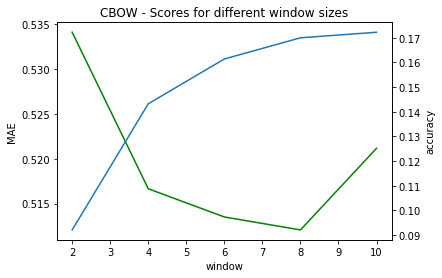

In [118]:
sns.lineplot(data=_cbow, x="window", y="MAE", color="g")
ax2 = plt.twinx()
sns.lineplot(data=_cbow, x="window", y="accuracy", ax=ax2).set_title('CBOW - Scores for different window sizes')

SKIP-GRAM

In [119]:
_sgram = df.loc[df['sg'] == 1]
_sgram

,size,min_count,alpha,window,sg,negative,iter,accuracy,MAE
1,100,1,0.025,2,1,20,25,0.074710,0.451035
3,100,1,0.025,4,1,20,25,0.117831,0.429933
5,100,1,0.025,6,1,20,25,0.126042,0.432236
7,100,1,0.025,8,1,20,25,0.136572,0.434162
9,100,1,0.025,10,1,20,25,0.141272,0.434693


Text(0.5, 1.0, 'CBOW - Scores for different window sizes')

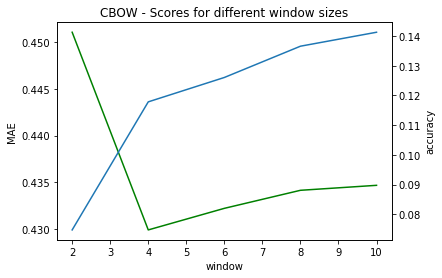

In [120]:
sns.lineplot(data=_sgram, x="window", y="MAE", color="g")
ax2 = plt.twinx()
sns.lineplot(data=_sgram, x="window", y="accuracy", ax=ax2).set_title('SKIP-GRAM - Scores for different window sizes')

#### Avaliando Text8 50%

**<span style="color:blue">Linhas azuis indicam Acurácia</span>**

**<span style="color:green">Linhas verdes indicam Erro Médio Absoluto (MAE)</span>**

In [121]:
_eval = grid_w2v_eval(param_dict,'text8_50c')

INFO - 14:58:40: loading Word2Vec object from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c


100 1 0.025 2 0 20 25
size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c


INFO - 14:58:40: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 14:58:40: loading vectors from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 14:58:41: setting ignored attribute vectors_norm to None
INFO - 14:58:41: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 14:58:41: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 14:58:41: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 14:58:41: setting ignored attribute cum_table to None
INFO - 14:58:41: loaded models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_50c
INFO - 14:58:41: p

3003 / 17476
100 1 0.025 2 1 20 25
size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c


INFO - 15:00:03: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 15:00:03: loading vectors from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 15:00:04: setting ignored attribute vectors_norm to None
INFO - 15:00:04: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 15:00:04: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 15:00:04: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 15:00:04: setting ignored attribute cum_table to None
INFO - 15:00:04: loaded models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_50c
INFO - 15:00:04: p

2650 / 17476
100 1 0.025 4 0 20 25
size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c


INFO - 15:01:24: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 15:01:24: loading vectors from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 15:01:25: setting ignored attribute vectors_norm to None
INFO - 15:01:25: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 15:01:25: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 15:01:25: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 15:01:25: setting ignored attribute cum_table to None
INFO - 15:01:25: loaded models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_50c
INFO - 15:01:26: p

4001 / 17476
100 1 0.025 4 1 20 25
size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c


INFO - 15:02:48: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 15:02:48: loading vectors from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 15:02:49: setting ignored attribute vectors_norm to None
INFO - 15:02:49: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 15:02:49: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 15:02:49: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 15:02:49: setting ignored attribute cum_table to None
INFO - 15:02:49: loaded models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_50c
INFO - 15:02:49: p

3486 / 17476
100 1 0.025 6 0 20 25
size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_50c


INFO - 15:04:12: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 15:04:12: loading vectors from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 15:04:13: setting ignored attribute vectors_norm to None
INFO - 15:04:13: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 15:04:13: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 15:04:13: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 15:04:13: setting ignored attribute cum_table to None
INFO - 15:04:13: loaded models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_50c
INFO - 15:04:14: p

4163 / 17476
100 1 0.025 6 1 20 25
size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_50c


INFO - 15:05:39: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 15:05:39: loading vectors from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 15:05:40: setting ignored attribute vectors_norm to None
INFO - 15:05:40: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 15:05:40: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 15:05:40: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 15:05:40: setting ignored attribute cum_table to None
INFO - 15:05:40: loaded models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_50c
INFO - 15:05:41: p

3731 / 17476
100 1 0.025 8 0 20 25
size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c


INFO - 15:07:07: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 15:07:07: loading vectors from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 15:07:08: setting ignored attribute vectors_norm to None
INFO - 15:07:08: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 15:07:08: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 15:07:08: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 15:07:08: setting ignored attribute cum_table to None
INFO - 15:07:08: loaded models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_50c
INFO - 15:07:09: p

4454 / 17476
100 1 0.025 8 1 20 25
size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c


INFO - 15:08:36: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 15:08:36: loading vectors from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 15:08:37: setting ignored attribute vectors_norm to None
INFO - 15:08:37: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 15:08:37: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 15:08:37: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 15:08:37: setting ignored attribute cum_table to None
INFO - 15:08:37: loaded models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_50c
INFO - 15:08:38: p

3699 / 17476
100 1 0.025 10 0 20 25
size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_50c


INFO - 15:10:05: loading wv recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 15:10:05: loading vectors from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 15:10:06: setting ignored attribute vectors_norm to None
INFO - 15:10:06: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 15:10:06: loading trainables recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 15:10:06: loading syn1neg from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 15:10:06: setting ignored attribute cum_table to None
INFO - 15:10:06: loaded models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_50c
INFO - 15:10

4585 / 17476
100 1 0.025 10 1 20 25
size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_50c


INFO - 15:11:42: loading wv recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_50c.wv.* with mmap=None
INFO - 15:11:42: loading vectors from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_50c.wv.vectors.npy with mmap=None
INFO - 15:11:42: setting ignored attribute vectors_norm to None
INFO - 15:11:42: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_50c.vocabulary.* with mmap=None
INFO - 15:11:42: loading trainables recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_50c.trainables.* with mmap=None
INFO - 15:11:42: loading syn1neg from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_50c.trainables.syn1neg.npy with mmap=None
INFO - 15:11:43: setting ignored attribute cum_table to None
INFO - 15:11:43: loaded models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_50c
INFO - 15:11

3849 / 17476


In [122]:
df = pd.DataFrame(_eval)
keys = list(param_dict.keys())
df.columns = [*keys,"accuracy","MAE"]

CBOW

In [123]:
_cbow = df.loc[df['sg'] == 0]
_cbow

,size,min_count,alpha,window,sg,negative,iter,accuracy,MAE
0,100,1,0.025,2,0,20,25,0.171836,0.491793
2,100,1,0.025,4,0,20,25,0.228943,0.453898
4,100,1,0.025,6,0,20,25,0.238212,0.454565
6,100,1,0.025,8,0,20,25,0.254864,0.449955
8,100,1,0.025,10,0,20,25,0.262360,0.452407


Text(0.5, 1.0, 'CBOW - Scores for different window sizes')

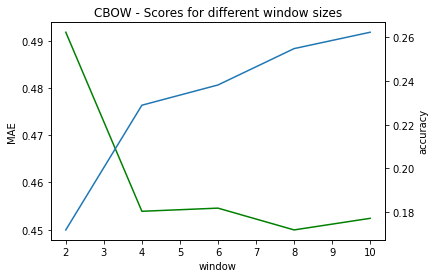

In [124]:
sns.lineplot(data=_cbow, x="window", y="MAE", color="g")
ax2 = plt.twinx()
sns.lineplot(data=_cbow, x="window", y="accuracy", ax=ax2).set_title('CBOW - Scores for different window sizes')

SKIP-GRAM

In [125]:
_sgram = df.loc[df['sg'] == 1]
_sgram

,size,min_count,alpha,window,sg,negative,iter,accuracy,MAE
1,100,1,0.025,2,1,20,25,0.151637,0.396597
3,100,1,0.025,4,1,20,25,0.199474,0.370576
5,100,1,0.025,6,1,20,25,0.213493,0.366316
7,100,1,0.025,8,1,20,25,0.211662,0.371307
9,100,1,0.025,10,1,20,25,0.220245,0.367904


Text(0.5, 1.0, 'CBOW - Scores for different window sizes')

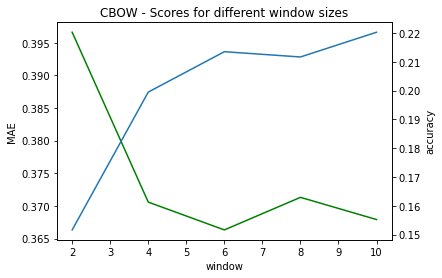

In [126]:
sns.lineplot(data=_sgram, x="window", y="MAE", color="g")
ax2 = plt.twinx()
sns.lineplot(data=_sgram, x="window", y="accuracy", ax=ax2).set_title('SKIP-GRAM - Scores for different window sizes')

#### Avaliando Text8 75%

**<span style="color:blue">Linhas azuis indicam Acurácia</span>**

**<span style="color:green">Linhas verdes indicam Erro Médio Absoluto (MAE)</span>**

In [127]:
_eval = grid_w2v_eval(param_dict,'text8_75c')

INFO - 15:13:14: loading Word2Vec object from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c


100 1 0.025 2 0 20 25
size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c


INFO - 15:13:14: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:13:14: loading vectors from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:13:15: setting ignored attribute vectors_norm to None
INFO - 15:13:15: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:13:15: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:13:15: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:13:15: setting ignored attribute cum_table to None
INFO - 15:13:15: loaded models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_75c
INFO - 15:13:16: p

3909 / 17888
100 1 0.025 2 1 20 25
size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c


INFO - 15:15:11: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:15:11: loading vectors from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:15:11: setting ignored attribute vectors_norm to None
INFO - 15:15:11: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:15:11: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:15:11: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:15:12: setting ignored attribute cum_table to None
INFO - 15:15:12: loaded models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_75c
INFO - 15:15:12: p

3660 / 17888
100 1 0.025 4 0 20 25
size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c


INFO - 15:17:07: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:17:07: loading vectors from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:17:07: setting ignored attribute vectors_norm to None
INFO - 15:17:07: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:17:07: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:17:07: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:17:08: setting ignored attribute cum_table to None
INFO - 15:17:08: loaded models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_75c
INFO - 15:17:08: p

5432 / 17888
100 1 0.025 4 1 20 25
size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c


INFO - 15:19:07: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:19:07: loading vectors from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:19:07: setting ignored attribute vectors_norm to None
INFO - 15:19:07: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:19:07: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:19:07: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:19:08: setting ignored attribute cum_table to None
INFO - 15:19:08: loaded models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_75c
INFO - 15:19:08: p

4507 / 17888
100 1 0.025 6 0 20 25
size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_75c


INFO - 15:21:05: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:21:05: loading vectors from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:21:06: setting ignored attribute vectors_norm to None
INFO - 15:21:06: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:21:06: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:21:06: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:21:07: setting ignored attribute cum_table to None
INFO - 15:21:07: loaded models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_75c
INFO - 15:21:08: p

5697 / 17888
100 1 0.025 6 1 20 25
size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_75c


INFO - 15:23:02: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:23:02: loading vectors from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:23:03: setting ignored attribute vectors_norm to None
INFO - 15:23:03: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:23:03: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:23:03: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:23:04: setting ignored attribute cum_table to None
INFO - 15:23:04: loaded models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_75c
INFO - 15:23:04: p

4805 / 17888
100 1 0.025 8 0 20 25
size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c


INFO - 15:25:01: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:25:01: loading vectors from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:25:01: setting ignored attribute vectors_norm to None
INFO - 15:25:01: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:25:01: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:25:01: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:25:02: setting ignored attribute cum_table to None
INFO - 15:25:02: loaded models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_75c
INFO - 15:25:02: p

5651 / 17888
100 1 0.025 8 1 20 25
size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c


INFO - 15:26:45: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:26:45: loading vectors from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:26:46: setting ignored attribute vectors_norm to None
INFO - 15:26:46: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:26:46: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:26:46: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:26:46: setting ignored attribute cum_table to None
INFO - 15:26:46: loaded models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_75c
INFO - 15:26:47: p

4843 / 17888
100 1 0.025 10 0 20 25
size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_75c


INFO - 15:28:22: loading wv recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:28:22: loading vectors from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:28:23: setting ignored attribute vectors_norm to None
INFO - 15:28:23: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:28:23: loading trainables recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:28:23: loading syn1neg from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:28:24: setting ignored attribute cum_table to None
INFO - 15:28:24: loaded models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_75c
INFO - 15:28

5762 / 17888
100 1 0.025 10 1 20 25
size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_75c


INFO - 15:30:04: loading wv recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_75c.wv.* with mmap=None
INFO - 15:30:04: loading vectors from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_75c.wv.vectors.npy with mmap=None
INFO - 15:30:05: setting ignored attribute vectors_norm to None
INFO - 15:30:05: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_75c.vocabulary.* with mmap=None
INFO - 15:30:05: loading trainables recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_75c.trainables.* with mmap=None
INFO - 15:30:05: loading syn1neg from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_75c.trainables.syn1neg.npy with mmap=None
INFO - 15:30:06: setting ignored attribute cum_table to None
INFO - 15:30:06: loaded models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_75c
INFO - 15:30

5093 / 17888


In [128]:
df = pd.DataFrame(_eval)
keys = list(param_dict.keys())
df.columns = [*keys,"accuracy","MAE"]

CBOW

In [129]:
_cbow = df.loc[df['sg'] == 0]
_cbow

,size,min_count,alpha,window,sg,negative,iter,accuracy,MAE
0,100,1,0.025,2,0,20,25,0.218526,0.453706
2,100,1,0.025,4,0,20,25,0.303667,0.398454
4,100,1,0.025,6,0,20,25,0.318482,0.393478
6,100,1,0.025,8,0,20,25,0.315910,0.399532
8,100,1,0.025,10,0,20,25,0.322115,0.402276


Text(0.5, 1.0, 'CBOW - Scores for different window sizes')

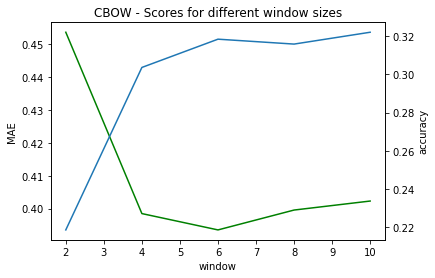

In [130]:
sns.lineplot(data=_cbow, x="window", y="MAE", color="g")
ax2 = plt.twinx()
sns.lineplot(data=_cbow, x="window", y="accuracy", ax=ax2).set_title('CBOW - Scores for different window sizes')

SKIP-GRAM

In [131]:
_sgram = df.loc[df['sg'] == 1]
_sgram

,size,min_count,alpha,window,sg,negative,iter,accuracy,MAE
1,100,1,0.025,2,1,20,25,0.204606,0.359545
3,100,1,0.025,4,1,20,25,0.251957,0.334500
5,100,1,0.025,6,1,20,25,0.268616,0.328889
7,100,1,0.025,8,1,20,25,0.270740,0.330210
9,100,1,0.025,10,1,20,25,0.284716,0.326031


Text(0.5, 1.0, 'CBOW - Scores for different window sizes')

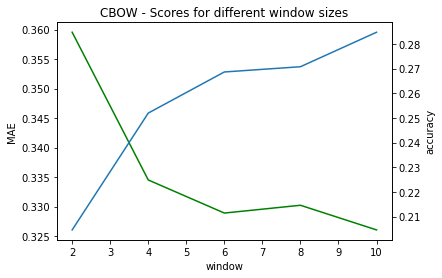

In [132]:
sns.lineplot(data=_sgram, x="window", y="MAE", color="g")
ax2 = plt.twinx()
sns.lineplot(data=_sgram, x="window", y="accuracy", ax=ax2).set_title('SKIP-GRAM - Scores for different window sizes')

#### Avaliando Text8 100%

**<span style="color:blue">Linhas azuis indicam Acurácia</span>**

**<span style="color:green">Linhas verdes indicam Erro Médio Absoluto (MAE)</span>**

In [133]:
_eval = grid_w2v_eval(param_dict,'text8_100c')

INFO - 15:31:42: loading Word2Vec object from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c


100 1 0.025 2 0 20 25
size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c


INFO - 15:31:42: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 15:31:42: loading vectors from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 15:31:43: setting ignored attribute vectors_norm to None
INFO - 15:31:43: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 15:31:43: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 15:31:43: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 15:31:44: setting ignored attribute cum_table to None
INFO - 15:31:44: loaded models/size100-min_count1-alpha0.025-window2-sg0-negative20-iter25-text8_100c
INFO - 15:31

4794 / 18256
100 1 0.025 2 1 20 25
size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c


INFO - 15:33:43: loading wv recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 15:33:43: loading vectors from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 15:33:43: setting ignored attribute vectors_norm to None
INFO - 15:33:43: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 15:33:43: loading trainables recursively from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 15:33:43: loading syn1neg from models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 15:33:44: setting ignored attribute cum_table to None
INFO - 15:33:44: loaded models/size100-min_count1-alpha0.025-window2-sg1-negative20-iter25-text8_100c
INFO - 15:33

4766 / 18256
100 1 0.025 4 0 20 25
size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c


INFO - 15:35:45: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 15:35:45: loading vectors from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 15:35:46: setting ignored attribute vectors_norm to None
INFO - 15:35:46: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 15:35:46: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 15:35:46: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 15:35:47: setting ignored attribute cum_table to None
INFO - 15:35:47: loaded models/size100-min_count1-alpha0.025-window4-sg0-negative20-iter25-text8_100c
INFO - 15:35

6379 / 18256
100 1 0.025 4 1 20 25
size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c


INFO - 15:37:56: loading wv recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 15:37:56: loading vectors from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 15:37:57: setting ignored attribute vectors_norm to None
INFO - 15:37:57: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 15:37:57: loading trainables recursively from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 15:37:57: loading syn1neg from models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 15:37:57: setting ignored attribute cum_table to None
INFO - 15:37:57: loaded models/size100-min_count1-alpha0.025-window4-sg1-negative20-iter25-text8_100c
INFO - 15:37

5679 / 18256
100 1 0.025 6 0 20 25
size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c


INFO - 15:40:09: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 15:40:09: loading vectors from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 15:40:10: setting ignored attribute vectors_norm to None
INFO - 15:40:10: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 15:40:10: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 15:40:10: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 15:40:11: setting ignored attribute cum_table to None
INFO - 15:40:11: loaded models/size100-min_count1-alpha0.025-window6-sg0-negative20-iter25-text8_100c
INFO - 15:40

6642 / 18256
100 1 0.025 6 1 20 25
size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c


INFO - 15:43:17: loading wv recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 15:43:17: loading vectors from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 15:43:18: setting ignored attribute vectors_norm to None
INFO - 15:43:18: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 15:43:18: loading trainables recursively from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 15:43:18: loading syn1neg from models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 15:43:19: setting ignored attribute cum_table to None
INFO - 15:43:19: loaded models/size100-min_count1-alpha0.025-window6-sg1-negative20-iter25-text8_100c
INFO - 15:43

5834 / 18256
100 1 0.025 8 0 20 25
size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c


INFO - 15:46:16: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 15:46:16: loading vectors from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 15:46:17: setting ignored attribute vectors_norm to None
INFO - 15:46:17: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 15:46:17: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 15:46:17: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 15:46:18: setting ignored attribute cum_table to None
INFO - 15:46:18: loaded models/size100-min_count1-alpha0.025-window8-sg0-negative20-iter25-text8_100c
INFO - 15:46

6721 / 18256
100 1 0.025 8 1 20 25
size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c


INFO - 15:49:15: loading wv recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 15:49:15: loading vectors from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 15:49:15: setting ignored attribute vectors_norm to None
INFO - 15:49:15: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 15:49:15: loading trainables recursively from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 15:49:15: loading syn1neg from models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 15:49:16: setting ignored attribute cum_table to None
INFO - 15:49:16: loaded models/size100-min_count1-alpha0.025-window8-sg1-negative20-iter25-text8_100c
INFO - 15:49

5917 / 18256
100 1 0.025 10 0 20 25
size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c


INFO - 15:52:27: loading wv recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 15:52:27: loading vectors from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 15:52:28: setting ignored attribute vectors_norm to None
INFO - 15:52:28: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 15:52:28: loading trainables recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 15:52:28: loading syn1neg from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 15:52:30: setting ignored attribute cum_table to None
INFO - 15:52:30: loaded models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c
INFO -

6793 / 18256
100 1 0.025 10 1 20 25
size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_100c


INFO - 15:55:35: loading wv recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 15:55:35: loading vectors from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 15:55:37: setting ignored attribute vectors_norm to None
INFO - 15:55:37: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 15:55:37: loading trainables recursively from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 15:55:37: loading syn1neg from models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 15:55:38: setting ignored attribute cum_table to None
INFO - 15:55:38: loaded models/size100-min_count1-alpha0.025-window10-sg1-negative20-iter25-text8_100c
INFO -

5827 / 18256


In [134]:
df = pd.DataFrame(_eval)
keys = list(param_dict.keys())
df.columns = [*keys,"accuracy","MAE"]

CBOW

In [135]:
_cbow = df.loc[df['sg'] == 0]
_cbow

,size,min_count,alpha,window,sg,negative,iter,accuracy,MAE
0,100,1,0.025,2,0,20,25,0.262599,0.423904
2,100,1,0.025,4,0,20,25,0.349419,0.372366
4,100,1,0.025,6,0,20,25,0.363826,0.367463
6,100,1,0.025,8,0,20,25,0.368153,0.366504
8,100,1,0.025,10,0,20,25,0.372097,0.368759


Text(0.5, 1.0, 'CBOW - Scores for different window sizes')

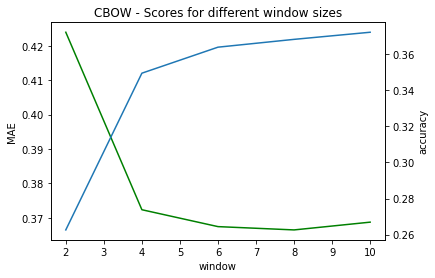

In [136]:
sns.lineplot(data=_cbow, x="window", y="MAE", color="g")
ax2 = plt.twinx()
sns.lineplot(data=_cbow, x="window", y="accuracy", ax=ax2).set_title('CBOW - Scores for different window sizes')

SKIP-GRAM

In [137]:
_sgram = df.loc[df['sg'] == 1]
_sgram

,size,min_count,alpha,window,sg,negative,iter,accuracy,MAE
1,100,1,0.025,2,1,20,25,0.261065,0.327772
3,100,1,0.025,4,1,20,25,0.311076,0.303212
5,100,1,0.025,6,1,20,25,0.319566,0.296856
7,100,1,0.025,8,1,20,25,0.324113,0.296180
9,100,1,0.025,10,1,20,25,0.319183,0.301305


Text(0.5, 1.0, 'CBOW - Scores for different window sizes')

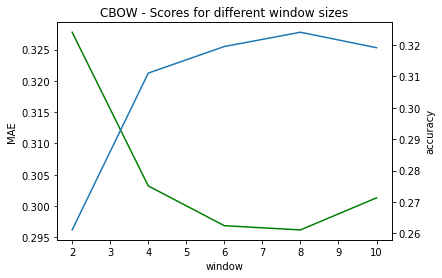

In [138]:
sns.lineplot(data=_sgram, x="window", y="MAE", color="g")
ax2 = plt.twinx()
sns.lineplot(data=_sgram, x="window", y="accuracy", ax=ax2).set_title('SKIP-GRAM - Scores for different window sizes')

## 3 Explorando o modelo de melhor desempenho

Nesta seção, exploraremos o modelo de maior desempenho nas avaliações vistas anteriormente.

In [139]:
model_name = "size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c"

In [140]:
try:
    model = Word2Vec.load(basicModelOutputhPath + model_name)
except:
    print("failed to load")

INFO - 16:03:02: loading Word2Vec object from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c
INFO - 16:03:03: loading wv recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.wv.* with mmap=None
INFO - 16:03:03: loading vectors from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.wv.vectors.npy with mmap=None
INFO - 16:03:03: setting ignored attribute vectors_norm to None
INFO - 16:03:03: loading vocabulary recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.vocabulary.* with mmap=None
INFO - 16:03:03: loading trainables recursively from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.trainables.* with mmap=None
INFO - 16:03:03: loading syn1neg from models/size100-min_count1-alpha0.025-window10-sg0-negative20-iter25-text8_100c.trainables.syn1neg.npy with mmap=None
INFO - 16:03:03: setting ignored attribute cu

Como não planejamos treinar mais o modelo, chamaremos `init_sims()`, o que tornará o modelo muito mais eficiente em termos de memória:

In [141]:
model.init_sims(replace=True)

INFO - 16:03:03: precomputing L2-norms of word weight vectors


Executaremos novamente a avaliação de analogias mas, desta vez, pela função `evaluate_word_analogies()` do Gensim, para podermos observar a acurácia do modelo em cada uma das categorias:

In [142]:
model.wv.evaluate_word_analogies(qWordsPath)

INFO - 16:03:03: Evaluating word analogies for top 300000 words in the model on questions-words.txt
INFO - 16:03:07: capital-common-countries: 75.3% (381/506)
INFO - 16:03:43: capital-world: 43.0% (1814/4216)
INFO - 16:03:50: currency: 11.5% (100/866)
INFO - 16:04:13: city-in-state: 36.3% (895/2467)
INFO - 16:04:17: family: 49.0% (206/420)
INFO - 16:04:25: gram1-adjective-to-adverb: 15.2% (132/870)
INFO - 16:04:32: gram2-opposite: 6.3% (51/812)
INFO - 16:04:43: gram3-comparative: 39.4% (525/1332)
INFO - 16:04:50: gram4-superlative: 20.5% (203/992)
INFO - 16:04:56: gram5-present-participle: 24.2% (183/756)
INFO - 16:05:09: gram6-nationality-adjective: 72.5% (1160/1599)
INFO - 16:05:22: gram7-past-tense: 28.1% (439/1560)
INFO - 16:05:32: gram8-plural: 45.2% (570/1260)
INFO - 16:05:37: gram9-plural-verbs: 22.3% (134/600)
INFO - 16:05:37: Quadruplets with out-of-vocabulary words: 6.6%
INFO - 16:05:37: NB: analogies containing OOV words were skipped from evaluation! To change this behavior,

(0.3720968448729185,
 [{'section': 'capital-common-countries',
   'correct': [('ATHENS', 'GREECE', 'BANGKOK', 'THAILAND'),
    ('ATHENS', 'GREECE', 'BEIJING', 'CHINA'),
    ('ATHENS', 'GREECE', 'BERLIN', 'GERMANY'),
    ('ATHENS', 'GREECE', 'BERN', 'SWITZERLAND'),
    ('ATHENS', 'GREECE', 'CAIRO', 'EGYPT'),
    ('ATHENS', 'GREECE', 'CANBERRA', 'AUSTRALIA'),
    ('ATHENS', 'GREECE', 'HAVANA', 'CUBA'),
    ('ATHENS', 'GREECE', 'HELSINKI', 'FINLAND'),
    ('ATHENS', 'GREECE', 'ISLAMABAD', 'PAKISTAN'),
    ('ATHENS', 'GREECE', 'KABUL', 'AFGHANISTAN'),
    ('ATHENS', 'GREECE', 'MADRID', 'SPAIN'),
    ('ATHENS', 'GREECE', 'MOSCOW', 'RUSSIA'),
    ('ATHENS', 'GREECE', 'OSLO', 'NORWAY'),
    ('ATHENS', 'GREECE', 'OTTAWA', 'CANADA'),
    ('ATHENS', 'GREECE', 'PARIS', 'FRANCE'),
    ('ATHENS', 'GREECE', 'ROME', 'ITALY'),
    ('ATHENS', 'GREECE', 'STOCKHOLM', 'SWEDEN'),
    ('ATHENS', 'GREECE', 'TEHRAN', 'IRAN'),
    ('ATHENS', 'GREECE', 'TOKYO', 'JAPAN'),
    ('BAGHDAD', 'IRAQ', 'BANGKOK', 'THAI

Mostraremos abaixo resultados de algumas buscas de similaridade para alguns termos:

In [143]:
model.wv.most_similar(positive=["anarchism"])

[('individualist', 0.8087031841278076),
 ('anarchist', 0.7510337233543396),
 ('anarcho', 0.7499205470085144),
 ('individualists', 0.7427310943603516),
 ('libertarianism', 0.7366424798965454),
 ('anarchists', 0.728975772857666),
 ('collectivism', 0.7038904428482056),
 ('egoist', 0.6987338066101074),
 ('stirner', 0.6895251274108887),
 ('individualism', 0.6797782182693481)]

In [144]:
model.wv.most_similar(positive=["england"])

[('scotland', 0.6639866828918457),
 ('wales', 0.6635952591896057),
 ('somerset', 0.6490188837051392),
 ('midlands', 0.6211152076721191),
 ('lancashire', 0.6194684505462646),
 ('warwickshire', 0.6098679304122925),
 ('gloucestershire', 0.6023787260055542),
 ('fife', 0.5870155096054077),
 ('barons', 0.5785649418830872),
 ('mercia', 0.574777364730835)]

In [145]:
model.wv.most_similar(positive=["happy"])

[('loved', 0.6300077438354492),
 ('lovely', 0.6239891648292542),
 ('laugh', 0.5916695594787598),
 ('loves', 0.5768120288848877),
 ('wonderful', 0.5710158348083496),
 ('happily', 0.5709359049797058),
 ('goodbye', 0.562301516532898),
 ('liked', 0.5546574592590332),
 ('endure', 0.5537489056587219),
 ('flirt', 0.5521771907806396)]

In [146]:
model.wv.most_similar(positive=["violence"])

[('violent', 0.7629618644714355),
 ('abuse', 0.6507358551025391),
 ('intimidation', 0.6077768802642822),
 ('immoral', 0.6004897952079773),
 ('crime', 0.5991014242172241),
 ('abusive', 0.5978039503097534),
 ('conflict', 0.5841457843780518),
 ('incidents', 0.5834091305732727),
 ('terrorism', 0.5740377902984619),
 ('massacres', 0.5710349678993225)]

### Visualização t-SNE

Por fim, mostraremos uma visualização do nosso modelo pelo t-SNE. Como o vocabulário é muito extenso, utilizaremos as 1000 primeiras palavras.

In [147]:
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.manifold import TSNE

In [157]:
def tsne_plot_1000(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    count = 0
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        if count==1000:
            break;
        count +=1
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

<ipython-input-157-69666470ad47>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


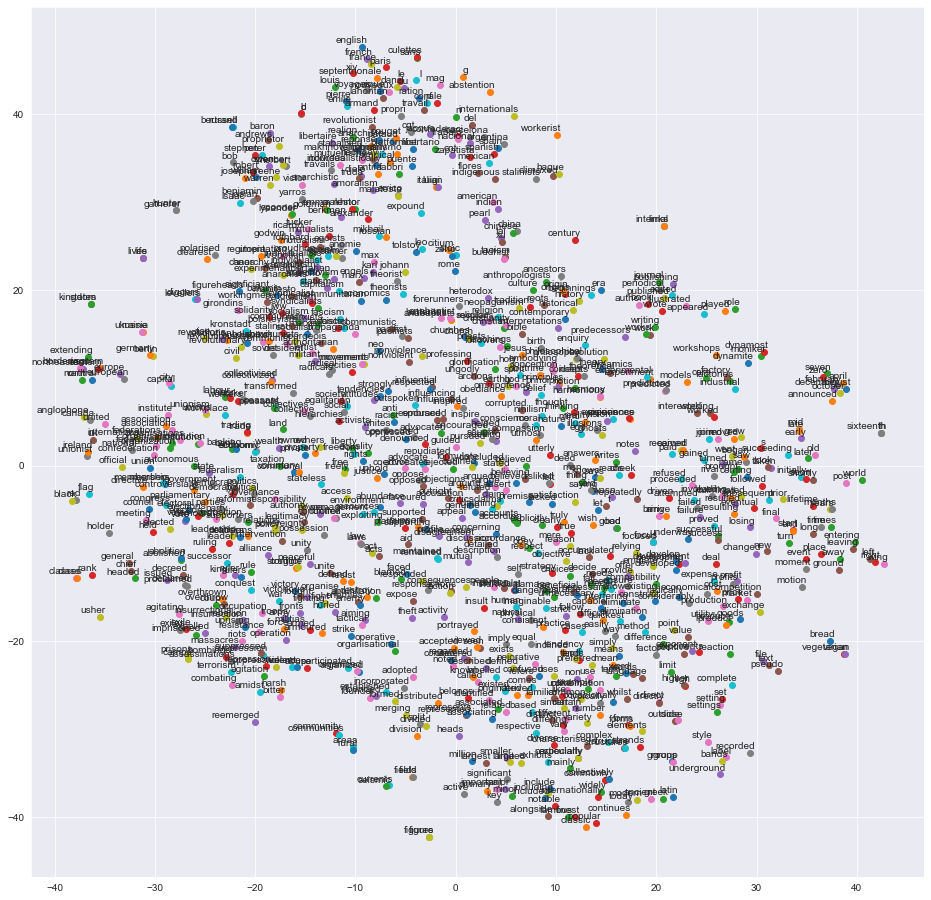

In [158]:
tsne_plot_1000(model)